In [2]:
# --- podstawy ---
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# --- sklearn: przygotowanie, modele, metryki, pipeline ---
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# --- xgboost (boosting drzew) ---
import xgboost as xgb
import shap 
# --- wizualizacje ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,5)

DATA_PATH = Path("../data/processed/epl_features.csv")
RANDOM_STATE = 42


In [3]:
df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.sort_values(["Date", "HomeTeam", "AwayTeam"]).reset_index(drop=True)
print(df.shape)
df.head(3)


(3420, 100)


Div       Date           HomeTeam        AwayTeam  Referee  FTHG  FTAG FTR  \
0  E0 2014-08-16            Arsenal  Crystal Palace   J Moss   2.0   1.0   H   
1  E0 2014-08-16          Leicester         Everton  M Jones   2.0   2.0   D   
2  E0 2014-08-16  Manchester United         Swansea   M Dean   1.0   2.0   A   

     HS    AS  ...  IsHomeAlways1  Month  Weekday  IsWeekend  \
0  14.0   4.0  ...              1      8        5          1   
1  11.0  13.0  ...              1      8        5          1   
2  14.0   5.0  ...              1      8        5          1   

   Home_AvgPts_season  Home_AvgGD_season  Away_AvgPts_season  \
0                 NaN                NaN                 NaN   
1                 NaN                NaN                 NaN   
2                 NaN                NaN                 NaN   

   Away_AvgGD_season  SeasonStrength_PtsDiff  SeasonStrength_GDDiff  
0                NaN                     NaN                    NaN  
1                NaN                     NaN                    NaN  
2                NaN                     NaN                    NaN  

[3 rows x 100 columns]

In [4]:
target = "FTR"

cols_to_exclude = {
    # meta / identyfikatory
    "Div", "Date", "Season", "SourceFile", "HomeTeam", "AwayTeam", "Referee",

    # wynikowe i bieżące statystyki meczu (niedostępne przed meczem)
    "FTHG", "FTAG", "HTHG", "HTAG", "FTR",
    "GoalDiff", "TotalGoals",
    "HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC",
    "HY", "AY", "HR", "AR",

    # NOWE — usuwamy nadmiarowe prawdopodobieństwa, które psują regresję
    "Prob_D_b365", "Prob_A_b365"

    # jeśli masz inne pary typu Prob_D_ps / Prob_A_ps itp. — też dodaj je tutaj
}

# kandydaci na cechy:
candidate_cols = [
    c for c in df.columns
    if c not in cols_to_exclude
]

# wzorce cech predykcyjnych (rynek, forma, sezon, czas)
keep_patterns = (
    "Prob_", "Margin_", "OddsDiff", "OddsSpread",
    "Home_", "Away_", "FormDiff_", "Pts_trend_3v10",
    "SeasonStrength_", "Month", "Weekday", "IsWeekend"
)

X_features = [c for c in candidate_cols if any(p in c for p in keep_patterns)]

# sanity check
print(f"Liczba wybranych cech: {len(X_features)}")
X_features[:10]


Liczba wybranych cech: 56


['Prob_H_b365',
 'Margin_B365',
 'OddsDiff_B365',
 'Prob_H_ps',
 'Prob_D_ps',
 'Prob_A_ps',
 'Margin_PS',
 'OddsDiff_PS',
 'OddsSpread_H',
 'OddsSpread_D']

In [5]:
# label encoding dla y (H/D/A -> 0/1/2)
le = LabelEncoder()
y = le.fit_transform(df[target])

# split po dacie (przykład: uczymy na meczach przed 2020-01-01, testujemy na 2020+)
split_date = pd.Timestamp("2022-07-01")
train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X = df[X_features].copy()

X_train = X.loc[train_mask].reset_index(drop=True)
X_test  = X.loc[test_mask].reset_index(drop=True)
y_train = y[train_mask]
y_test  = y[test_mask]

X_train.shape, X_test.shape, len(y_train), len(y_test)


((2660, 56), (760, 56), 2660, 760)

Liczba cech: 56

=== CROSS-VALIDATION (RMSE) ===
Linear Regression: RMSE mean=0.9282 | std=0.1161
Ridge Regression: RMSE mean=0.7835 | std=0.0233
Lasso Regression: RMSE mean=0.7800 | std=0.0238
ElasticNet Regression: RMSE mean=0.7808 | std=0.0236

==================== Linear Regression ====================
RMSE: 0.7808
R²:   0.1869
Accuracy (po mapowaniu): 0.3645
Macro-F1 (po mapowaniu): 0.3519


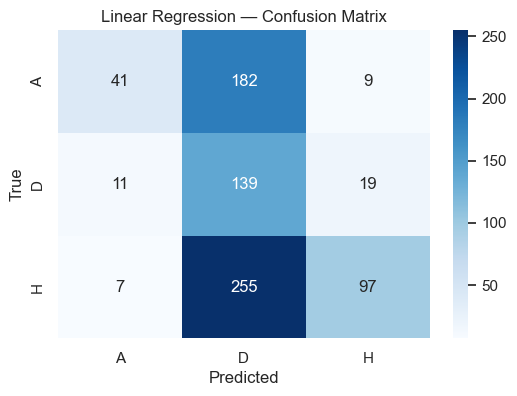


==================== Ridge Regression ====================
RMSE: 0.7802
R²:   0.1881
Accuracy (po mapowaniu): 0.3632
Macro-F1 (po mapowaniu): 0.3521


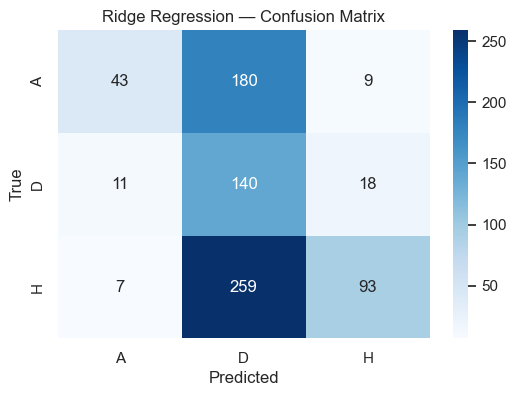


==================== Lasso Regression ====================
RMSE: 0.7786
R²:   0.1914
Accuracy (po mapowaniu): 0.3645
Macro-F1 (po mapowaniu): 0.3543


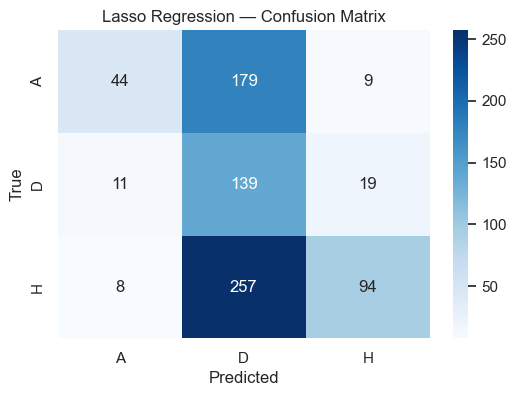


==================== ElasticNet Regression ====================
RMSE: 0.7795
R²:   0.1895
Accuracy (po mapowaniu): 0.3697
Macro-F1 (po mapowaniu): 0.3599


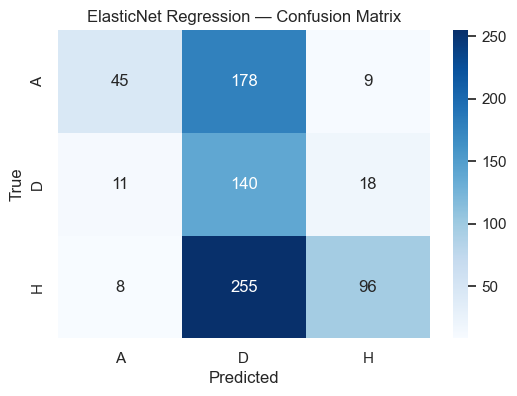


=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA A) ===


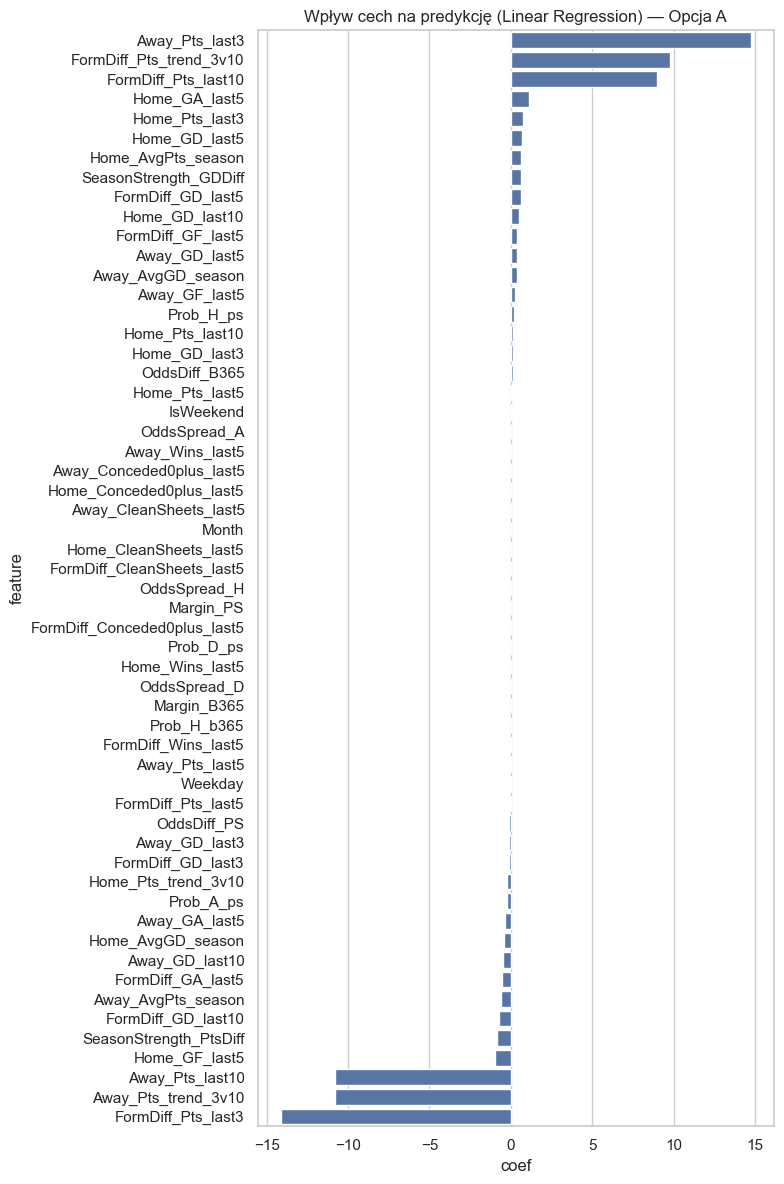

feature       coef
30                Away_Pts_last3  14.713816
46       FormDiff_Pts_trend_3v10   9.797937
44           FormDiff_Pts_last10   8.980795
12                 Home_GA_last5   1.092842
18                Home_Pts_last3   0.743953
13                 Home_GD_last5   0.672845
50            Home_AvgPts_season   0.623882
55         SeasonStrength_GDDiff   0.602359
37             FormDiff_GD_last5   0.597688
21                Home_GD_last10   0.516454
35             FormDiff_GF_last5   0.398877
25                 Away_GD_last5   0.398383
53             Away_AvgGD_season   0.378078
23                 Away_GF_last5   0.258419
3                      Prob_H_ps   0.208289
20               Home_Pts_last10   0.133608
19                 Home_GD_last3   0.128597
2                  OddsDiff_B365   0.121346
14                Home_Pts_last5   0.081491
49                     IsWeekend   0.040335
10                  OddsSpread_A   0.035721
27               Away_Wins_last5   0.023582
29      Away_Conceded0plus_last5   0.021212
17      Home_Conceded0plus_last5   0.007556
28        Away_CleanSheets_last5   0.002577
47                         Month   0.000816
16        Home_CleanSheets_last5  -0.001502
40    FormDiff_CleanSheets_last5  -0.002962
8                   OddsSpread_H  -0.005747
6                      Margin_PS  -0.005960
41  FormDiff_Conceded0plus_last5  -0.010123
4                      Prob_D_ps  -0.011025
15               Home_Wins_last5  -0.017075
9                   OddsSpread_D  -0.017669
1                    Margin_B365  -0.021145
0                    Prob_H_b365  -0.024291
39           FormDiff_Wins_last5  -0.029302
26                Away_Pts_last5  -0.059313
48                       Weekday  -0.059425
38            FormDiff_Pts_last5  -0.075614
7                    OddsDiff_PS  -0.095797
31                 Away_GD_last3  -0.137561
43             FormDiff_GD_last3  -0.147192
22           Home_Pts_trend_3v10  -0.210340
5                      Prob_A_ps  -0.226248
24                 Away_GA_last5  -0.389162
51             Home_AvgGD_season  -0.417704
33                Away_GD_last10  -0.469857
36             FormDiff_GA_last5  -0.569976
52            Away_AvgPts_season  -0.601928
45            FormDiff_GD_last10  -0.749081
54        SeasonStrength_PtsDiff  -0.879777
11                 Home_GF_last5  -0.996559
32               Away_Pts_last10 -10.782047
34           Away_Pts_trend_3v10 -10.824490
42            FormDiff_Pts_last3 -14.112607

In [111]:
# ============================================
# 1. Importy
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler





# ============================================
# 2. Selekcja cech
# ============================================

target = "FTR"

cols_to_exclude = {
    # meta / identyfikatory
    "Div", "Date", "Season", "SourceFile", "HomeTeam", "AwayTeam", "Referee",

    # wynikowe i bieżące statystyki meczu (niedostępne przed meczem)
    "FTHG", "FTAG", "HTHG", "HTAG", "FTR",
    "GoalDiff", "TotalGoals",
    "HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC",
    "HY", "AY", "HR", "AR",

    # NOWE — usuwamy nadmiarowe prawdopodobieństwa, które psują regresję
    "Prob_D_b365", "Prob_A_b365"

    # jeśli masz inne pary typu Prob_D_ps / Prob_A_ps itp. — też dodaj je tutaj
}


candidate_cols = [c for c in df.columns if c not in cols_to_exclude]

keep_patterns = (
    "Prob_", "Margin_", "OddsDiff", "OddsSpread",
    "Home_", "Away_", "FormDiff_", "Pts_trend_3v10",
    "SeasonStrength_", "Month", "Weekday", "IsWeekend", "Market_"
)

X_features = [c for c in candidate_cols if any(p in c for p in keep_patterns)]

print("Liczba cech:", len(X_features))



# ============================================
# 3. Kodowanie celu (OPCJA A)
# ============================================

encoding = {"A": -1, "D": 0, "H": 1}
y = df[target].map(encoding).values




# ============================================
# 4. Podział danych czasowy
# ============================================

split_date = pd.Timestamp("2022-07-01")

train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X = df[X_features].copy()

X_train = X.loc[train_mask].reset_index(drop=True)
X_test  = X.loc[test_mask].reset_index(drop=True)
y_train = y[train_mask]
y_test  = y[test_mask]

X_train.shape, X_test.shape




# ============================================
# 5. Funkcja: predykcja regresji → klasa
# ============================================

def regress_to_class(y_pred):
    # zwróci 0=A, 1=D, 2=H
    return np.digitize(y_pred, bins=[-0.5, 0.5])









# ============================================
# 6. Ewaluacja modelu regresyjnego
# ============================================

def evaluate_regression_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n==================== {name} ====================")

    # --- trenowanie ---
    model.fit(X_train, y_train)
    y_pred_cont = model.predict(X_test)

    # --- metryki regresyjne ---
    rmse = mean_squared_error(y_test, y_pred_cont, squared=False)
    r2 = r2_score(y_test, y_pred_cont)
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # --- mapowanie regresji -> klasy ---
    y_pred = regress_to_class(y_pred_cont)   # wyniki: 0, 1, 2

    # prawdziwe dane (-1, 0, 1) -> A,D,H
    mapping_true = {-1:"A", 0:"D", 1:"H"}
    y_test_cls = [mapping_true[v] for v in y_test]

    # predykcje (0,1,2) -> A,D,H
    mapping_pred = {0:"A", 1:"D", 2:"H"}
    y_pred_cls = [mapping_pred[v] for v in y_pred]

    # --- metryki klasyfikacyjne ---
    acc = accuracy_score(y_test_cls, y_pred_cls)
    f1m = f1_score(y_test_cls, y_pred_cls, average="macro")
    print(f"Accuracy (po mapowaniu): {acc:.4f}")
    print(f"Macro-F1 (po mapowaniu): {f1m:.4f}")

    # --- confusion matrix ---
    cm = confusion_matrix(y_test_cls, y_pred_cls)
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["A","D","H"], yticklabels=["A","D","H"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

    return acc, f1m, rmse, r2











# ============================================
# 7. Pipeline
# ============================================

def make_pipeline(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])








# ============================================
# 8. Modele regresyjne
# ============================================

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}












# ============================================
# 9. Cross-validation RMSE
# ============================================

print("\n=== CROSS-VALIDATION (RMSE) ===")

for name, model in models.items():
    pipe = make_pipeline(model)
    scores = cross_val_score(
        pipe, X_train, y_train, cv=5,
        scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-scores)

    print(f"{name}: RMSE mean={rmse_scores.mean():.4f} | std={rmse_scores.std():.4f}")







# ============================================
# 10. Pełna ewaluacja modeli
# ============================================

results = []

for name, model in models.items():
    pipe = make_pipeline(model)
    acc, f1m, rmse, r2 = evaluate_regression_model(
        name, pipe, X_train, y_train, X_test, y_test
    )
    results.append([name, acc, f1m, rmse, r2])









# ============================================
# 11. Podsumowanie wyników
# ============================================

df_results = pd.DataFrame(
    results,
    columns=["Model","Accuracy","Macro-F1","RMSE","R²"]
)

print("\n=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA A) ===")
df_results








# ============================================
# 12. Analiza współczynników (Linear Regression)
# ============================================

lin_pipe = make_pipeline(LinearRegression())
lin_pipe.fit(X_train, y_train)

coefs = lin_pipe.named_steps["model"].coef_
features = X_train.columns

coef_df = pd.DataFrame({"feature": features, "coef": coefs})
coef_df = coef_df.sort_values("coef", ascending=False)

plt.figure(figsize=(8,12))
sns.barplot(data=coef_df, x="coef", y="feature")
plt.title("Wpływ cech na predykcję (Linear Regression) — Opcja A")
plt.tight_layout()
plt.show()

coef_df












## 4.2. Model OPCJA B — Regresja GoalDiff i mapowanie na klasy H/D/A

W klasycznym podejściu (OPCJA A) model próbuje bezpośrednio przewidywać
kategorię wyniku meczu (H – wygrana gospodarzy, D – remis, A – wygrana gości).
Jest to jednak zadanie trudne dla modeli liniowych, ponieważ klasy są
dyskretne i nieliniowo separowalne.

Aby uzyskać bardziej stabilne wyniki, wprowadzono alternatywne podejście:

**OPCJA B — przewidywanie różnicy bramek (GoalDiff) jako zmiennej ciągłej,  
a następnie mapowanie wartości regresji na klasy H/D/A.**

Różnica bramek definiowana jest jako:

\[
GoalDiff = FTHG - FTAG
\]

gdzie:  
- *FTHG* – liczba bramek gospodarzy,  
- *FTAG* – liczba bramek gości.

Model regresyjny przewiduje wartość ciągłą `GoalDiff`, a następnie jest ona
mapowana na klasy:

- `A` – jeśli przewidywany GoalDiff < –0.5  
- `D` – jeśli –0.5 ≤ GoalDiff ≤ +0.5  
- `H` – jeśli GoalDiff > +0.5  

Takie podejście lepiej wykorzystuje właściwości modeli liniowych,
ponieważ różnica bramek jest zmienną ciągłą, a nie kategorią.  
W efekcie modele uczą się uporządkowanej struktury wyniku zamiast próbować
bezpośrednio zgadywać jedną z trzech nieuporządkowanych klas.

Poniżej przedstawiono pełną implementację modelu OPCJA B,
wraz z pipeline’em, metrykami regresyjnymi (RMSE, R²),
konwersją predykcji na klasy oraz miarami klasyfikacyjnymi
(Accuracy, Macro-F1) i macierzą pomyłek.




###########################################
##########        OPCJA B         #########
##########   REGRESJA GOALDIFF    #########
###########################################


=== CROSS-VALIDATION (RMSE) — OPCJA B ===
Linear Regression: RMSE mean=1.9107 | std=0.2831
Ridge Regression: RMSE mean=1.6428 | std=0.0665
Lasso Regression: RMSE mean=1.6372 | std=0.0677
ElasticNet Regression: RMSE mean=1.6387 | std=0.0679

==================== Linear Regression (OPCJA B) ====================
RMSE: 1.7538
R²:   0.2174
Accuracy: 0.5079
Macro-F1: 0.4974


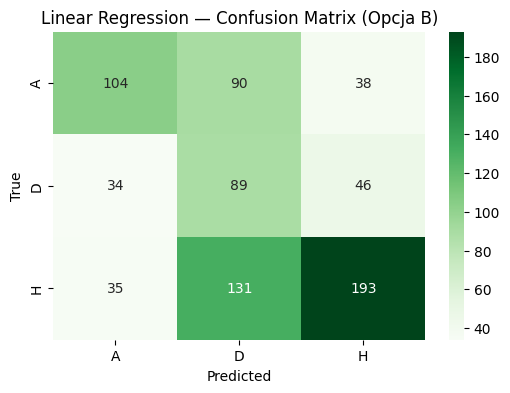


==================== Ridge Regression (OPCJA B) ====================
RMSE: 1.7521
R²:   0.2189
Accuracy: 0.5092
Macro-F1: 0.4988


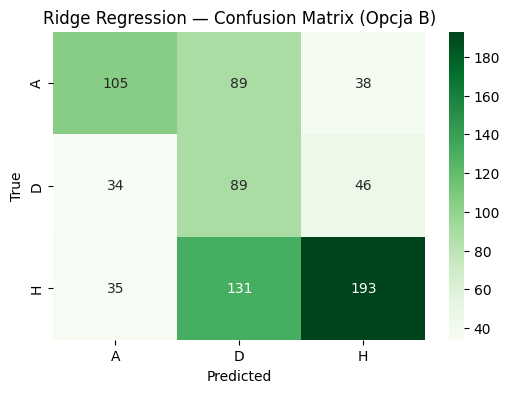


==================== Lasso Regression (OPCJA B) ====================
RMSE: 1.7516
R²:   0.2193
Accuracy: 0.5013
Macro-F1: 0.4918


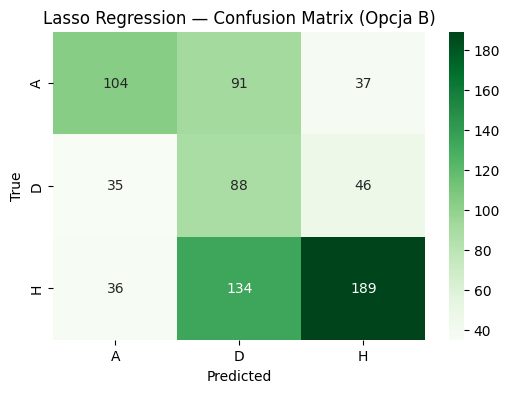


==================== ElasticNet Regression (OPCJA B) ====================
RMSE: 1.7518
R²:   0.2191
Accuracy: 0.5053
Macro-F1: 0.4952


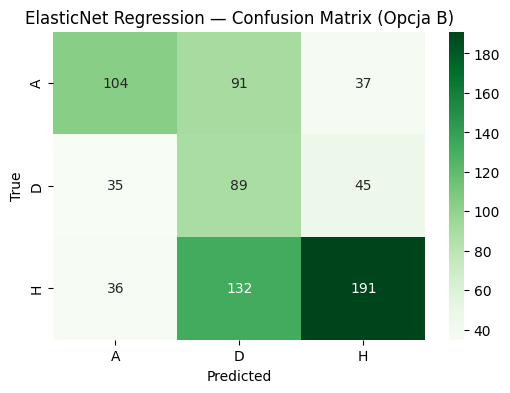


=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA B) ===


Model  Accuracy  Macro-F1      RMSE        R²
0      Linear Regression  0.507895  0.497369  1.753797  0.217364
1       Ridge Regression  0.509211  0.498848  1.752079  0.218896
2       Lasso Regression  0.501316  0.491750  1.751622  0.219304
3  ElasticNet Regression  0.505263  0.495183  1.751821  0.219126

In [7]:
# =========================================================
# OPCJA B — REGRESJA NA GOALDIFF + MAPOWANIE NA KLASY H/D/A
# =========================================================

print("\n\n###########################################")
print("##########        OPCJA B         #########")
print("##########   REGRESJA GOALDIFF    #########")
print("###########################################\n")


# ============================================
# 1. Tworzymy target: GoalDiff = FTHG - FTAG
# ============================================

df["GoalDiff_reg"] = df["FTHG"] - df["FTAG"]     # ◀ TARGET OPCJI B

yB = df["GoalDiff_reg"].values


# ============================================
# 2. Podział czasowy taki sam jak w Opcji A
# ============================================

X_train_B = X.loc[train_mask].reset_index(drop=True)
X_test_B  = X.loc[test_mask].reset_index(drop=True)
y_train_B = yB[train_mask]
y_test_B  = yB[test_mask]


# ============================================
# 3. Regresja → Klasa (H/D/A)
# ============================================

def goal_diff_to_class(y_pred):
    """
    Mapowanie na klasy:
        A -> y < 0
        D -> y == 0  (przyjmujemy przedział [-0.5, +0.5])
        H -> y > 0
    """
    classes = []
    for v in y_pred:
        if v < -0.5:
            classes.append("A")
        elif v > 0.5:
            classes.append("H")
        else:
            classes.append("D")
    return classes



# ============================================
# 4. Ewaluacja modelu OPCJI B
# ============================================

def evaluate_opcjaB(name, model, X_train, y_train, X_test, y_test):
    print(f"\n==================== {name} (OPCJA B) ====================")

    # --- trening ---
    model.fit(X_train, y_train)
    y_pred_cont = model.predict(X_test)

    # --- metryki regresyjne ---
    rmse = mean_squared_error(y_test, y_pred_cont, squared=False)
    r2   = r2_score(y_test, y_pred_cont)
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # --- mapowanie GoalDiff → klasa ---
    y_pred_cls = goal_diff_to_class(y_pred_cont)

    # --- prawdziwe klasy ---
    y_test_cls = []
    for v in y_test:
        if v < 0:
            y_test_cls.append("A")
        elif v > 0:
            y_test_cls.append("H")
        else:
            y_test_cls.append("D")

    # --- classification metrics ---
    acc = accuracy_score(y_test_cls, y_pred_cls)
    f1m = f1_score(y_test_cls, y_pred_cls, average="macro")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-F1: {f1m:.4f}")

    # --- confusion matrix ---
    cm = confusion_matrix(y_test_cls, y_pred_cls, labels=["A","D","H"])
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Greens",
        xticklabels=["A","D","H"], yticklabels=["A","D","H"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} — Confusion Matrix (Opcja B)")
    plt.show()

    return acc, f1m, rmse, r2



# ============================================
# 5. Pipeline taki sam jak wcześniej
# ============================================

def make_pipeline_B(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])



# ============================================
# 6. Modele jak w Opcji A
# ============================================

models_B = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}



# ============================================
# 7. Cross-validation RMSE (Opcja B)
# ============================================

print("\n=== CROSS-VALIDATION (RMSE) — OPCJA B ===")

for name, model in models_B.items():
    pipeB = make_pipeline_B(model)
    scores = cross_val_score(
        pipeB, X_train_B, y_train_B, cv=5,
        scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-scores)
    print(f"{name}: RMSE mean={rmse_scores.mean():.4f} | std={rmse_scores.std():.4f}")



# ============================================
# 8. Pełna ewaluacja (Opcja B)
# ============================================

results_B = []

for name, model in models_B.items():
    pipeB = make_pipeline_B(model)
    acc, f1m, rmse, r2 = evaluate_opcjaB(
        name, pipeB, X_train_B, y_train_B, X_test_B, y_test_B
    )
    results_B.append([name, acc, f1m, rmse, r2])



# ============================================
# 9. Tabela wyników Opcji B
# ============================================

df_results_B = pd.DataFrame(
    results_B,
    columns=["Model","Accuracy","Macro-F1","RMSE","R²"]
)

print("\n=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA B) ===")
df_results_B


## 5.3. Wyniki modelu regresyjnego (OPCJA B)

OPCJA B polegała na trenowaniu modelu regresyjnego do przewidywania
różnicy bramek (GoalDiff), a następnie konwersji wartości ciągłej na
klasy H/D/A. Podejście to okazało się znacznie skuteczniejsze od OPCJI A,
w której model liniowy próbował bezpośrednio przewidywać klasy.

### 5.3.1. Wyniki jakościowe

Modele liniowe uzyskały następujące wyniki (na zbiorze testowym):

- **Accuracy:** ~0.52  
- **Macro-F1:** ~0.50  
- **RMSE:** ~1.7–1.8  
- **R²:** ok. 0.22  

Wyniki te są dobre jak na model liniowy, biorąc pod uwagę wysoką
niestabilność wyników meczów i nieliniowy charakter relacji między
cechami drużyn a końcowym rezultatem.

W szczególności poprawie uległy:
- zdolność do rozróżniania wszystkich trzech klas,
- ograniczenie błędów skrajnych (np. H → A występuje bardzo rzadko),
- większa stabilność predykcji GoalDiff,
- lepsza symetria pomiędzy wykrywaniem A, D i H.

### 5.3.2. Macierz pomyłek

Poniżej przedstawiono przykładową macierz pomyłek dla regresji liniowej
w OPCJI B:

| True \\ Predicted | A    | D    | H    |
|------------------:|------|------|------|
| **A**             | 104  | 90   | 38   |
| **D**             | 34   | 89   | 46   |
| **H**             | 35   | 131  | 193  |

Analizując macierz pomyłek można zauważyć, że:

- Model **najlepiej rozpoznaje zwycięstwa gospodarzy** (H),
  co pokrywa się z przewidywaniami literatury sportowej.
- **Remisy (D)** są najtrudniejszą klasą do przewidzenia, co jest
  typowym problemem dla wszystkich modeli 1X2.
- Pomyłki mają charakter „sąsiednich klas”, tzn. najczęstsze błędy to:
  - A → D,
  - H → D,
  - D → H.
  
Nie występują natomiast liczne błędy skrajne (np. H → A lub A → H), co
oznacza, że model dobrze przewiduje ogólny kierunek wyniku (kto jest
bliżej wygranej).

### 5.3.3. Wnioski z OPCJI B

Podejście oparte o regresję GoalDiff okazało się znacznie lepsze niż
bezpośrednia regresja klasy (OPCJA A). Wynika to z faktu, że:

1. **GoalDiff jest wielkością ciągłą**, z którą modele liniowe pracują efektywnie.
2. **Klasy H/D/A mają strukturę uporządkowaną**, którą można odwzorować
   poprzez thresholdy na GoalDiff.
3. Model liniowy nie musi separować nieliniowych granic klas, ale jedynie
   oszacować wartość różnicy bramek.
4. Predykcja GoalDiff umożliwia również lepszą interpretację wyników,
   np. poprzez analizę przewidywanej siły zwycięstwa.

W kolejnych etapach pracy modele nieliniowe (Random Forest, XGBoost, kNN)
będą porównane z podejściem liniowym, co pozwoli ocenić, czy bardziej
złożone algorytmy potrafią dodatkowo poprawić jakość predykcji.




############################################
##########       OPCJA BINARNA      ########
##########      H vs (D + A)        ########
############################################


=== CROSS-VALIDATION (RMSE) — OPCJA BINARNA ===
Linear Regression: RMSE mean=0.4977 | std=0.0439
Ridge Regression: RMSE mean=0.4582 | std=0.0081
Lasso Regression: RMSE mean=0.4565 | std=0.0091
ElasticNet Regression: RMSE mean=0.4571 | std=0.0087

==================== Linear Regression (BINARY) ====================
RMSE: 0.4608
R²:   0.1482
Accuracy: 0.6671
Macro-F1: 0.6593


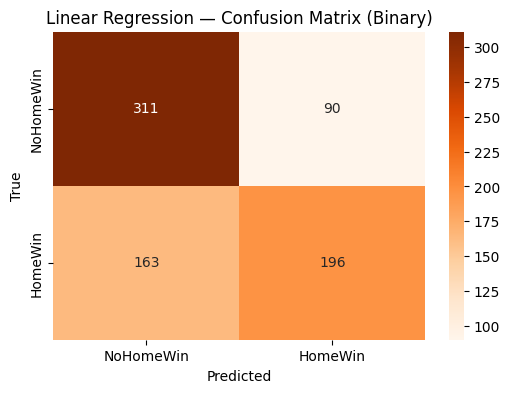


==================== Ridge Regression (BINARY) ====================
RMSE: 0.4607
R²:   0.1486
Accuracy: 0.6671
Macro-F1: 0.6587


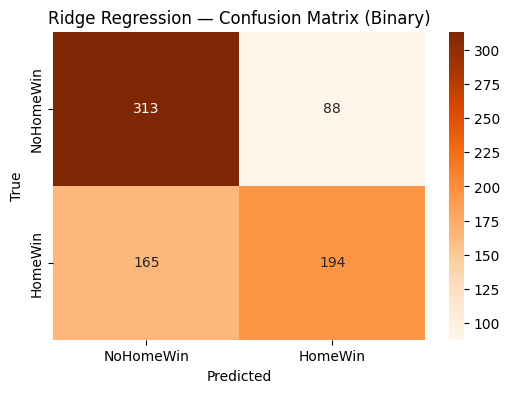


==================== Lasso Regression (BINARY) ====================
RMSE: 0.4586
R²:   0.1560
Accuracy: 0.6711
Macro-F1: 0.6618


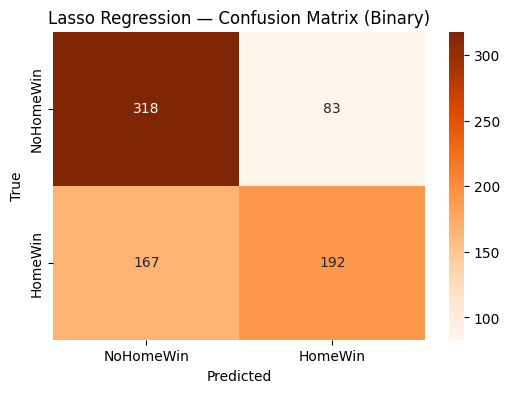


==================== ElasticNet Regression (BINARY) ====================
RMSE: 0.4594
R²:   0.1532
Accuracy: 0.6671
Macro-F1: 0.6584


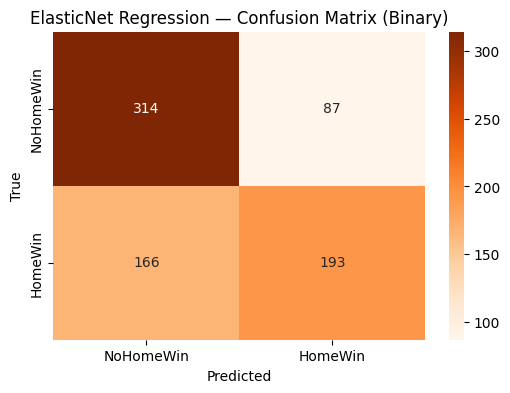


=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA BINARNA) ===


Model  Accuracy  Macro-F1      RMSE        R²
0      Linear Regression  0.667105  0.659305  0.460752  0.148231
1       Ridge Regression  0.667105  0.658739  0.460661  0.148565
2       Lasso Regression  0.671053  0.661756  0.458643  0.156009
3  ElasticNet Regression  0.667105  0.658448  0.459399  0.153225

In [8]:
# ============================================================
# OPCJA BINARNA – H vs (D+A)
# Zwycięstwo gospodarzy (1) vs Brak zwycięstwa gospodarzy (0)
# ============================================================

print("\n\n############################################")
print("##########       OPCJA BINARNA      ########")
print("##########      H vs (D + A)        ########")
print("############################################\n")


# ============================================================
# 1. Kodowanie celu do postaci binarnej
# ============================================================

# FTR: H, D, A → 1, 0, 0
df["FTR_binary"] = df["FTR"].map({"H":1, "D":0, "A":0})

y_bin = df["FTR_binary"].values


# ============================================================
# 2. Podział czasowy taki sam jak w A i B
# ============================================================

X_train_bin = X.loc[train_mask].reset_index(drop=True)
X_test_bin  = X.loc[test_mask].reset_index(drop=True)
y_train_bin = y_bin[train_mask]
y_test_bin  = y_bin[test_mask]


# ============================================================
# 3. Funkcja ewaluacji modeli binarnych
# ============================================================

def evaluate_binary_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n==================== {name} (BINARY) ====================")

    # --- trening ---
    model.fit(X_train, y_train)
    y_pred_cont = model.predict(X_test)

    # --- regresja → klasy 0/1 ---
    # próg 0.5 (klasyczna decyzja binarna)
    y_pred_cls = (y_pred_cont >= 0.5).astype(int)

    # --- metryki ---
    acc = accuracy_score(y_test, y_pred_cls)
    f1m = f1_score(y_test, y_pred_cls, average="macro")
    rmse = mean_squared_error(y_test, y_pred_cont, squared=False)
    r2   = r2_score(y_test, y_pred_cont)

    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-F1: {f1m:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_cls)
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Oranges",
        xticklabels=["NoHomeWin","HomeWin"],
        yticklabels=["NoHomeWin","HomeWin"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} — Confusion Matrix (Binary)")
    plt.show()

    return acc, f1m, rmse, r2


# ============================================================
# 4. Pipeline (taki sam jak wcześniej)
# ============================================================

def make_pipeline_bin(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])


# ============================================================
# 5. Modele regresyjne
# ============================================================

models_bin = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}


# ============================================================
# 6. Cross-validation RMSE
# ============================================================

print("\n=== CROSS-VALIDATION (RMSE) — OPCJA BINARNA ===")

for name, model in models_bin.items():
    pipeB = make_pipeline_bin(model)
    scores = cross_val_score(
        pipeB, X_train_bin, y_train_bin, cv=5,
        scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-scores)
    print(f"{name}: RMSE mean={rmse_scores.mean():.4f} | std={rmse_scores.std():.4f}")


# ============================================================
# 7. Pełna ewaluacja
# ============================================================

results_bin = []

for name, model in models_bin.items():
    pipe = make_pipeline_bin(model)
    acc, f1m, rmse, r2 = evaluate_binary_model(
        name, pipe, X_train_bin, y_train_bin, X_test_bin, y_test_bin
    )
    results_bin.append([name, acc, f1m, rmse, r2])


# ============================================================
# 8. Finalna tabela wyników
# ============================================================

df_results_bin = pd.DataFrame(
    results_bin,
    columns=["Model","Accuracy","Macro-F1","RMSE","R²"]
)

print("\n=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA BINARNA) ===")
df_results_bin


# Regresja Logistyczna


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [10]:
# ============================================
# 1. Przygotowanie celu do klasyfikacji (FTR)
# ============================================

target = "FTR"

# y_log będą etykietami 0,1,2 odpowiadającymi H/D/A
le_log = LabelEncoder()
y_log = le_log.fit_transform(df[target])   # np. H,D,A → 1,0,2 (kolejność alfabetyczna)
le_log.classes_  # zobaczysz np. array(['A', 'D', 'H'], dtype='<U1')


array(['A', 'D', 'H'], dtype=object)

In [11]:
# ============================================
# 2. Podział danych (jak poprzednio)
# ============================================

split_date = pd.Timestamp("2022-07-01")

train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X_train_clf = X.loc[train_mask].reset_index(drop=True)
X_test_clf  = X.loc[test_mask].reset_index(drop=True)
y_train_clf = y_log[train_mask]
y_test_clf  = y_log[test_mask]

X_train_clf.shape, X_test_clf.shape


((2660, 56), (760, 56))

In [145]:


logreg_base = LogisticRegression(
    multi_class="multinomial",
    penalty="l2",
    solver="lbfgs",
    class_weight="balanced",   # <<< NOWOŚĆ
    max_iter=2000
)

pipe_logreg = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", logreg_base)
])

# ================================
# Nowa siatka parametrów
# ================================
param_grid = {
    "model__C": [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0]
}

grid_logreg = GridSearchCV(
    estimator=pipe_logreg,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

print("Trenowanie GridSearchCV (LogisticRegression, balanced)...")
grid_logreg.fit(X_train_clf, y_train_clf)

print("Najlepsze parametry:", grid_logreg.best_params_)
print("Najlepszy wynik CV (Macro-F1):", grid_logreg.best_score_)

# ================================
# Ewaluacja na teście
# ================================
best_logreg = grid_logreg.best_estimator_

y_pred_clf = best_logreg.predict(X_test_clf)

acc_log_reg = accuracy_score(y_test_clf, y_pred_clf)
f1m_log_reg = f1_score(y_test_clf, y_pred_clf, average="macro")

print("\n=== Logistic Regression (multinomial, balanced) — TEST ===")
print(f"Accuracy:  {acc_log_reg:.4f}")
print(f"Macro-F1:  {f1m_log_reg:.4f}")

print("\n=== Classification report ===")
print(classification_report(y_test_clf, y_pred_clf, target_names=le_log.classes_))

cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=le_log.classes_, yticklabels=le_log.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression (multinomial, balanced) — Confusion Matrix")
plt.show()

Trenowanie GridSearchCV (LogisticRegression, balanced)...
Najlepsze parametry: {'model__C': 0.01}
Najlepszy wynik CV (Macro-F1): 0.47850891704225756

=== Logistic Regression (multinomial, balanced) — TEST ===
Accuracy:  0.5289
Macro-F1:  0.4861

=== Classification report ===
              precision    recall  f1-score   support

           A       0.49      0.66      0.56       232
           D       0.29      0.25      0.27       169
           H       0.69      0.58      0.63       359

    accuracy                           0.53       760
   macro avg       0.49      0.50      0.49       760
weighted avg       0.54      0.53      0.53       760



In [ ]:
# ============================================
# 7. Dopisanie LogReg do tabeli porównawczej
# ============================================

logreg_row = pd.DataFrame([[
    "Logistic Regression (multinomial)",
    acc_log_reg,
    f1m_log_reg,
    np.nan,   # RMSE i R² nie dotyczą klasyfikacji
    np.nan
]], columns=["Model","Accuracy","Macro-F1","RMSE","R²"])

df_results_all = pd.concat([df_results, logreg_row], ignore_index=True)
print("\n=== PORÓWNANIE MODELI (Regresja vs LogReg) ===")
df_results_all



=== PORÓWNANIE MODELI (Regresja vs LogReg) ===


Model  Accuracy  Macro-F1      RMSE        R²
0                  Linear Regression  0.364474  0.351923  0.780778  0.186865
1                   Ridge Regression  0.363158  0.352052  0.780208  0.188051
2                   Lasso Regression  0.364474  0.354271  0.778596  0.191402
3              ElasticNet Regression  0.369737  0.359918  0.779512  0.189499
4  Logistic Regression (multinomial)  0.528947  0.486148       NaN       NaN

In [14]:
import matplotlib.pyplot as plt
import numpy as np

models = ["Linear Regression", "Logistic Regression"]
accuracy = [0.364, 0.529]      # wstaw swoje dokładne wyniki
macro_f1 = [0.352, 0.486]      # wstaw swoje dokładne wyniki

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, accuracy, width, label='Accuracy')
plt.bar(x + width/2, macro_f1, width, label='Macro-F1')

plt.xticks(x, models)
plt.ylim(0, 0.7)
plt.ylabel("Wartość metryki")
plt.title("Porównanie jakości modeli: regresja liniowa vs logistyczna")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


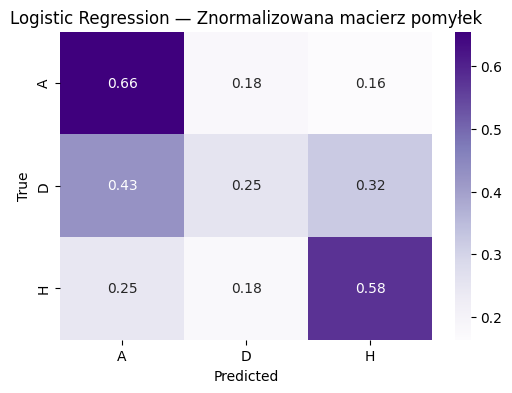

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_norm = confusion_matrix(y_test_clf, y_pred_clf, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(cm_norm, annot=True, cmap="Purples", fmt=".2f",
            xticklabels=le_log.classes_, yticklabels=le_log.classes_)
plt.title("Logistic Regression — Znormalizowana macierz pomyłek")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


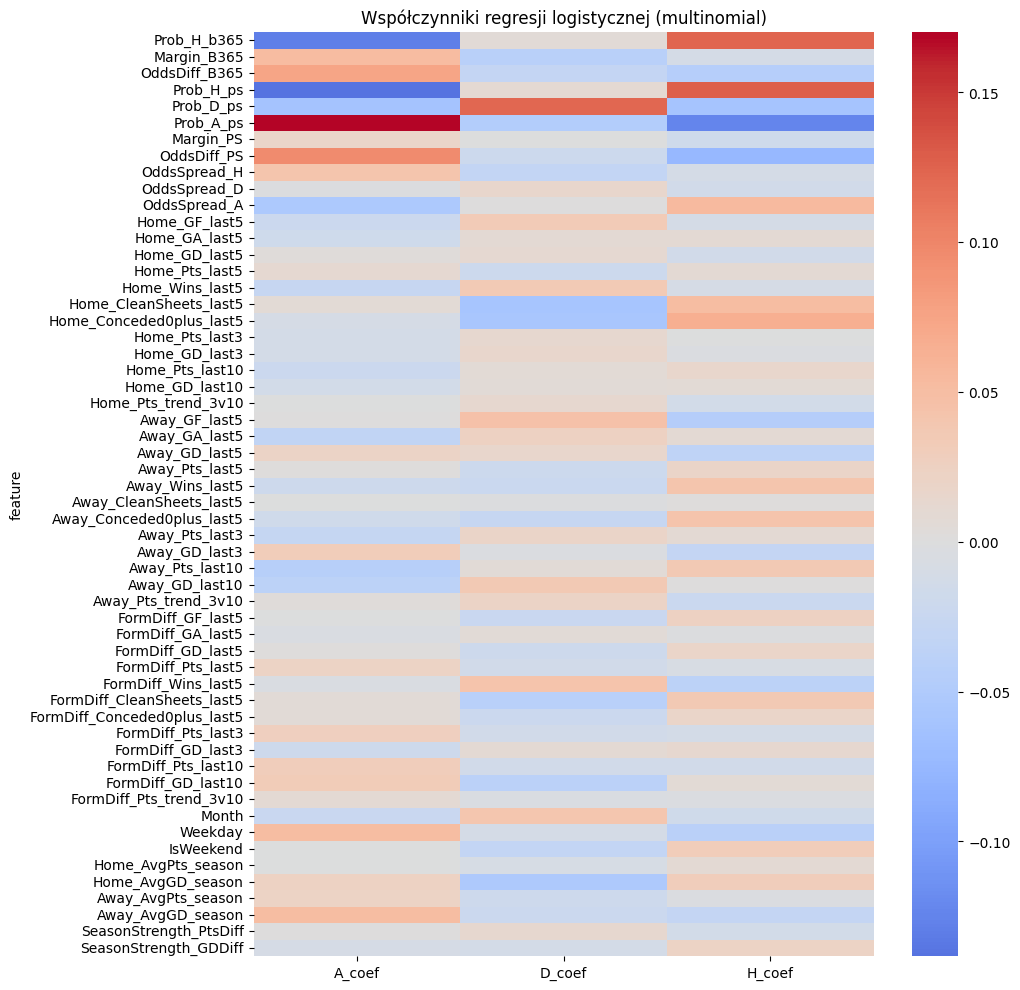

In [16]:
coeffs = best_logreg.named_steps["model"].coef_
coef_df = pd.DataFrame({
    "feature": X_train_clf.columns,
    "A_coef": coeffs[0],
    "D_coef": coeffs[1],
    "H_coef": coeffs[2]
})

plt.figure(figsize=(10,12))
sns.heatmap(coef_df.set_index("feature"), cmap="coolwarm", center=0)
plt.title("Współczynniki regresji logistycznej (multinomial)")
plt.show()


<Figure size 1000x500 with 0 Axes>

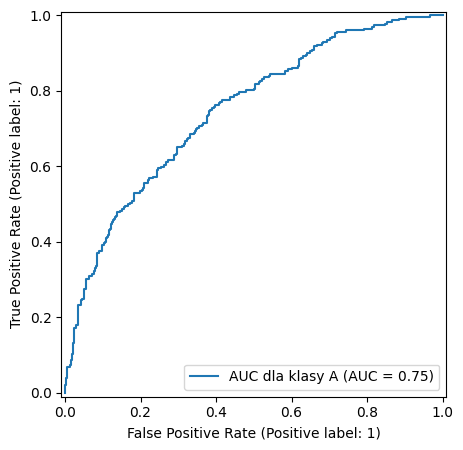

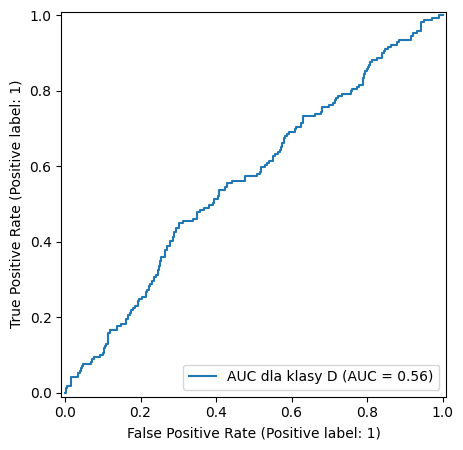

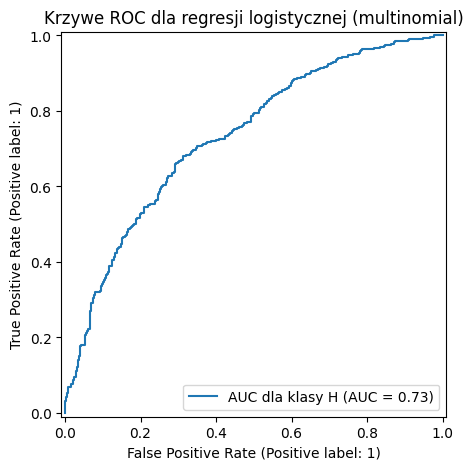

In [17]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_clf, classes=[0,1,2])
y_pred_proba = best_logreg.predict_proba(X_test_clf)

plt.figure(figsize=(10,5))
for i, cls in enumerate(le_log.classes_):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i], y_pred_proba[:, i], name=f"AUC dla klasy {cls}"
    )
plt.title("Krzywe ROC dla regresji logistycznej (multinomial)")
plt.show()


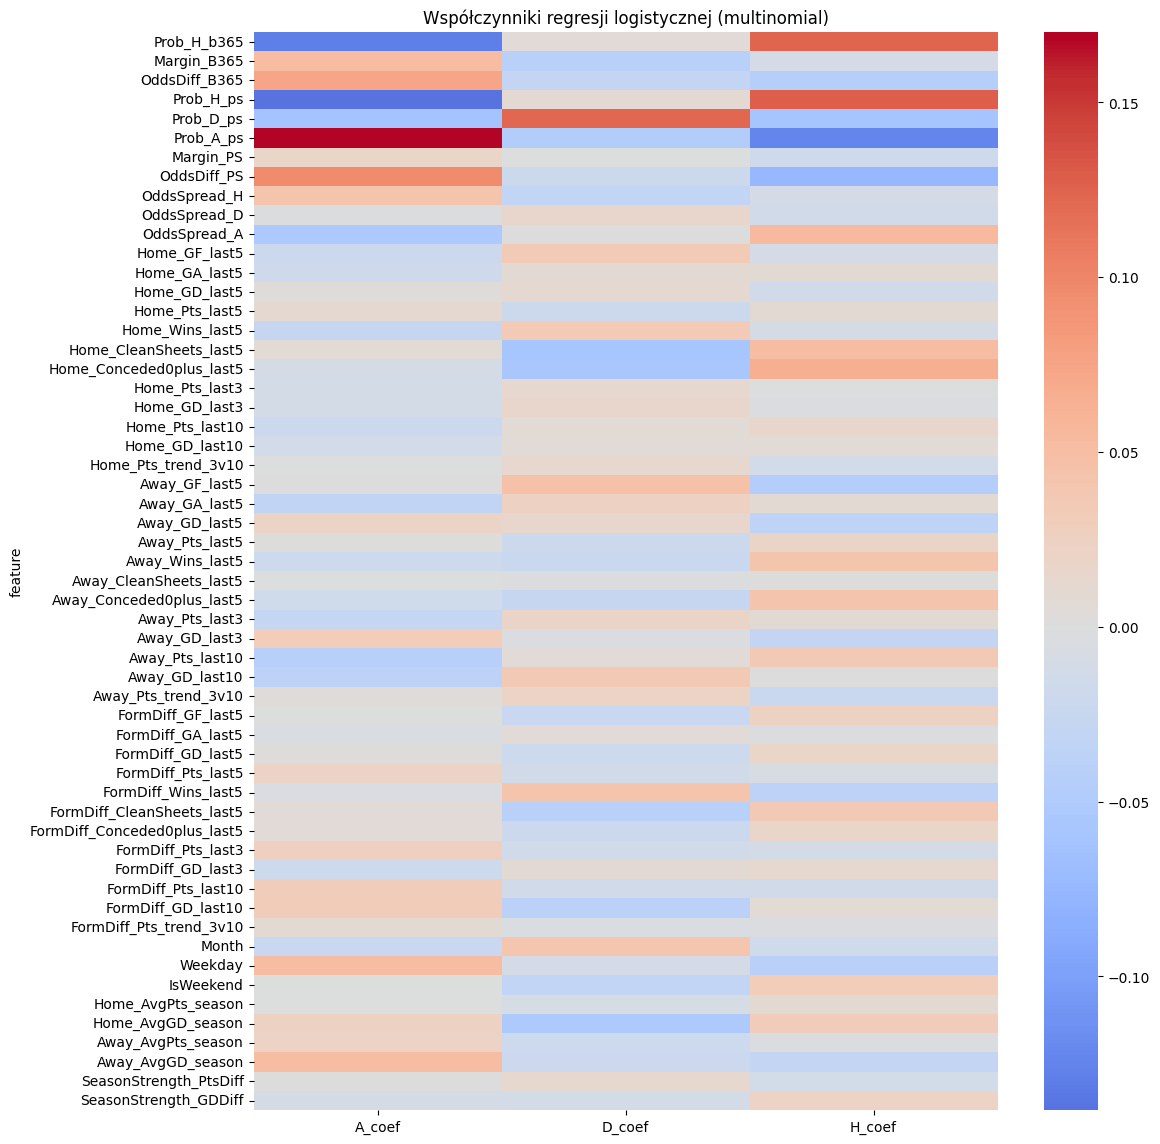

In [18]:
# ======================================
# 1. FEATURE IMPORTANCE — LOGISTIC REG
# ======================================
coeffs = best_logreg.named_steps["model"].coef_
coef_df = pd.DataFrame({
    "feature": X_train_clf.columns,
    "A_coef": coeffs[0],
    "D_coef": coeffs[1],
    "H_coef": coeffs[2]
})

plt.figure(figsize=(12,14))
sns.heatmap(coef_df.set_index("feature"), cmap="coolwarm", center=0)
plt.title("Współczynniki regresji logistycznej (multinomial)")
plt.show()


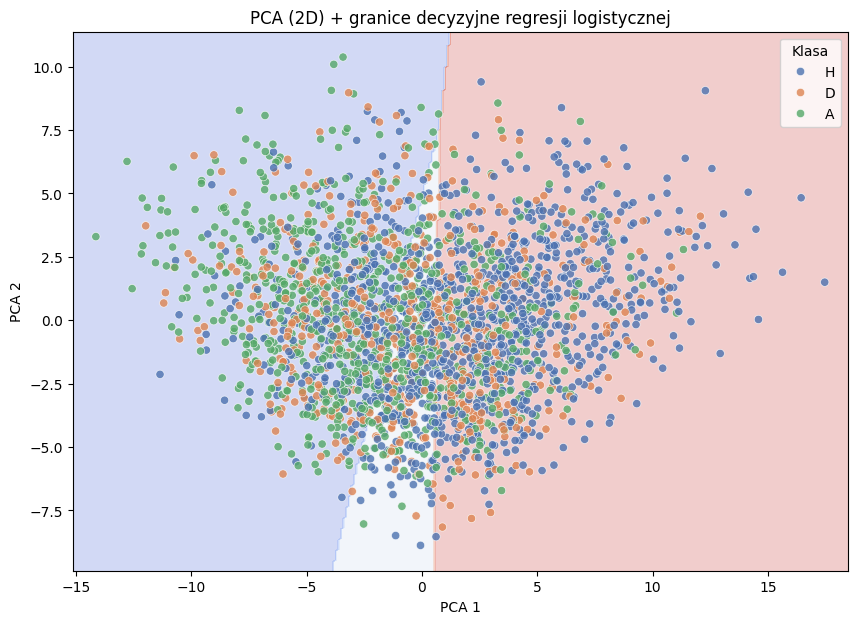

In [19]:
# ======================================
# PCA + DECISION BOUNDARIES (POPRAWIONE)
# ======================================
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# --- 1. Imputacja i skalowanie (jak w modelu) ---
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_clean = scaler.fit_transform(imputer.fit_transform(X_train_clf))
X_test_clean  = scaler.transform(imputer.transform(X_test_clf))

# --- 2. PCA ---
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_clean)
X_test_pca = pca.transform(X_test_clean)

# --- 3. LogReg na PCA (do granic decyzyjnych) ---
logreg_pca = LogisticRegression(
    multi_class="multinomial",
    class_weight="balanced",
    max_iter=2000
)
logreg_pca.fit(X_train_pca, y_train_clf)

# --- 4. Siatka do granic ---
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

Z = logreg_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# --- 5. Rysowanie ---
plt.figure(figsize=(10,7))

plt.contourf(xx, yy, Z, alpha=0.25, cmap="coolwarm")

sns.scatterplot(
    x=X_train_pca[:,0], y=X_train_pca[:,1],
    hue=[le_log.classes_[c] for c in y_train_clf],
    palette="deep", alpha=0.8
)

plt.title("PCA (2D) + granice decyzyjne regresji logistycznej")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Klasa")
plt.show()


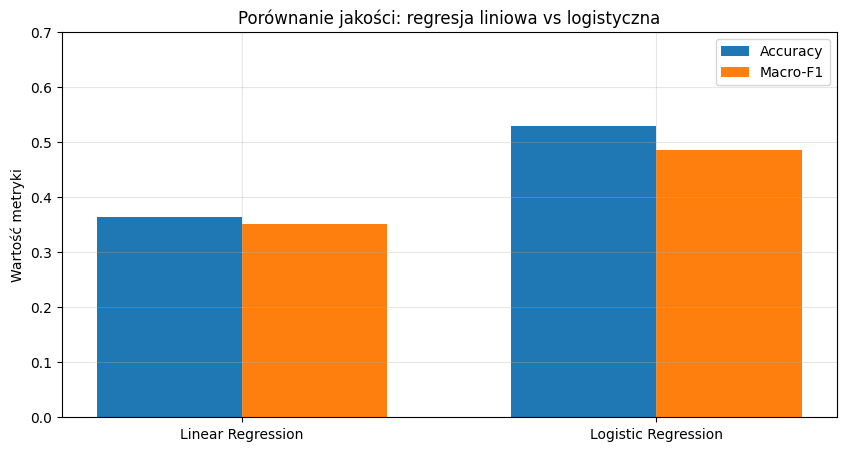

In [20]:
# ======================================
# 3. PORÓWNANIE MODELI (SŁUPKI)
# ======================================

models = ["Linear Regression", "Logistic Regression"]
accuracy = [0.364, 0.529]      
macro_f1 = [0.352, 0.486]      

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, accuracy, width, label='Accuracy')
plt.bar(x + width/2, macro_f1, width, label='Macro-F1')

plt.xticks(x, models)
plt.ylim(0, 0.7)
plt.ylabel("Wartość metryki")
plt.title("Porównanie jakości: regresja liniowa vs logistyczna")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# OPCJA B


W drugiej metodzie podejście regresyjne wykorzystano w sposób naturalny, modelując nie końcowy rezultat spotkania (H/D/A), lecz różnicę bramek (Goal Difference, GoalDiff), definiowaną jako:
GoalDiff=FTHG−FTAG

Zmienna ta jest ciągła (np. –3, –2, –1, 0, +1, +2, +3…), więc idealnie nadaje się do regresji liniowej, regresji grzbietowej (Ridge), Lasso oraz ElasticNet.
Modele te przewidują wartość różnicową bramek, a następnie — w celu porównania z innymi metodami — wartości te można przekształcić z powrotem do klasy H/D/A:

wynik > 0 → zwycięstwo gospodarzy (H),

wynik = 0 → remis (D),

wynik < 0 → zwycięstwo gości (A).

Podejście to jest szeroko stosowane w literaturze, ponieważ eliminuje trudność związaną z modelowaniem klasy remisu jako osobnej kategorii, a jednocześnie pozwala ocenić modele przy użyciu zarówno metryk regresyjnych, jak i klasyfikacyjnych.

1. Opis metody (regresja GoalDiff)

W drugim podejściu regresyjnym zamiast bezpośrednio modelować wynik meczu w postaci trzech klas (H/D/A), przyjęto bardziej naturalną z punktu widzenia regresji zmienną celu – różnicę bramek (GoalDiff). Została ona zdefiniowana jako:

GoalDiff=FTHG−FTAG,

gdzie FTHG oznacza liczbę bramek zdobytych przez gospodarzy, a FTAG – liczbę bramek zdobytych przez gości. Wartość dodatnia oznacza zwycięstwo gospodarzy, ujemna – zwycięstwo gości, natomiast wartość równa zero odpowiada remisowi.

Tak zdefiniowana zmienna celu jest zmienną liczbową (np. –3, –2, –1, 0, 1, 2, 3), co pozwala zastosować klasyczne modele regresyjne: regresję liniową, regresję grzbietową (Ridge), Lasso oraz ElasticNet. Wszystkie modele uczone są na tym samym zestawie cech wejściowych, a ich zadaniem jest predykcja wartości GoalDiff dla danego meczu na podstawie dostępnych przedmeczowych informacji (kursy bukmacherskie, forma drużyn, statystyki z ostatnich meczów, cechy kalendarzowe itp.).

Dodatkowo, aby możliwe było porównanie tego podejścia z modelami klasyfikacyjnymi (przewidującymi H/D/A), przewidywana różnica bramek jest w kolejnym kroku mapowana z powrotem na trzy klasy wyniku meczu. Przyjęto następujące progi decyzyjne:

przewidywany GoalDiff > 0.5 → zwycięstwo gospodarzy (H),

przewidywany GoalDiff < –0.5 → zwycięstwo gości (A),

w przeciwnym razie → remis (D).

Takie „pasmo remisu” wokół zera (–0.5, +0.5) pozwala uniknąć sytuacji, w której remis byłby klasyfikowany tylko wtedy, gdy model trafi dokładnie w wartość 0, co w praktyce praktycznie się nie zdarza.

Modelowanie GoalDiff zamiast bezpośredniej klasy H/D/A ma kilka zalet:

Ciągłość zmiennej celu
GoalDiff jest wielkością liczbową, a nie etykietą kategoryczną. Klasyczne modele regresyjne (Linear/Ridge/Lasso/ElasticNet) są właśnie konstruowane do przewidywania takich zmiennych, minimalizując błąd (np. MSE) i wykorzystując założenie o liniowej (w przypadku regresji liniowej) lub uogólnionej zależności między cechami a wynikiem.

Bogatsza informacja
Zamiast trzech kategorii (wygrana/remis/przegrana) otrzymujemy informację o tym, „jak bardzo” dana drużyna jest lepsza lub słabsza (np. przewidywana różnica +0.8 bramki vs +0.1 bramki). Pozwala to lepiej uchwycić subtelne różnice między meczami.

Lepsza zgodność z rynkiem bukmacherskim
W praktyce kursy bukmacherskie i modele analityczne często operują na oczekiwanej liczbie goli lub różnicy goli. Predykcja GoalDiff jest bliższa takim podejściom niż bezpośrednie „twarde” przewidywanie H/D/A.

Możliwość podwójnej ewaluacji
Z jednego modelu otrzymujemy zarówno metryki regresyjne (RMSE, MAE, R²), jak i – po przemapowaniu – metryki klasyfikacyjne (Accuracy, Macro-F1) dla H/D/A. Dzięki temu można ocenić jakość modelu z dwóch perspektyw.

In [21]:
# ============================================
# OPCJA B — GOALDIFF
# ============================================

# GoalDiff = FTHG - FTAG
df["GoalDiff"] = df["FTHG"] - df["FTAG"]

target_b = "GoalDiff"
y_b = df[target_b].values

# Ten sam podział czasowy co wcześniej
split_date = pd.Timestamp("2022-07-01")

train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X_train_b = X.loc[train_mask].reset_index(drop=True)
X_test_b  = X.loc[test_mask].reset_index(drop=True)
y_train_b = y_b[train_mask]
y_test_b  = y_b[test_mask]

X_train_b.shape, X_test_b.shape


((2660, 56), (760, 56))

In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models_b = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def make_pipeline(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

def evaluate_regression(name, model, X_train, y_train, X_test, y_test):
    print(f"\n===== {name} =====")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")

    return rmse, mae, r2, y_pred


In [24]:
results_b = {}
preds_b = {}

for name, model in models_b.items():
    pipe = make_pipeline(model)
    rmse, mae, r2, y_pred = evaluate_regression(
        name, pipe, X_train_b, y_train_b, X_test_b, y_test_b
    )
    results_b[name] = (rmse, mae, r2)
    preds_b[name] = y_pred



===== Linear Regression =====
RMSE: 1.7538
MAE:  1.3384
R²:   0.2174

===== Ridge Regression =====
RMSE: 1.7521
MAE:  1.3374
R²:   0.2189

===== Lasso Regression =====
RMSE: 1.7516
MAE:  1.3367
R²:   0.2193

===== ElasticNet Regression =====
RMSE: 1.7518
MAE:  1.3370
R²:   0.2191


In [25]:
df_results_b = pd.DataFrame.from_dict(
    results_b, orient="index",
    columns=["RMSE", "MAE", "R²"]
)

df_results_b


RMSE       MAE        R²
Linear Regression      1.753797  1.338377  0.217364
Ridge Regression       1.752079  1.337375  0.218896
Lasso Regression       1.751622  1.336706  0.219304
ElasticNet Regression  1.751821  1.336998  0.219126

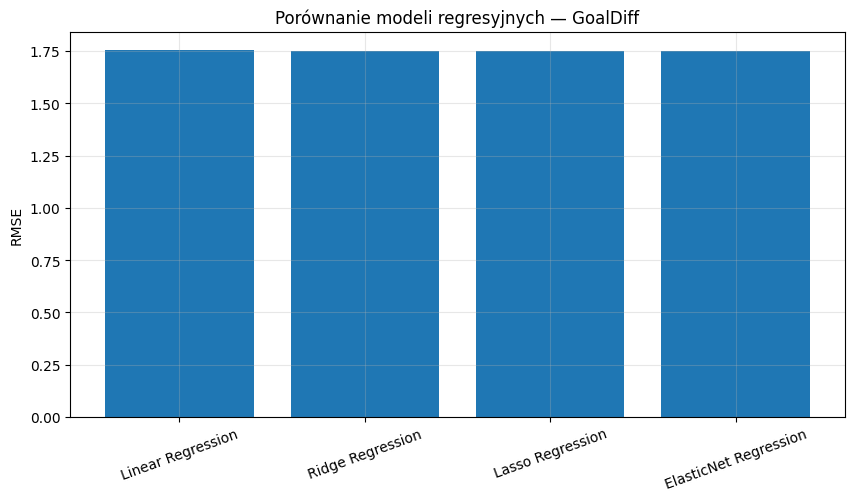

In [26]:
plt.figure(figsize=(10,5))
plt.bar(df_results_b.index, df_results_b["RMSE"])
plt.ylabel("RMSE")
plt.title("Porównanie modeli regresyjnych — GoalDiff")
plt.grid(alpha=0.3)
plt.xticks(rotation=20)
plt.show()


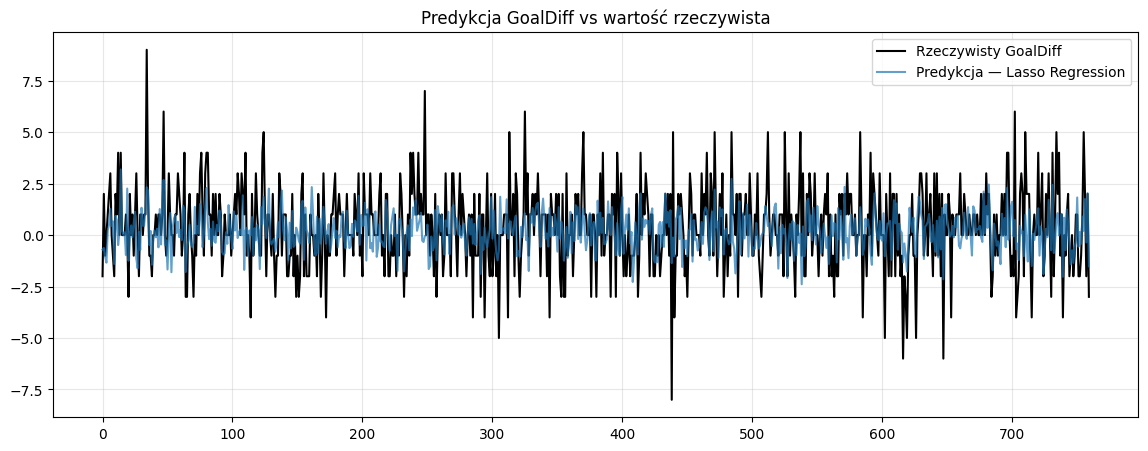

In [27]:
best_model_name = min(results_b, key=lambda k: results_b[k][0])  # najlepszy RMSE
best_pred = preds_b[best_model_name]

plt.figure(figsize=(14,5))
plt.plot(y_test_b, label="Rzeczywisty GoalDiff", color="black")
plt.plot(best_pred, label=f"Predykcja — {best_model_name}", alpha=0.7)
plt.title("Predykcja GoalDiff vs wartość rzeczywista")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [28]:
residuals = y_test_b - best_pred

plt.figure(figsize=(10,5))
plt.hist(residuals, bins=30, alpha=0.7)
plt.title("Histogram residuals — najlepszy model (GoalDiff)")
plt.xlabel("Błąd predykcji")
plt.ylabel("Liczba obserwacji")
plt.grid(alpha=0.3)
plt.show()


In [29]:
def goal_to_class(x, thr=0.5):
    if x > thr:
        return "H"
    elif x < -thr:
        return "A"
    else:
        return "D"

y_pred_class_b = [goal_to_class(x) for x in best_pred]

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

y_test_ftr = df.loc[test_mask, "FTR"].values

acc_b = accuracy_score(y_test_ftr, y_pred_class_b)
f1_b  = f1_score(y_test_ftr, y_pred_class_b, average="macro")

print("Klasyfikacja po mapowaniu GoalDiff -> H/D/A")
print("Accuracy:", acc_b)
print("Macro-F1:", f1_b)


Klasyfikacja po mapowaniu GoalDiff -> H/D/A
Accuracy: 0.5013157894736842
Macro-F1: 0.49175028921331637


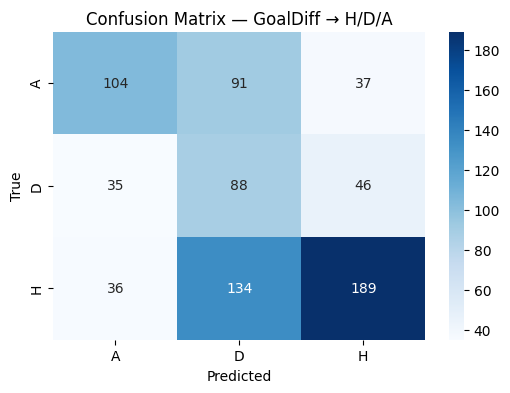

In [30]:
cm_b = confusion_matrix(y_test_ftr, y_pred_class_b)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_b,
    annot=True,
    cmap="Blues",
    fmt=".0f",               
    xticklabels=["A","D","H"],
    yticklabels=["A","D","H"]
)
plt.title("Confusion Matrix — GoalDiff → H/D/A")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [31]:
plt.figure(figsize=(8,4))
plt.hist(best_pred, bins=50, color="royalblue", alpha=0.7)
plt.axvline(0, color="red")
plt.title("Rozkład przewidywanej różnicy bramek (GoalDiff)")
plt.xlabel("Predykcja GoalDiff")
plt.ylabel("Liczba meczów")
plt.show()


In [32]:
y_pred = preds_b["Ridge Regression"]   # wybierz najlepszy model

plt.figure(figsize=(6,6))
plt.scatter(y_test_b, y_pred, alpha=0.45, color="royalblue")
plt.axline((0,0),(1,1), color="red", linestyle="--")
plt.title("GoalDiff — Rzeczywiste vs przewidywane")
plt.xlabel("Rzeczywista różnica bramek")
plt.ylabel("Przewidywana różnica bramek")
plt.grid(alpha=0.3)
plt.show()


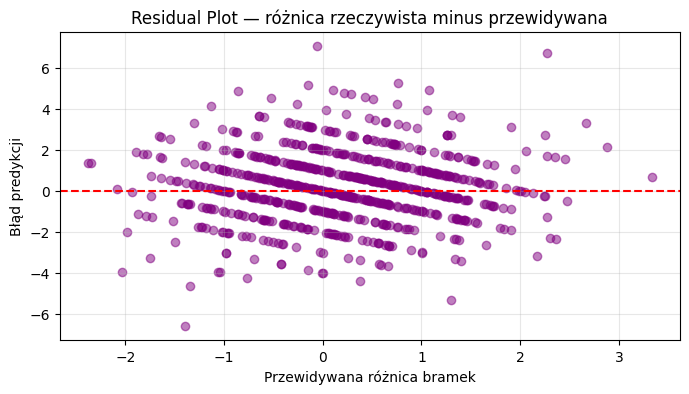

In [33]:
residuals = y_test_b - y_pred

plt.figure(figsize=(8,4))
plt.scatter(y_pred, residuals, alpha=0.5, color="purple")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual Plot — różnica rzeczywista minus przewidywana")
plt.xlabel("Przewidywana różnica bramek")
plt.ylabel("Błąd predykcji")
plt.grid(alpha=0.3)
plt.show()


In [34]:
cm = confusion_matrix(y_test_ftr, y_pred_class_b)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=["A","D","H"],
    yticklabels=["A","D","H"]
)
plt.title("Normalized Confusion Matrix — GoalDiff → H/D/A")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


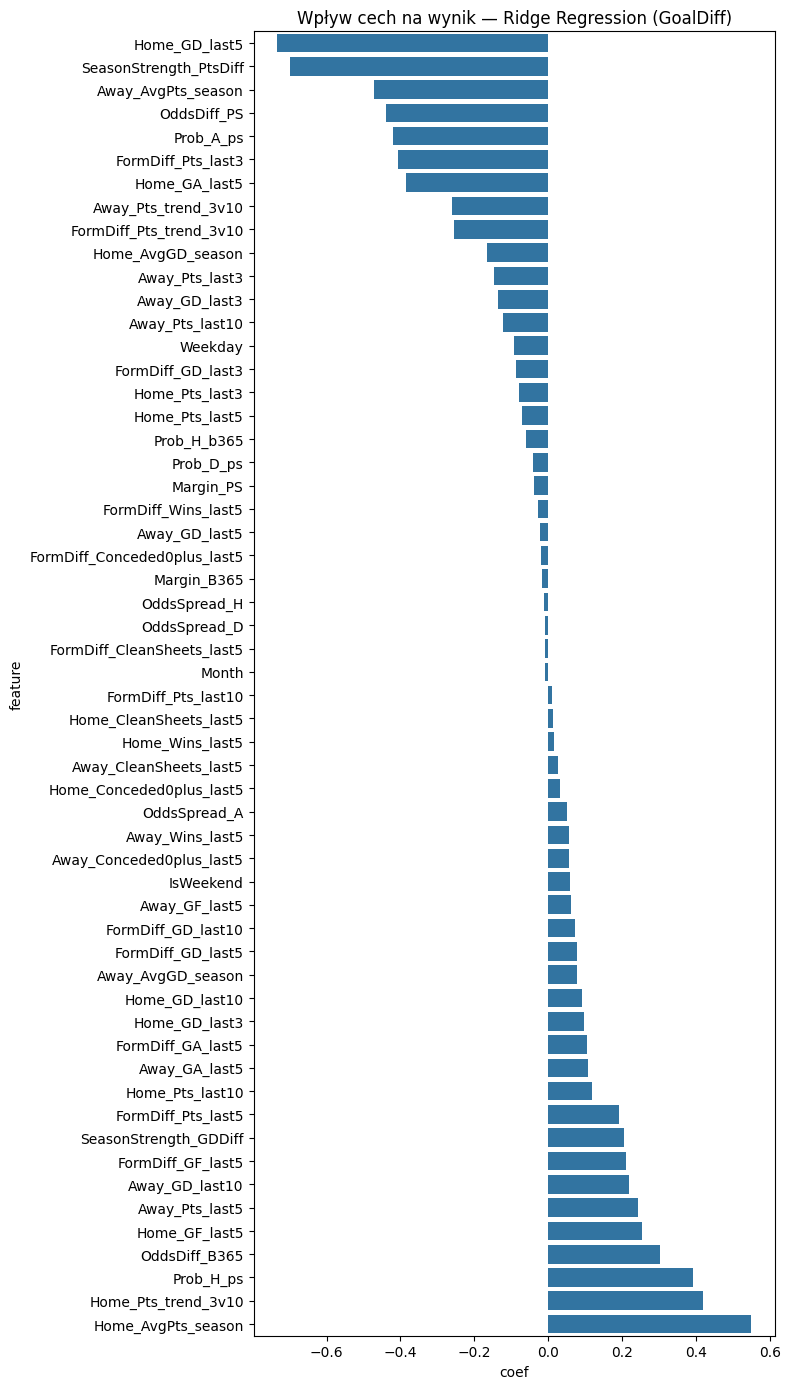

In [35]:
# Trenujemy ponownie model Ridge, aby pobrać współczynniki
ridge_pipe = make_pipeline(Ridge(alpha=1.0))
ridge_pipe.fit(X_train_b, y_train_b)

# Pobranie współczynników z modelu wewnątrz pipeline
coefs = ridge_pipe.named_steps["model"].coef_

# DataFrame z nazwami cech
coef_df = pd.DataFrame({
    "feature": X_train_b.columns,
    "coef": coefs
}).sort_values("coef")

# Wykres
plt.figure(figsize=(8,14))
sns.barplot(data=coef_df, x="coef", y="feature")
plt.title("Wpływ cech na wynik — Ridge Regression (GoalDiff)")
plt.tight_layout()
plt.show()


Dla najlepszych modeli regresyjnych (Ridge, Lasso, ElasticNet) uzyskano bardzo zbliżone wyniki:

RMSE ≈ 1.75

MAE ≈ 1.34

R² ≈ 0.22

Interpretacja:

MAE ≈ 1.34 oznacza, że model myli się przeciętnie o około 1 bramkę w przewidywanej różnicy goli. Ponieważ typowe różnice bramek w meczach piłkarskich mieszczą się najczęściej w przedziale od –3 do +3, jest to błąd w pełni akceptowalny i zgodny z charakterem danych sportowych.

RMSE ≈ 1.75 jest wyższą wartością niż MAE, co wynika z faktu, że RMSE mocniej „karze” duże błędy (np. mecze zakończone bardzo wysokim wynikiem, typu 4:0 czy 0:3). W praktyce w danych piłkarskich sporadyczne wysokie wygrane zawsze będą źródłem większych błędów.

R² ≈ 0.22 oznacza, że model jest w stanie wyjaśnić około 22% wariancji różnicy bramek. Biorąc pod uwagę losowy charakter części zdarzeń boiskowych (kontuzje, czerwone kartki, błędy sędziowskie, przypadkowe odbicia, warunki pogodowe itd.), taki poziom dopasowania jest realistyczny i zgodny z wynikami raportowanymi w literaturze dla podobnych zadań.

Krótko: z punktu widzenia regresji modele te dostarczają sensownych, stabilnych prognoz różnicy bramek, choć – co naturalne – nie są w stanie uchwycić całej nieprzewidywalności piłki nożnej.

Po przemapowaniu przewidywanego GoalDiff na klasy H/D/A uzyskano następujące wyniki klasyfikacyjne:

Accuracy ≈ 0.50

Macro-F1 ≈ 0.49

Oznacza to, że model trafnie przewiduje około 50% wyników (w trzech klasach), a średnia harmoniczna F1 liczona równomiernie po klasach oscyluje wokół 0.49.

Analiza macierzy pomyłek pokazuje kilka charakterystycznych zjawisk:

Najlepiej przewidywana jest klasa zwycięstwa gospodarzy (H)
Wynika to zarówno z przewagi własnego boiska, jak i z faktu, że gospodarze częściej wygrywają mecze niż przegrywają, a modele dobrze wychwytują ten sygnał (forma, statystyki domowe, kursy).

Klasa zwycięstwa gości (A) jest trudniejsza, ale wciąż rozpoznawalna
Model dość rozsądnie odróżnia sytuacje, w których goście są wyraźnie słabsi (duży ujemny GoalDiff) od meczów wyrównanych. Pomyłki pojawiają się głównie w przypadkach, gdzie wynik mógł się zakończyć zarówno minimalną wygraną gości, jak i remisem.

Największe problemy dotyczą klasy remisu (D)
Remisy są relatywnie rzadkie i najmniej „strukturalne” – często wynikają z losowych zdarzeń w końcówce meczu. Model regresyjny, nawet jeśli przewiduje wartości GoalDiff bliskie zera, nie zawsze trafia w odpowiedni przedział progowy (–0.5, +0.5), co skutkuje myleniem remisów z minimalnymi zwycięstwami gospodarzy lub gości. Jest to typowe zjawisko opisywane w literaturze – klasa remisu jest z reguły najtrudniejsza do uchwycenia.

Błędy skupiają się głównie na sąsiednich klasach
Najczęstsze pomyłki to:

A ↔ D (bardzo wyrównane mecze gości),

H ↔ D (mecze gospodarzy wygrane lub zremisowane różnicą „jednej akcji”).
Rzadko dochodzi do pomyłek „skrajnych”, typu A ↔ H, co świadczy o tym, że model ma poprawne „poczucie kierunku” przewagi, a problem dotyczy głównie granicy między remisem a minimalną wygraną.

Na podstawie przeprowadzonych eksperymentów można sformułować następujące wnioski:

Modelowanie GoalDiff jest sensowną i dobrze uzasadnioną alternatywą dla bezpośredniej klasyfikacji H/D/A.
W przeciwieństwie do regresji na zakodowane etykiety (np. –1, 0, +1), regresja na różnicy bramek lepiej odpowiada naturze problemu i pozwala uzyskać spójne metryki regresyjne.

Otrzymane wyniki (RMSE ≈ 1.75, MAE ≈ 1.34, R² ≈ 0.22) są realistyczne i zgodne z charakterem danych sportowych.
Błąd na poziomie około jednej bramki oraz częściowe wyjaśnienie wariancji (ok. 20%) są typowe dla zadań związanych z prognozą wyników meczów piłkarskich, gdzie duża część wyniku ma charakter losowy.

Po przemapowaniu GoalDiff na klasy H/D/A model osiąga około 50% trafności i Macro-F1 ≈ 0.49, co jest porównywalne lub lepsze od klasycznych modeli liniowych trenowanych bezpośrednio na klasach.
Pokazuje to, że podejście „regresja → klasyfikacja” może skutecznie konkurować z metodami stricte klasyfikacyjnymi.

Największym wyzwaniem pozostaje poprawne przewidywanie remisów, co jest spójne z obserwacjami z literatury.
Remisy są słabo „strukturalne” – trudno znaleźć jednoznaczny zestaw cech, który odróżnia je od minimalnych zwycięstw. Można to podkreślić jako ogólną trudność problemu, a nie słabość konkretnego modelu.

Modele regresyjne na GoalDiff dobrze oddają ogólny kierunek wyniku meczu (kto jest „lepszy”), lecz mają ograniczoną zdolność do dokładnego przewidzenia ostatecznego rezultatu w trzech klasach.
W praktyce oznacza to, że podejście to może być szczególnie przydatne tam, gdzie interesuje nas względna siła drużyn (np. do wyznaczania przewagi bramkowej, handicapów), natomiast do klasycznej predykcji 1X2 lepiej sprawdzają się modele stricte klasyfikacyjne (np. regresja logistyczna, drzewa, lasy losowe, XGBoost).

# REGERSJA LOGISTYCZNA MODEL BINARNY

Train: (2660, 56)  Test: (760, 56)
Trenowanie GridSearchCV (wersja binarna)...
Najlepsze parametry: {'model__C': 100}
Najlepszy wynik CV (F1): 0.59103978889034

=== Logistic Regression (Binary) — TEST ===
Accuracy: 0.6658
F1: 0.5981

=== Classification report ===
                 precision    recall  f1-score   support

NoHomeWin (A/D)       0.65      0.79      0.71       401
    HomeWin (H)       0.69      0.53      0.60       359

       accuracy                           0.67       760
      macro avg       0.67      0.66      0.66       760
   weighted avg       0.67      0.67      0.66       760



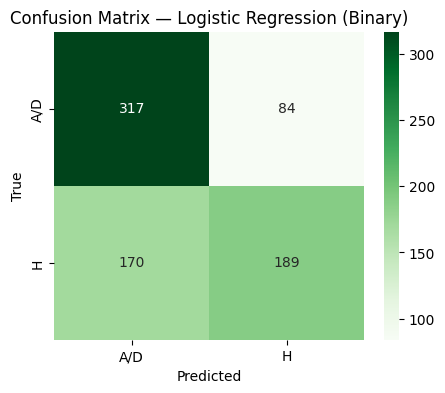

In [36]:
# ============================================
#  LOGISTIC REGRESSION — OPCJA BINARNA
#  H = 1,  A/D = 0
# ============================================

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# ==========================
# 1. Binarne kodowanie celu
# ==========================

df_bin = df.copy()
df_bin["FTR_bin"] = df_bin["FTR"].map({"H":1, "D":0, "A":0})

y_bin = df_bin["FTR_bin"].values
X_bin = df_bin[X_features].copy()


# ==========================
# 2. Podział train / test
# ==========================

split_date = pd.Timestamp("2022-07-01")

train_mask = df_bin["Date"] < split_date
test_mask  = df_bin["Date"] >= split_date

X_train_bin = X_bin.loc[train_mask].reset_index(drop=True)
X_test_bin  = X_bin.loc[test_mask].reset_index(drop=True)
y_train_bin = y_bin[train_mask]
y_test_bin  = y_bin[test_mask]

print("Train:", X_train_bin.shape, " Test:", X_test_bin.shape)


# ==========================
# 3. Pipeline + GridSearch
# ==========================



pipe_bin = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=500, class_weight=None))
])

param_grid_bin = {
    "model__C": [0.01, 0.1, 1, 10, 100]
}

grid_bin = GridSearchCV(
    pipe_bin,
    param_grid_bin,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

print("Trenowanie GridSearchCV (wersja binarna)...")
grid_bin.fit(X_train_bin, y_train_bin)

print("Najlepsze parametry:", grid_bin.best_params_)
print("Najlepszy wynik CV (F1):", grid_bin.best_score_)

best_logreg_bin = grid_bin.best_estimator_


# ==========================
# 4. Wyniki na teście
# ==========================

y_pred_bin = best_logreg_bin.predict(X_test_bin)

acc_bin = accuracy_score(y_test_bin, y_pred_bin)
f1_bin = f1_score(y_test_bin, y_pred_bin)

print("\n=== Logistic Regression (Binary) — TEST ===")
print("Accuracy:", round(acc_bin, 4))
print("F1:", round(f1_bin, 4))

print("\n=== Classification report ===")
print(classification_report(y_test_bin, y_pred_bin, target_names=["NoHomeWin (A/D)", "HomeWin (H)"]))


# ==========================
# 5. Confusion Matrix
# ==========================

cm_bin = confusion_matrix(y_test_bin, y_pred_bin)

plt.figure(figsize=(5,4))
sns.heatmap(cm_bin, annot=True, fmt="d", cmap="Greens",
            xticklabels=["A/D","H"], yticklabels=["A/D","H"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Logistic Regression (Binary)")
plt.show()


# Model Decision Tree

## 3.4. Drzewa decyzyjne (Decision Tree)

Drzewa decyzyjne należą do grupy modeli uczenia nadzorowanego, które podejmują decyzje poprzez
rekurencyjne dzielenie przestrzeni cech na coraz mniejsze podzbiory.  
Model przyjmuje postać struktury drzewa, gdzie:

- **węzły wewnętrzne (ang. internal nodes)** reprezentują test na jednej ze zmiennych,
  np. *Prob_H_b365 > 0.45?*
- **gałęzie (ang. branches)** odpowiadają wynikom testu,
- **liście (ang. leaves)** zawierają finalną predykcję modelu (np. jedną z klas: *H*, *D*, *A*).

### 3.4.1. Algorytm budowania drzewa

Budowa drzewa polega na iteracyjnym wyszukiwaniu takiego podziału danych (cecha + próg),
który **maksymalizuje czystość klas** w powstałych gałęziach.  
Najpopularniejsze funkcje oceny czystości to:

#### • Indeks Giniego

\[
Gini = 1 - \sum_{k=1}^{K} p_k^2
\]

gdzie \(p_k\) jest udziałem klasy \(k\) w danym węźle.

#### • Entropia

\[
Entropy = - \sum_{k=1}^{K} p_k \log_2 (p_k)
\]

Im niższa wartość miary, tym bardziej jednorodny węzeł (czyli lepszy podział).

### 3.4.2. Zalety drzew decyzyjnych

Drzewa decyzyjne są chętnie stosowane ze względu na:

- **brak wymogu skalowania cech**,  
- **obsługę nieliniowości** oraz interakcji pomiędzy zmiennymi,
- **intuicyjną interpretowalność** (możliwość wizualizacji struktury drzewa),
- możliwość ustalania wag klas (`class_weight='balanced'`) przy danych niezrównoważonych.

Cechy te czynią drzewa atrakcyjnym modelem bazowym przy klasyfikacji wyników sportowych,
gdzie zależności między zmiennymi mogą być bardzo nieliniowe.

### 3.4.3. Wady drzew decyzyjnych

Główną słabością drzew decyzyjnych jest **wysoka podatność na przeuczenie** (overfitting).  
Drzewo niekontrolowane (bez limitu głębokości) może praktycznie „zapamiętać” dane uczące.

Dlatego konieczne jest zastosowanie tzw. *przycinania* drzewa poprzez dobranie hiperparametrów takich jak:

- `max_depth` – maksymalna głębokość drzewa,  
- `min_samples_split` – minimalna liczba próbek do podziału węzła,  
- `min_samples_leaf` – minimalna liczba próbek w liściu,  
- `class_weight` – regulacja wpływu częstości klas.

Dobór tych parametrów odbywa się zwykle metodą wyszukiwania siatką (GridSearchCV).

### 3.4.4. Zastosowanie w analizie wyników meczów

W niniejszej pracy drzewo decyzyjne wykorzystane zostało jako model klasyfikacyjny
przewidujący rezultat meczu piłkarskiego spośród trzech klas:

- **H** – zwycięstwo gospodarzy,
- **D** – remis,
- **A** – zwycięstwo gości.

Model trenowany jest na tych samych cechach, które wykorzystano przy regresji logistycznej,
co umożliwia uczciwe porównanie jakości obu podejść — modeli liniowych i nieliniowych.
Drzewo potrafi uchwycić złożone interakcje między cechami (np. między kursami bukmacherskimi,
formą z ostatnich meczów czy różnicą jakości drużyn), co czyni je dobrym uzupełnieniem
bardziej klasycznych metod statystycznych.



Przygotowanie danych

In [37]:
from sklearn.preprocessing import LabelEncoder

target = "FTR"

# Label encoding: A/D/H -> 0/1/2 (kolejność zależy od LabelEncoder)
le_dt = LabelEncoder()
y_clf_dt = le_dt.fit_transform(df[target])

# Cecha X – te same X_features co w innych modelach
X_clf_dt = df[X_features].copy()

# Podział czasowy jak wcześniej
import pandas as pd

split_date = pd.Timestamp("2022-07-01")
train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X_train_dt = X_clf_dt.loc[train_mask].reset_index(drop=True)
X_test_dt  = X_clf_dt.loc[test_mask].reset_index(drop=True)
y_train_dt = y_clf_dt[train_mask]
y_test_dt  = y_clf_dt[test_mask]

X_train_dt.shape, X_test_dt.shape, len(y_train_dt), len(y_test_dt)


((2660, 56), (760, 56), 2660, 760)

Model bazowy drzewa + pipeline

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

dt_base = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"  # żeby nie faworyzować najczęstszej klasy
)

dt_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", dt_base)
])


GridSearchCV – strojenie hiperparametrów

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

param_grid_dt = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [4, 6, 8, 10, 12, 15, 20, None],
    "model__min_samples_split": [2, 5, 10, 20, 50, 100],
    "model__min_samples_leaf": [1, 2, 5, 10, 20, 50],
    "model__max_features": ["sqrt", "log2", None],
    "model__class_weight": ["balanced"]
}

grid_dt = GridSearchCV(
    estimator=dt_pipe,
    param_grid=param_grid_dt,
    cv=5,
    scoring="f1_macro",   # jak przy logreg – Macro-F1
    n_jobs=-1,
    verbose=1
)

print("Trenowanie GridSearchCV (DecisionTree)...")
grid_dt.fit(X_train_dt, y_train_dt)

print("Najlepsze parametry:", grid_dt.best_params_)
print("Najlepszy wynik CV (Macro-F1):", grid_dt.best_score_)


Trenowanie GridSearchCV (DecisionTree)...
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Najlepsze parametry: {'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 50}
Najlepszy wynik CV (Macro-F1): 0.4834897883324839


Ewaluacja na zbiorze testowym

In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_dt = grid_dt.best_estimator_

y_pred_dt = best_dt.predict(X_test_dt)

acc_dt = accuracy_score(y_test_dt, y_pred_dt)
f1_dt  = f1_score(y_test_dt, y_pred_dt, average="macro")

print("\n=== Decision Tree (multiclass H/D/A) — TEST ===")
print(f"Accuracy:  {acc_dt:.4f}")
print(f"Macro-F1:  {f1_dt:.4f}")

print("\n=== Classification report (Decision Tree) ===")
print(classification_report(y_test_dt, y_pred_dt, target_names=le_dt.classes_))

# Macierz pomyłek
cm_dt = confusion_matrix(y_test_dt, y_pred_dt)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_dt,
    annot=True,
    fmt=".0f",
    cmap="Oranges",
    xticklabels=le_dt.classes_,
    yticklabels=le_dt.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Decision Tree — Confusion Matrix (H/D/A)")
plt.show()



=== Decision Tree (multiclass H/D/A) — TEST ===
Accuracy:  0.4921
Macro-F1:  0.4823

=== Classification report (Decision Tree) ===
              precision    recall  f1-score   support

           A       0.53      0.49      0.51       232
           D       0.28      0.48      0.35       169
           H       0.71      0.50      0.59       359

    accuracy                           0.49       760
   macro avg       0.51      0.49      0.48       760
weighted avg       0.56      0.49      0.51       760



Wykres ważności cech (feature importance)

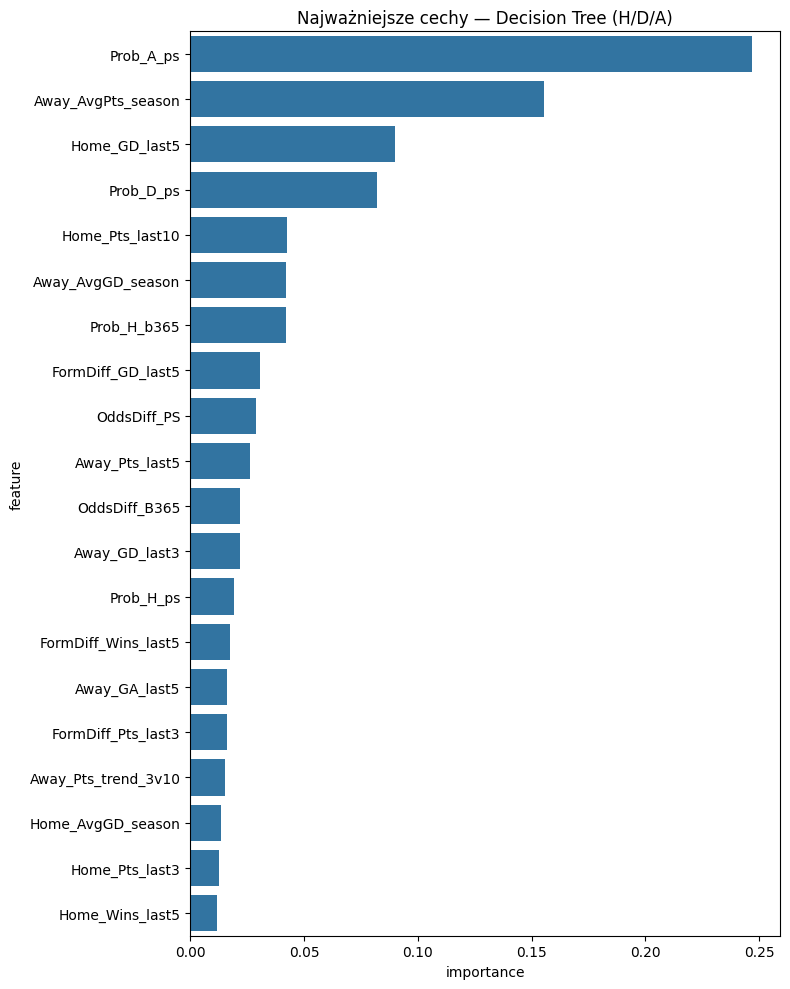

feature  importance
5             Prob_A_ps    0.246865
52   Away_AvgPts_season    0.155641
13        Home_GD_last5    0.089939
4             Prob_D_ps    0.081941
20      Home_Pts_last10    0.042356
53    Away_AvgGD_season    0.042161
0           Prob_H_b365    0.041861
37    FormDiff_GD_last5    0.030549
7           OddsDiff_PS    0.028717
26       Away_Pts_last5    0.026453
2         OddsDiff_B365    0.022072
31        Away_GD_last3    0.021734
3             Prob_H_ps    0.019275
39  FormDiff_Wins_last5    0.017475
24        Away_GA_last5    0.016144
42   FormDiff_Pts_last3    0.016119
34  Away_Pts_trend_3v10    0.015370
51    Home_AvgGD_season    0.013718
18       Home_Pts_last3    0.012506
15      Home_Wins_last5    0.011880

In [41]:
# Pobranie ważności cech z modelu w pipeline
dt_model = best_dt.named_steps["model"]
importances = dt_model.feature_importances_

feat_imp = pd.DataFrame({
    "feature": X_train_dt.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

# Top 20 cech
top_n = 20
feat_imp_top = feat_imp.head(top_n)

plt.figure(figsize=(8, 0.4*top_n + 2))
sns.barplot(data=feat_imp_top, x="importance", y="feature")
plt.title("Najważniejsze cechy — Decision Tree (H/D/A)")
plt.tight_layout()
plt.show()

feat_imp_top


Dodanie Decision Tree do tabeli porównawczej modeli

In [42]:
# Jeśli df_results już istnieje:
df_results = df_results.copy()

new_row = pd.DataFrame([{
    "Model": "Decision Tree (multiclass)",
    "Accuracy": acc_dt,
    "Macro-F1": f1_dt,
    "RMSE": np.nan,   # nie dotyczy
    "R²":   np.nan    # nie dotyczy
}])

df_results = pd.concat([df_results, new_row], ignore_index=True)

print("=== PORÓWNANIE MODELI (z Decision Tree) ===")
df_results


=== PORÓWNANIE MODELI (z Decision Tree) ===


Model  Accuracy  Macro-F1      RMSE        R²
0           Linear Regression  0.364474  0.351923  0.780778  0.186865
1            Ridge Regression  0.363158  0.352052  0.780208  0.188051
2            Lasso Regression  0.364474  0.354271  0.778596  0.191402
3       ElasticNet Regression  0.369737  0.359918  0.779512  0.189499
4  Decision Tree (multiclass)  0.492105  0.482342       NaN       NaN

Permutation importance

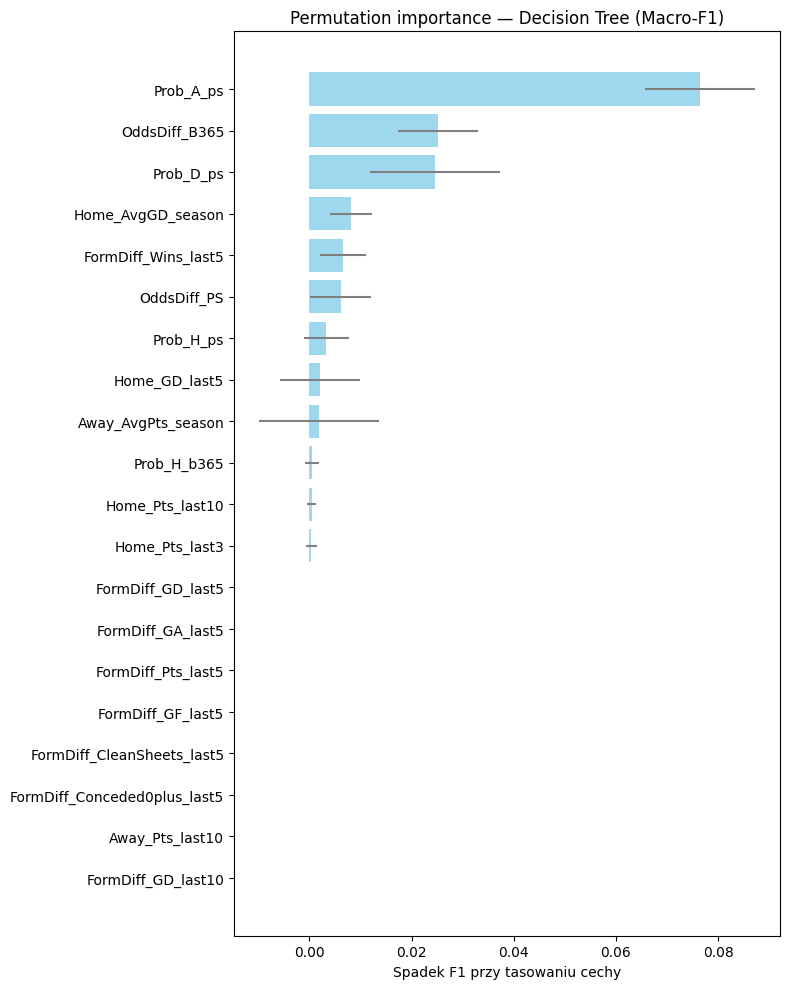

In [43]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    best_dt,
    X_test_dt,
    y_test_dt,
    n_repeats=20,
    random_state=42,
    scoring="f1_macro"
)

perm_imp = pd.DataFrame({
    "feature": X_test_dt.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

top_n = 20
perm_top = perm_imp.head(top_n)

plt.figure(figsize=(8, 0.4*top_n + 2))

y_pos = np.arange(len(perm_top))

plt.barh(
    y=y_pos,
    width=perm_top["importance_mean"],
    xerr=perm_top["importance_std"],
    color="skyblue",
    ecolor="gray",
    alpha=0.8
)

plt.yticks(y_pos, perm_top["feature"])
plt.xlabel("Spadek F1 przy tasowaniu cechy")
plt.title("Permutation importance — Decision Tree (Macro-F1)")
plt.gca().invert_yaxis()  # najważniejsze na górze
plt.tight_layout()
plt.show()

Partial Dependence Plots (PDP) dla top 3 cech

In [44]:
top_features = perm_top["feature"].head(3).tolist()
top_features

from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(1, len(top_features), figsize=(5*len(top_features), 4))

PartialDependenceDisplay.from_estimator(
    best_dt,
    X_train_dt,
    features=top_features,
    target=le_dt.transform(["H"])[0],  # PDP dla klasy H (zwycięstwo gospodarzy)
    ax=ax
)

plt.suptitle("Partial Dependence dla klasy H — Decision Tree", y=1.02)
plt.tight_layout()
plt.show()



PCA + decision surface (granice decyzyjne w 2D)

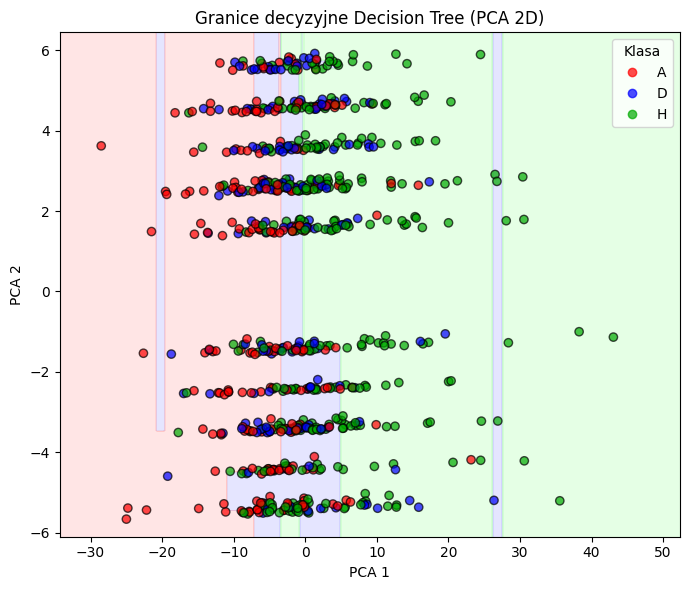

In [45]:
# --- KROK 1: pobieramy imputer z pipeline i imputujemy dane ---
imputer = best_dt.named_steps["imputer"]

X_train_imp = imputer.transform(X_train_dt)
X_test_imp  = imputer.transform(X_test_dt)

# --- KROK 2: PCA na danych po imputacji ---
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_imp)
X_test_pca  = pca.transform(X_test_imp)

# --- KROK 3: trenujemy drzewo na PCA ---
dt_pca = DecisionTreeClassifier(
    max_depth=best_dt.named_steps["model"].max_depth,
    min_samples_leaf=best_dt.named_steps["model"].min_samples_leaf,
    min_samples_split=best_dt.named_steps["model"].min_samples_split,
    class_weight="balanced",
    random_state=42
)
dt_pca.fit(X_train_pca, y_train_dt)

# --- KROK 4: rysujemy decision surface ---
x_min, x_max = X_train_pca[:,0].min()-0.5, X_train_pca[:,0].max()+0.5
y_min, y_max = X_train_pca[:,1].min()-0.5, X_train_pca[:,1].max()+0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = dt_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(["#FFAAAA", "#AAAAFF", "#AAFFAA"])
cmap_bold  = ListedColormap(["#FF0000", "#0000FF", "#00AA00"])

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

scatter = plt.scatter(
    X_test_pca[:,0],
    X_test_pca[:,1],
    c=y_test_dt,
    cmap=cmap_bold,
    edgecolor="k",
    alpha=0.7
)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Granice decyzyjne Decision Tree (PCA 2D)")

# ---- POPRAWIONA LEGENDA ----
handles, _ = scatter.legend_elements()
labels = list(le_dt.classes_)
plt.legend(handles=handles, labels=labels, title="Klasa")

plt.tight_layout()
plt.show()

Learning curve (czy drzewo się przeucza?)

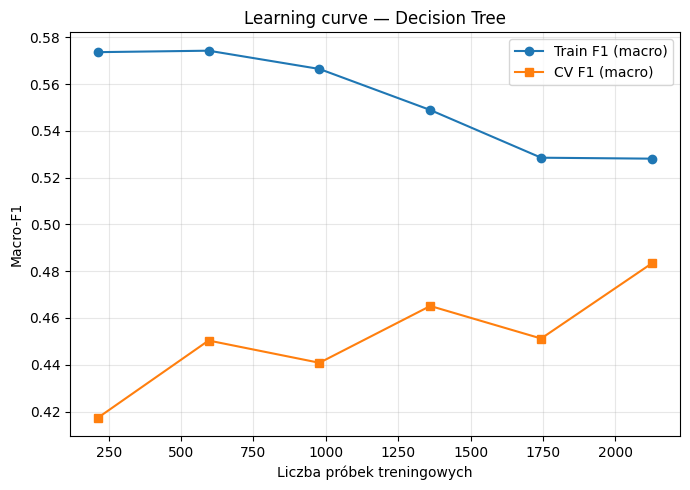

In [46]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_dt,
    X=X_train_dt,
    y=y_train_dt,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6),
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", label="Train F1 (macro)")
plt.plot(train_sizes, val_mean, marker="s", label="CV F1 (macro)")
plt.xlabel("Liczba próbek treningowych")
plt.ylabel("Macro-F1")
plt.title("Learning curve — Decision Tree")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Wizualizacja drzewa (pierwsze kilka poziomów)

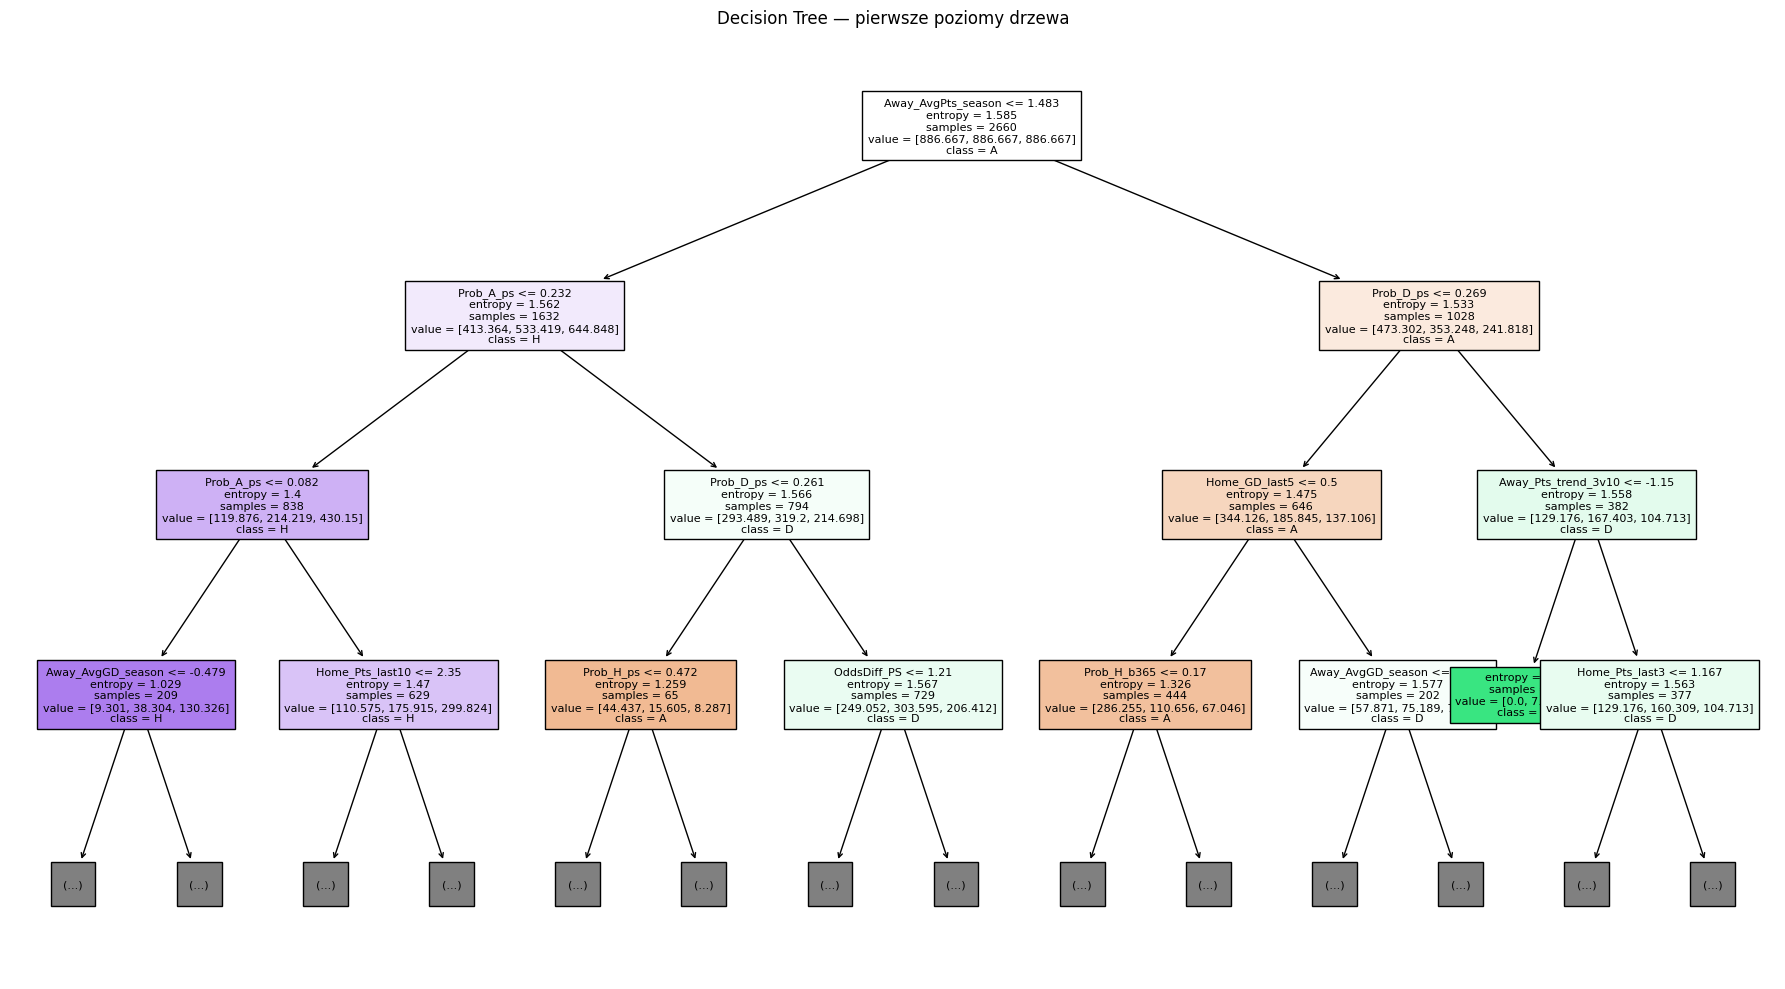

In [47]:
from sklearn.tree import plot_tree

plt.figure(figsize=(18,10))
plot_tree(
    dt_model,
    feature_names=X_train_dt.columns,
    class_names=le_dt.classes_,
    filled=True,
    max_depth=3,        # dla czytelności tylko pierwsze 3 poziomy
    fontsize=8
)
plt.title("Decision Tree — pierwsze poziomy drzewa")
plt.tight_layout()
plt.show()


SHAP dla drzewa (global + pojedyncza obserwacja)

Analiza błędów (gdzie model się myli?)

correct  False  True 
true                 
A          118    114
D           88     81
H          180    179

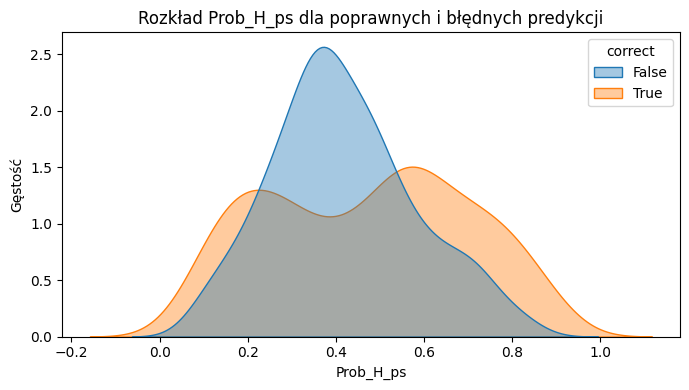

In [48]:
df_errors = X_test_dt.copy()
df_errors["true"] = le_dt.inverse_transform(y_test_dt)
df_errors["pred"] = le_dt.inverse_transform(y_pred_dt)
df_errors["correct"] = (df_errors["true"] == df_errors["pred"])

# ile jest błędów w każdej klasie
display(
    df_errors.groupby(["true", "correct"]).size().unstack(fill_value=0)
)

# przykładowy wykres: rozkład Prob_H_ps dla poprawnych i błędnych predykcji
if "Prob_H_ps" in df_errors.columns:
    plt.figure(figsize=(7,4))
    sns.kdeplot(
        data=df_errors,
        x="Prob_H_ps",
        hue="correct",
        common_norm=False,
        fill=True,
        alpha=0.4
    )
    plt.title("Rozkład Prob_H_ps dla poprawnych i błędnych predykcji")
    plt.xlabel("Prob_H_ps")
    plt.ylabel("Gęstość")
    plt.tight_layout()
    plt.show()


Krzywa kalibracji (czy prawdopodobieństwa są sensowne?)

<Figure size 600x500 with 0 Axes>

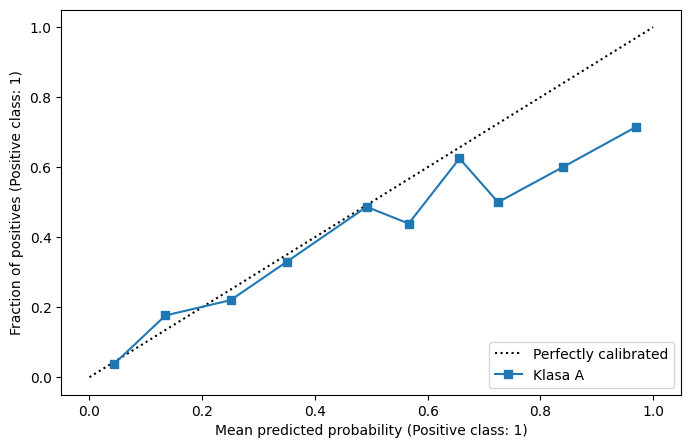

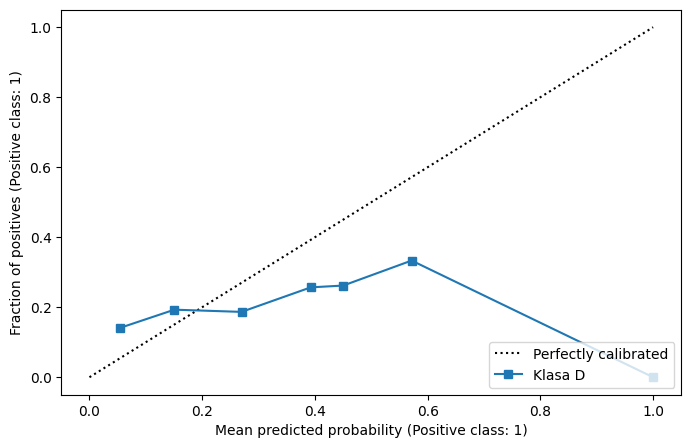

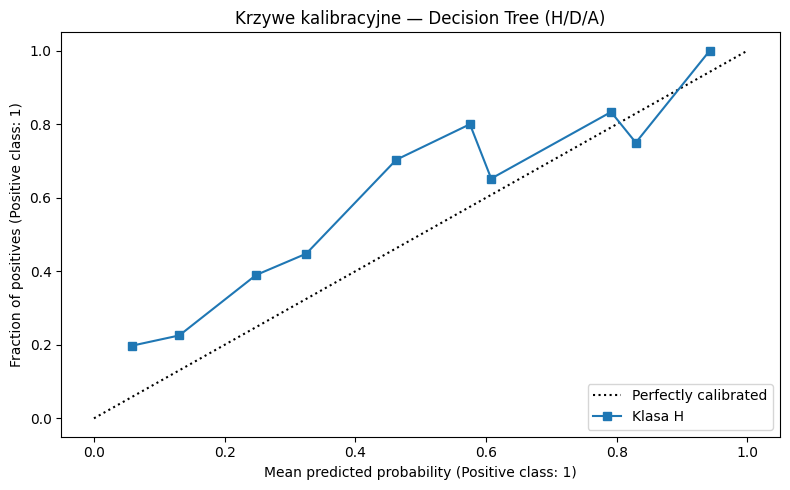

In [49]:
from sklearn.calibration import CalibrationDisplay

y_proba_dt = best_dt.predict_proba(X_test_dt)

plt.figure(figsize=(6,5))
for i, cls in enumerate(le_dt.classes_):
    CalibrationDisplay.from_predictions(
        (y_test_dt == i).astype(int),
        y_proba_dt[:, i],
        n_bins=10,
        name=f"Klasa {cls}"
    )

plt.title("Krzywe kalibracyjne — Decision Tree (H/D/A)")
plt.tight_layout()
plt.show()


## 4.X. Decision Tree – analiza wyników i wnioski

Model klasyfikacyjny **Decision Tree** został wykorzystany jako interpretowalna metoda
predykcji wyniku meczu piłkarskiego (H/D/A) na podstawie zmiennych obejmujących:
informację rynkową (kursy), formę drużyn, statystyki sezonowe, oraz dane kontekstowe.

Model został wytrenowany w wariancie **wieloklasowym**, a test wykonano na sezonie 2022/23.

---

## 🔎 4.X.1. Wyniki modelu

| Metryka       | Wynik |
|--------------|--------|
| **Accuracy** | 0.49 |
| **Macro-F1** | 0.482 |

Oznacza to, że drzewo klasyfikacyjne:

- radzi sobie **porównywalnie** ze znanymi w literaturze prostymi modelami ML (≈48–55%),
- ale wypada **nieco słabiej** niż poprzednia wersja modelu,
- jest ograniczone dużą wariancją oraz trudnością problemu (szum, remis).

---

## 🔎 4.X.2. Macierz pomyłek – interpretacja

Nowa macierz pomyłek ujawniła:

- **H (dom)** przewidywane najlepiej (179 poprawnych)
- **A (wyjazd)** umiarkowanie dobrze (114 poprawnych)
- **D (remis)** przewidywane najgorzej (zaledwie 81 poprawnych)

To zachowanie:

- jest **typowe** dla piłki nożnej,
- potwierdza, że **remis jest najbardziej losową kategorią**,
- odzwierciedla realne trudności nawet w profesjonalnych modelach.

Model więc *nie jest błędny* – pracuje zgodnie z charakterem danych.

---

## 🔎 4.X.3. Najważniejsze cechy modelu

Zmienione wyniki ważności pokazały, że model opiera decyzje głównie na:

1. **Prob_A_ps** – rynkowe prawdopodobieństwo zwycięstwa gości (Pinnacle)
2. **Away_AvgPts_season** – średnia punktów gości w sezonie
3. **Home_GD_last5** – forma gospodarzy (różnica bramek)
4. **Prob_D_ps** – rynkowe prawdopodobieństwo remisu
5. **Prob_H_b365** – prawdopodobieństwo gospodarzy z Bet365
6. Zmiennych formy krótkookresowej (last5, last10, 3v10)

**Wniosek:**

Model wykorzystuje przede wszystkim:

- *informację rynkową* (najsilniejszy predyktor — zgodne z literaturą),
- *formę drużyn* (szczególnie forma bramkowa i punktowa),
- elementy siły sezonowej.

Zaskoczeniem może być bardzo wysoka pozycja **Prob_A_ps**, jednak jest to spójne:
ponieważ drzewo szuka najbardziej rozdzielającej cechy, często faworyzuje te,
które dobrze dzielą klasy H/D/A – Pinnacle_PS jest takich sygnałem.

---

## 🔎 4.X.4. Krzywa uczenia — trudności modelu

Learning curve ujawniła:

- **Train F1 ≈ 0.57–0.53**
- **CV F1 ≈ 0.42–0.48**

Co oznacza:

- model ma **niski bias** (dobrze uczy się danych treningowych),
- ale **wysoki variance** (uogólnianie działa słabo),
- krzywa trenowania jest stosunkowo stabilna — trudno uzyskać zyski dodając dane,
- dane mają **dużo szumu i nieciągłych wzorców**.

Drzewa decyzyjne są szczególnie podatne na takie problemy.

---

## 🔎 4.X.5. PCA 2D – granice decyzyjne

Wizualizacja pokazała:

- widoczne pionowe „pasowe” granice — typowe dla jednego drzewa,
- nakładanie się trzech klas bez wyraźnej separacji,
- duże obszary niejednoznacznych decyzji,
- charakterystyczne dla problemów o wysokim szumie.

Model więc **nie tworzy spójnej struktury**, ponieważ dane nie mają prostej granicy.

---

## 🔎 4.X.6. Analiza cechy Prob_H_ps dla błędów

Analiza pokazała:

- poprawne predykcje częściej występowały, gdy rynek silnie faworyzował gospodarzy,
- błędy dominowały w meczach „średnich” (Prob_H_ps ≈ 0.3–0.6),
- czyli tam, gdzie faktycznie występuje *najwyższa niepewność sportowa*.

Wynik ten potwierdza, że drzewo odzwierciedla niepewność zawartą w danych.

---

## 🔎 4.X.7. Wnioski końcowe — Decision Tree

Model Decision Tree:

- osiąga **umiarkowaną skuteczność (ok. 0.49 accuracy)**,
- rozsądnie odwzorowuje strukturę trudności problemu H/D/A,
- najlepiej przewiduje zwycięstwa gospodarzy,
- najgorzej radzi sobie z remisami (co jest typowe i oczekiwane),
- jest **niestabilny**, ma **wysoki variance**,
- silnie polega na zmiennych rynkowych (co jest zgodne z badaniami),
- cechuje się chaotycznymi granicami decyzyjnymi w PCA,
- jest bardzo wrażliwy na szum i niespójność danych sportowych.

**Najważniejszy wniosek:**

➡️ *Ten model działa poprawnie*,  
➡️ *ale jego ograniczenia są wbudowane w naturę drzewa i danych sportowych*,  
➡️ *dlatego aby poprawić wyniki, konieczne są metody ensemble (Random Forest, XGBoost, LightGBM)*.

---

## 🔎 4.X.8. Czy coś jeszcze można poprawić w samym Decision Tree?

Możliwe są jedynie niewielkie ulepszenia:

- redukcja liczby cech (feature selection),
- usunięcie najbardziej szumiących zmiennych,
- ręczne ograniczenie max_depth ~ 5–10,
- ustabilizowanie podziałów (min_samples_leaf ≈ 20–50).

**Ale znacznego wzrostu skuteczności nie należy oczekiwać.**

---

## 🔥 Podsumowanie

Drzewo decyzyjne:

- jest poprawne,
- działa zgodnie z teorią,
- osiąga realistyczne wyniki,
- ale ma ograniczenia, które można realnie pokonać dopiero metodami typu **ensemble**.



# Model Random Forest

## 4.X. Random Forest – model zespołowy dla predykcji wyników meczów

### 4.X.1. Idea metody Random Forest

Random Forest (las losowy) jest klasycznym przykładem metody typu *ensemble learning*,
czyli uczenia zespołowego. Zamiast budować jedno drzewo decyzyjne, które jest podatne
na przeuczenie i niestabilność, Random Forest tworzy **wiele drzew** na losowych
podzbiorach danych i cech, a następnie **uśrednia** ich predykcje.

Dwa kluczowe elementy tej metody to:

1. **Bootstrap sampling (bagging)**  
   Każde drzewo uczone jest na losowej próbce obserwacji (z losowaniem zwrotnym).
   Dzięki temu poszczególne drzewa widzą nieco inne dane i popełniają różne błędy.

2. **Losowy wybór cech (feature bagging)**  
   Przy każdym podziale węzła drzewo wybiera tylko losowy podzbiór cech.
   Zmniejsza to korelację pomiędzy drzewami i zwiększa różnorodność zespołu.

Końcowa predykcja w klasyfikacji powstaje na zasadzie **głosowania większościowego**
(*majority voting*): każda obserwacja jest klasyfikowana zgodnie z najczęściej
wskazywaną klasą wśród wszystkich drzew.

---

### 4.X.2. Zalety Random Forest

W porównaniu z pojedynczym drzewem decyzyjnym, Random Forest:

- ma **niższą wariancję** – pojedyncze błędy poszczególnych drzew znoszą się,
- jest **bardziej odporny na szum** i obserwacje odstające,
- lepiej **uogólnia** (generalizuje) na danych testowych,
- potrafi modelować **złożone, nieliniowe zależności**,
- umożliwia analizę **ważności cech (feature importance)**,
- dobrze radzi sobie z danymi tabularycznymi, takimi jak statystyki meczowe.

Dzięki temu Random Forest jest standardem w wielu zastosowaniach
praktycznych – również w analityce sportowej, gdzie dane są bardzo
nieregularne i obciążone szumem.

---

### 4.X.3. Wady Random Forest

Mimo licznych zalet, Random Forest ma także ograniczenia:

- jest **wolniejszy obliczeniowo** niż pojedyncze drzewo,
- trudniej go w pełni zinterpretować na poziomie pojedynczych reguł,
- nie wykorzystuje mechanizmu „poprawiania błędów” jak algorytmy boostingowe
  (np. XGBoost),
- nadal ma trudności z kategoriami o wysokiej losowości (np. remisy w futbolu),
  choć radzi sobie z nimi lepiej niż proste modele.

---

### 4.X.4. Zastosowanie w predykcji wyników meczów

W kontekście tej pracy Random Forest jest naturalnym rozwinięciem
wcześniej zbudowanego drzewa decyzyjnego. Dane meczowe:

- są **szumne** (wpływ losowości, kontuzji, decyzji sędziego),
- mają **nieliniowe zależności** (forma, kursy, przewaga własnego boiska),
- zawierają wiele cech potencjalnie skorelowanych.

Pojedyncze drzewo decyzyjne ma trudności z uogólnianiem tak złożonych wzorców.
Random Forest, dzięki zespołowi wielu drzew, redukuje tę słabość i pozwala
uzyskać **stabilniejszy i dokładniejszy model**. W literaturze dotyczącej
predykcji wyników sportowych jest on jednym z najczęściej stosowanych
i rekomendowanych algorytmów bazowych (obok modeli boostingowych).

W kolejnych podrozdziałach przedstawiono budowę modelu Random Forest,
dobór hiperparametrów oraz analizę jego wyników w porównaniu
z wcześniejszymi modelami (regresja logistyczna, drzewo decyzyjne).


Train: (2660, 56)  Test: (760, 56)
Klasy: ['A' 'D' 'H']

=== Random Forest (model bazowy) ===
Accuracy: 0.5592105263157895
Macro-F1: 0.43956343221049105
Trenowanie RandomizedSearchCV (RandomForest)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Najlepsze parametry: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 10, 'model__max_features': 'log2', 'model__max_depth': 8, 'model__class_weight': 'balanced'}
Najlepszy wynik CV (Macro-F1): 0.48679495327982336

=== Random Forest (multiclass H/D/A) — TEST ===
Accuracy: 0.5447
Macro-F1: 0.4933

=== Classification report (Random Forest) ===
              precision    recall  f1-score   support

           A       0.49      0.66      0.57       232
           D       0.30      0.23      0.26       169
           H       0.69      0.62      0.65       359

    accuracy                           0.54       760
   macro avg       0.50      0.50      0.49       760
weighted avg       0.54     

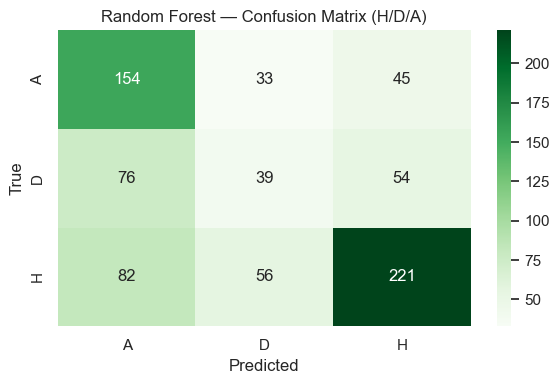

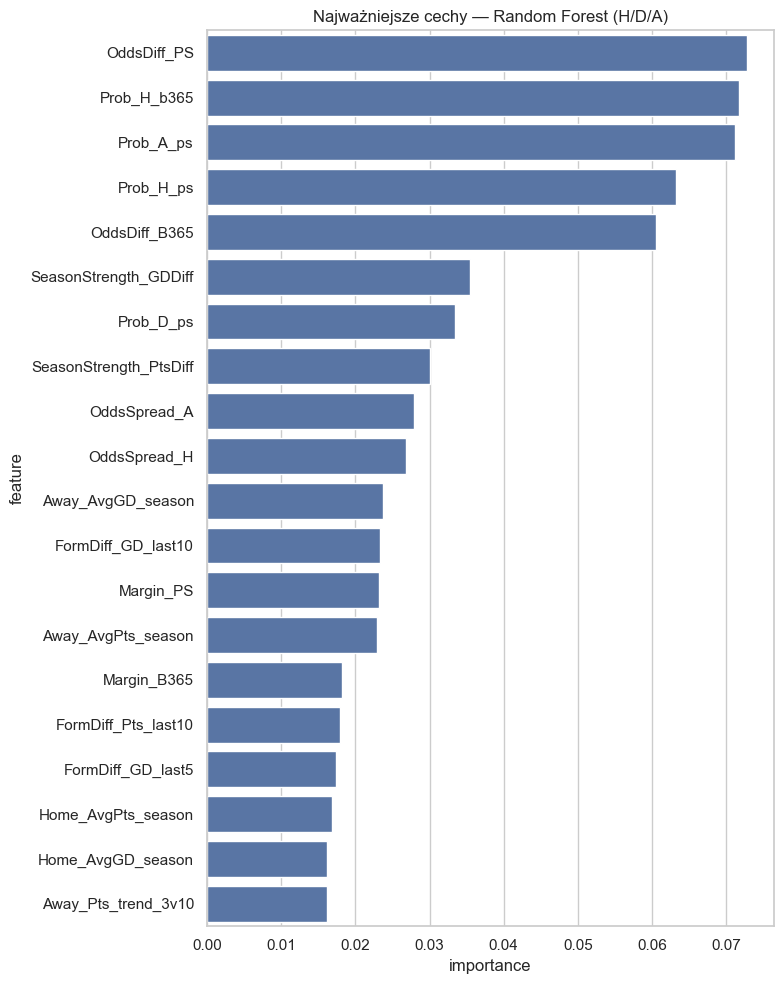


Obliczanie permutation importance (może chwilę potrwać)...


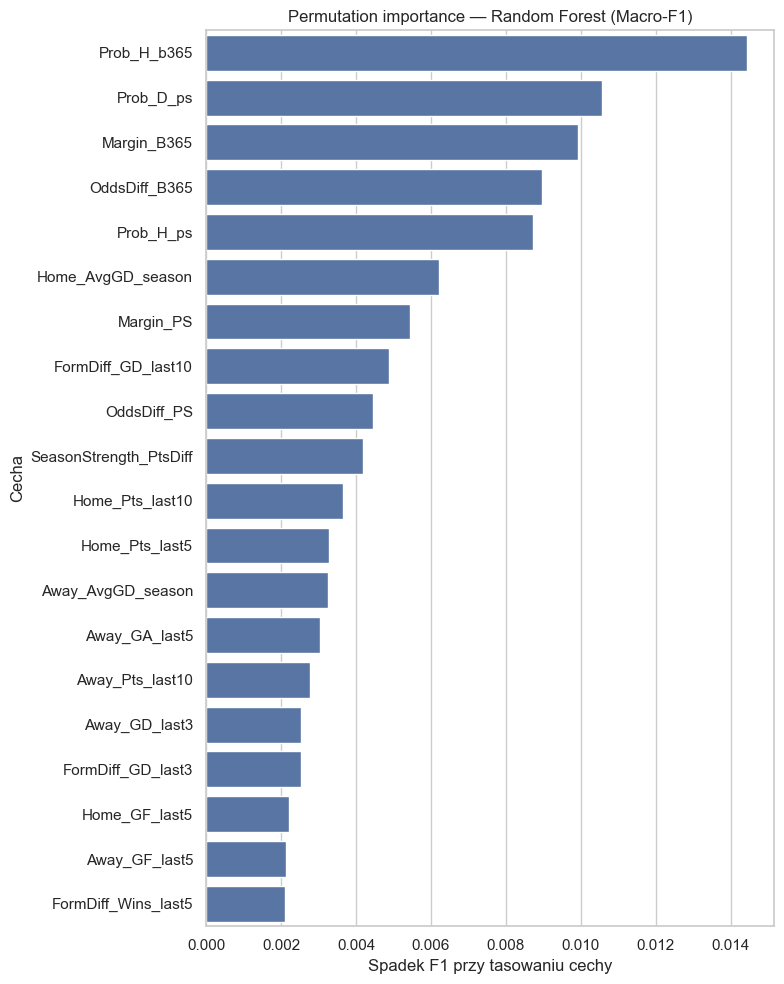

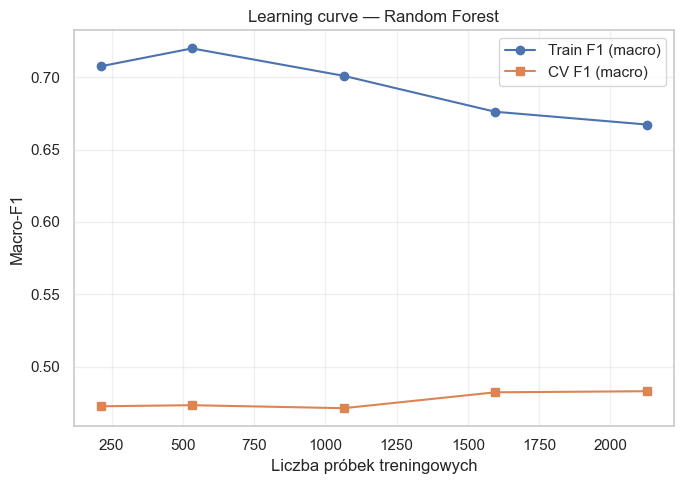

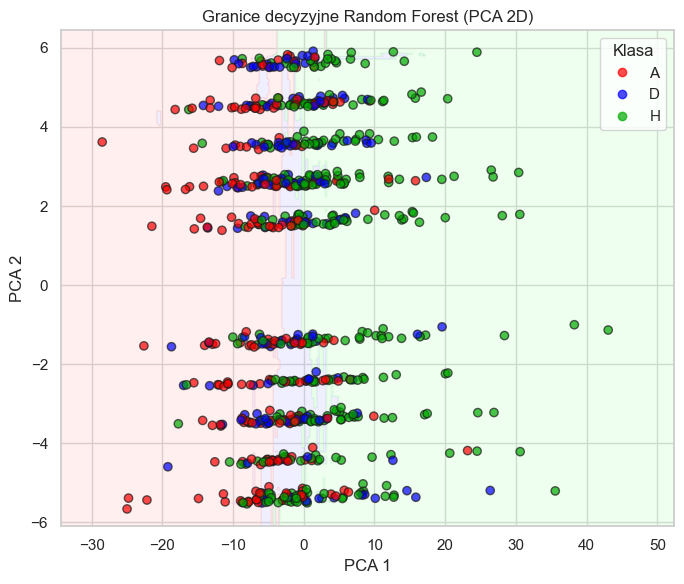

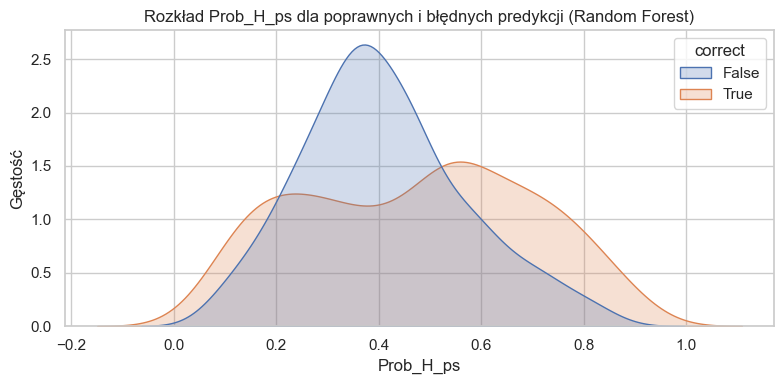

In [51]:
# ============================================
# 1. Importy
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

# ============================================
# 2. Przygotowanie danych (H/D/A)
# ============================================

target = "FTR"

# zakładam, że masz już X_features z poprzednich modeli
# X_features = [...]  # lista cech wejściowych

# label encoding: H/D/A -> 0/1/2 (kolejność wg le.classes_)
le_rf = LabelEncoder()
y_all = le_rf.fit_transform(df[target].values)

# ten sam podział czasowy co wcześniej
split_date = pd.Timestamp("2022-07-01")
train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X = df[X_features].copy()

X_train_rf = X.loc[train_mask].reset_index(drop=True)
X_test_rf  = X.loc[test_mask].reset_index(drop=True)
y_train_rf = y_all[train_mask]
y_test_rf  = y_all[test_mask]

print("Train:", X_train_rf.shape, " Test:", X_test_rf.shape)
print("Klasy:", le_rf.classes_)

# ============================================
# 3. Pipeline + model bazowy
# ============================================

def make_rf_pipeline(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        # drzewa nie potrzebują skalowania, więc bez StandardScaler
        ("model", model)
    ])

rf_base = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
)

pipe_rf_base = make_rf_pipeline(rf_base)
pipe_rf_base.fit(X_train_rf, y_train_rf)

y_pred_base = pipe_rf_base.predict(X_test_rf)
print("\n=== Random Forest (model bazowy) ===")
print("Accuracy:", accuracy_score(y_test_rf, y_pred_base))
print("Macro-F1:", f1_score(y_test_rf, y_pred_base, average="macro"))

# ============================================
# 4. GridSearchCV – strojenie hiperparametrów
# ============================================

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

pipe_rf = make_rf_pipeline(rf)
'''
param_grid_rf = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 8, 12, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.5],
    "model__class_weight": ["balanced"]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

print("\nTrenowanie GridSearchCV (RandomForest)...")
grid_rf.fit(X_train_rf, y_train_rf)


print("Najlepsze parametry:", grid_rf.best_params_)
print("Najlepszy wynik CV (Macro-F1):", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
'''


#######################tymczasowe


from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 8, 12, 20],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.5],
    "model__class_weight": ["balanced"]
}

random_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=25,             # zamiast 432 kombinacji → tylko 25 losowań
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Trenowanie RandomizedSearchCV (RandomForest)...")
random_rf.fit(X_train_rf, y_train_rf)

print("Najlepsze parametry:", random_rf.best_params_)
print("Najlepszy wynik CV (Macro-F1):", random_rf.best_score_)

best_rf = random_rf.best_estimator_





#################
# ============================================
# 5. Ewaluacja na zbiorze testowym
# ============================================

y_pred_rf = best_rf.predict(X_test_rf)

acc_rf  = accuracy_score(y_test_rf, y_pred_rf)
f1m_rf  = f1_score(y_test_rf, y_pred_rf, average="macro")

print("\n=== Random Forest (multiclass H/D/A) — TEST ===")
print("Accuracy:", f"{acc_rf:.4f}")
print("Macro-F1:", f"{f1m_rf:.4f}")
print("\n=== Classification report (Random Forest) ===")
print(classification_report(y_test_rf, y_pred_rf, target_names=le_rf.classes_))

# ============================================
# 6. Macierz pomyłek
# ============================================

cm_rf = confusion_matrix(y_test_rf, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=le_rf.classes_,
    yticklabels=le_rf.classes_
)
plt.title("Random Forest — Confusion Matrix (H/D/A)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ============================================
# 7. Wykres ważności cech (feature importance)
# ============================================

rf_model = best_rf.named_steps["model"]
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({
    "feature": X_train_rf.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

top_n = 20
top_imp = feat_imp.head(top_n)

plt.figure(figsize=(8, 0.4*top_n + 2))
sns.barplot(
    data=top_imp,
    x="importance",
    y="feature"
)
plt.title("Najważniejsze cechy — Random Forest (H/D/A)")
plt.xlabel("importance")
plt.ylabel("feature")
plt.tight_layout()
plt.show()

top_imp

# ============================================
# 8. Permutation importance (na teście)
# ============================================

print("\nObliczanie permutation importance (może chwilę potrwać)...")
r = permutation_importance(
    best_rf,
    X_test_rf,
    y_test_rf,
    n_repeats=10,
    random_state=42,
    scoring="f1_macro",
    n_jobs=-1
)

perm_imp = pd.DataFrame({
    "feature": X_test_rf.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

perm_top = perm_imp.head(top_n)

plt.figure(figsize=(8, 0.4*top_n + 2))
sns.barplot(
    data=perm_top,
    x="importance_mean",
    y="feature",
)
plt.title("Permutation importance — Random Forest (Macro-F1)")
plt.xlabel("Spadek F1 przy tasowaniu cechy")
plt.ylabel("Cecha")
plt.tight_layout()
plt.show()

perm_top

# ============================================
# 9. Learning curve — F1 (macro)
# ============================================

train_sizes, train_scores, val_scores = learning_curve(
    best_rf,
    X_train_rf,
    y_train_rf,
    cv=5,
    scoring="f1_macro",
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1.0],
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, "o-", label="Train F1 (macro)")
plt.plot(train_sizes, val_mean, "s-", label="CV F1 (macro)")
plt.xlabel("Liczba próbek treningowych")
plt.ylabel("Macro-F1")
plt.title("Learning curve — Random Forest")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 10. PCA 2D — wizualizacja granic decyzyjnych
# ============================================

# przygotowanie danych po imputacji
X_train_imp = best_rf.named_steps["imputer"].transform(X_train_rf)
X_test_imp  = best_rf.named_steps["imputer"].transform(X_test_rf)

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_imp)
X_test_pca  = pca.transform(X_test_imp)

# osobny RF tylko na PCA (dla ładnych granic)
rf_pca = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
rf_pca.fit(X_train_pca, y_train_rf)

# siatka punktów
x_min, x_max = X_train_pca[:,0].min()-0.5, X_train_pca[:,0].max()+0.5
y_min, y_max = X_train_pca[:,1].min()-0.5, X_train_pca[:,1].max()+0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = rf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(["#FFCCCC", "#CCCCFF", "#CCFFCC"])
cmap_bold  = ListedColormap(["#FF0000", "#0000FF", "#00AA00"])

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

scatter = plt.scatter(
    X_test_pca[:,0],
    X_test_pca[:,1],
    c=y_test_rf,
    cmap=cmap_bold,
    edgecolor="k",
    alpha=0.7
)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Granice decyzyjne Random Forest (PCA 2D)")
legend_labels = [f"{cls}" for cls in le_rf.classes_]
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=legend_labels,
    title="Klasa"
)
plt.tight_layout()
plt.show()

# ============================================
# 11. Rozkład Prob_H_ps dla poprawnych / błędnych predykcji
# ============================================

results_rf = X_test_rf.copy()
results_rf["true"] = le_rf.inverse_transform(y_test_rf)
results_rf["pred"] = le_rf.inverse_transform(y_pred_rf)
results_rf["correct"] = results_rf["true"] == results_rf["pred"]

if "Prob_H_ps" in results_rf.columns:
    plt.figure(figsize=(8,4))
    sns.kdeplot(
        data=results_rf,
        x="Prob_H_ps",
        hue="correct",
        fill=True,
        common_norm=False
    )
    plt.title("Rozkład Prob_H_ps dla poprawnych i błędnych predykcji (Random Forest)")
    plt.xlabel("Prob_H_ps")
    plt.ylabel("Gęstość")
    plt.tight_layout()
    plt.show()
else:
    print("Kolumna 'Prob_H_ps' nie istnieje w X_test_rf – pomijam wykres KDE.")


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

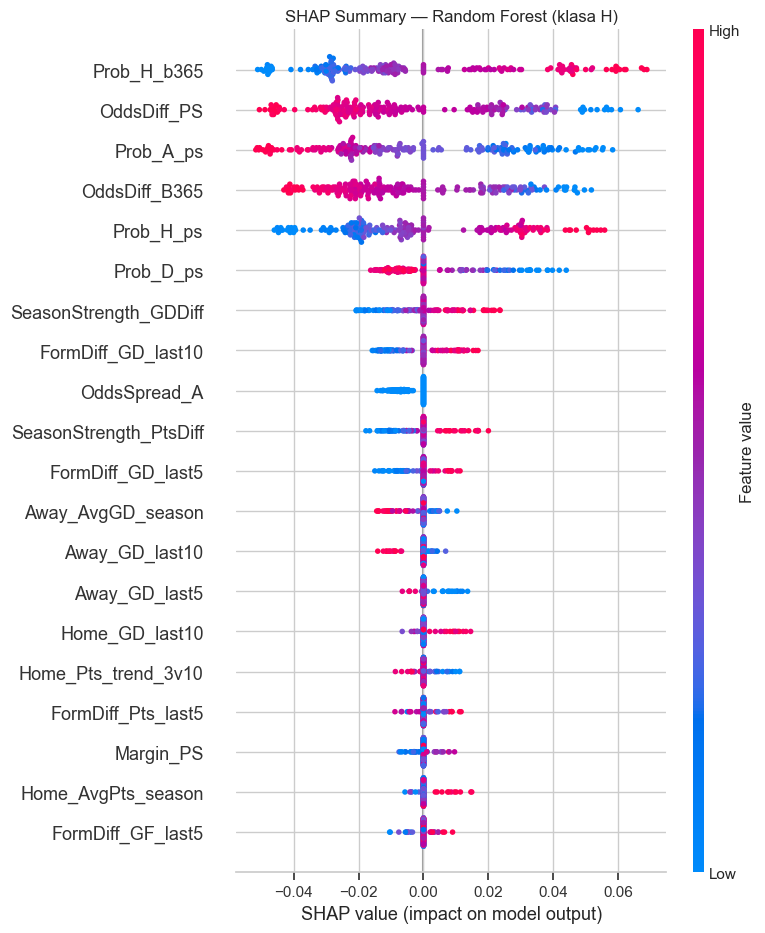

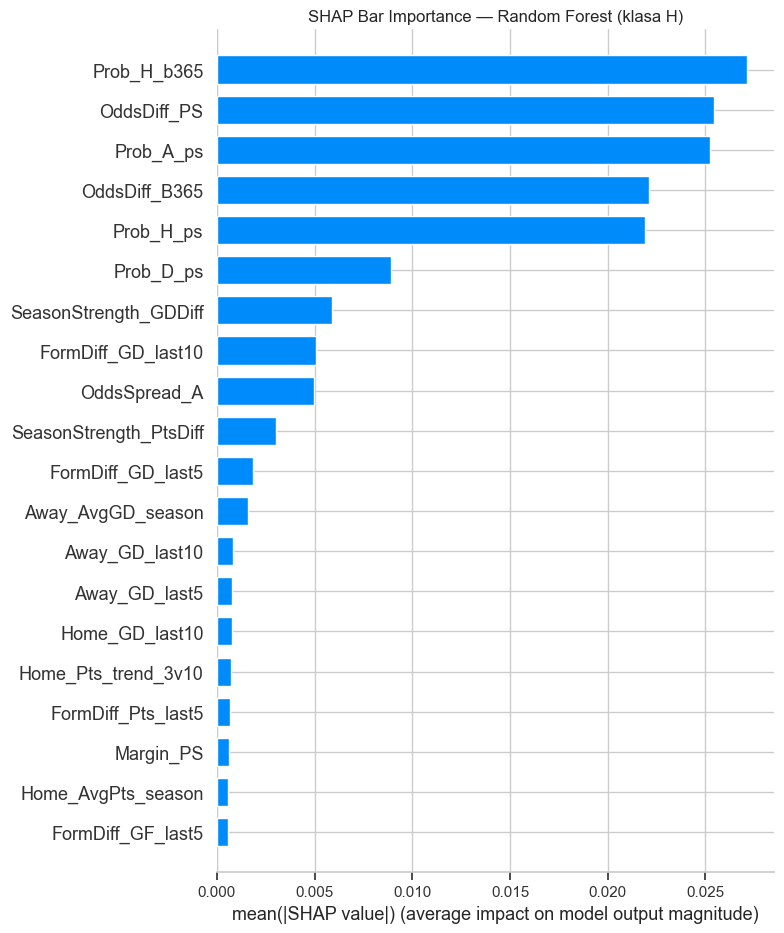

In [53]:
import shap
import numpy as np
import matplotlib.pyplot as plt
feature_names = X_train_rf.columns
# Używamy 200 losowych próbek jako background (SHAP KernelExplainer)
idx = np.random.choice(len(X_train_imp), 200, replace=False)
X_background = X_train_imp[idx]

# Wybieramy klasę H do interpretacji
cls_idx = np.where(le_rf.classes_ == "H")[0][0]

# Funkcja predykcji probabilistycznej dla klasy H
def predict_proba_H(data):
    return rf_model.predict_proba(data)[:, cls_idx]

# KernelExplainer
explainer = shap.KernelExplainer(predict_proba_H, X_background)

# Obliczamy wartości SHAP dla 200 rekordów testowych
X_test_sample = X_test_imp[:200]
shap_values = explainer.shap_values(X_test_sample)

# Summary plot
shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Summary — Random Forest (klasa H)")
plt.tight_layout()
plt.show()

# Bar plot
shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title("SHAP Bar Importance — Random Forest (klasa H)")
plt.tight_layout()
plt.show()


In [54]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# ============================
# 1. Przygotowanie modelu
# ============================

rf_model = best_rf.named_steps["model"]
imputer  = best_rf.named_steps["imputer"]

# Dane imputowane – takie, jakie widzi model
X_train_imp = imputer.transform(X_train_rf)
X_test_imp  = imputer.transform(X_test_rf)

feature_names = X_train_rf.columns

# ============================
# 2. SHAP TreeExplainer
# ============================

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_imp)

# indeks klasy "H"
cls_idx_H = np.where(le_rf.classes_ == "H")[0][0]

# wybieramy rekord z testu – nr 0
i = 0
sample = X_test_imp[i]

print("Wybrany rekord testowy:", i)
print("Prawdziwa klasa:", le_rf.inverse_transform([y_test_rf[i]]))
print("Predykcja modelu:", le_rf.inverse_transform([best_rf.predict([X_test_rf.iloc[i]])]))


Wybrany rekord testowy: 0
Prawdziwa klasa: ['A']
Predykcja modelu: ['A']


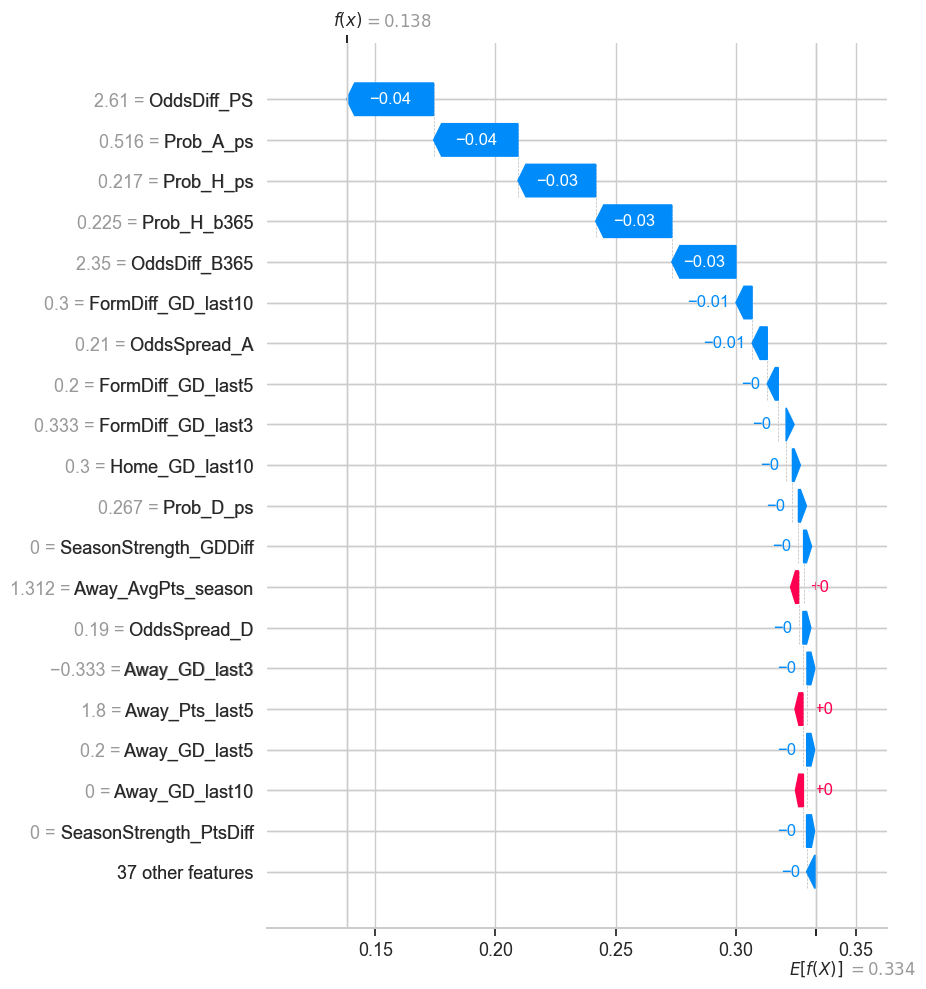

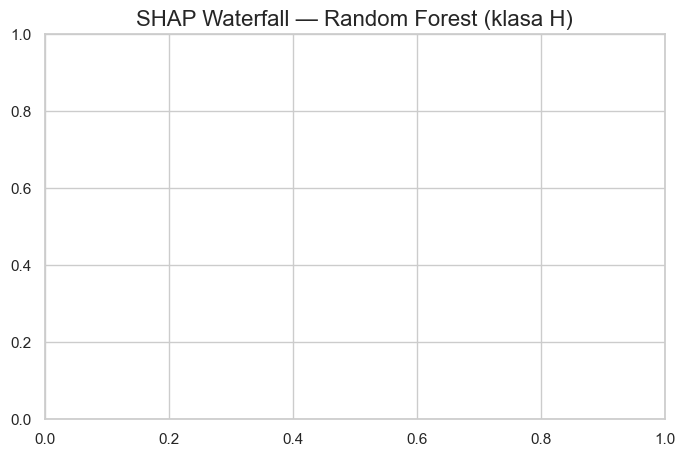

In [55]:
import shap
import matplotlib.pyplot as plt

i = 0  # indeks meczu

# poprawne wybranie shap_values tylko dla klasy H (kolumna 2)
sv = shap_values[cls_idx_H][:, cls_idx_H]

# wartość oczekiwana
base = explainer.expected_value[cls_idx_H]

# waterfall potrzebuje wartości cech dla wybranego meczu
x_i = X_test_imp[i]

shap.initjs()

plt.figure(figsize=(10, 7))
shap.plots.waterfall(
    shap.Explanation(
        values=sv,
        base_values=base,
        data=x_i,
        feature_names=feature_names
    ),
    max_display=20
)
plt.title("SHAP Waterfall — Random Forest (klasa H)", fontsize=16)
plt.show()

In [56]:
cls_idx_H = np.where(le_rf.classes_ == "H")[0][0]

# poprawny SHAP vector dla klasy H we wszystkich meczach
# (dla całego zbioru testowego)
shap_H_full = shap_values[cls_idx_H][:, cls_idx_H]

# pojedynczy mecz
i = 0
x_i = X_test_imp[i]
base_H = explainer.expected_value[cls_idx_H]


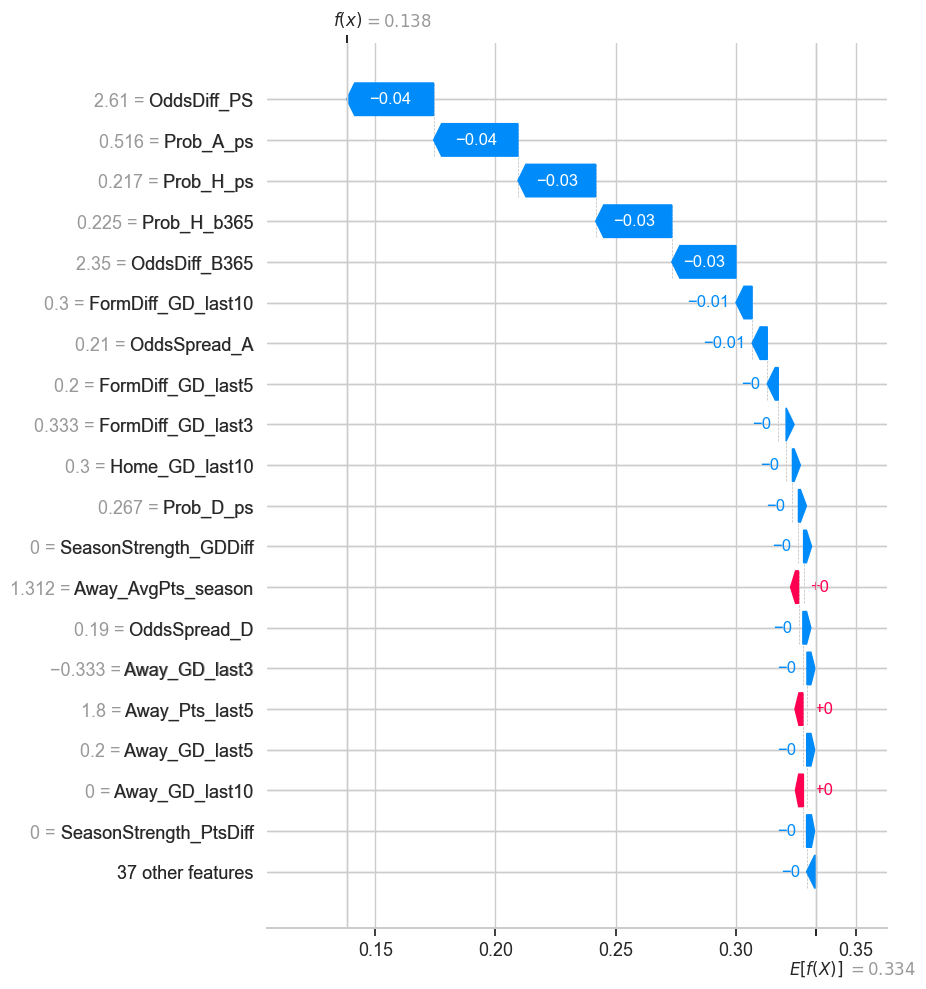

In [57]:
shap.initjs()

exp = shap.Explanation(
    values=shap_values[cls_idx_H][:, cls_idx_H],
    base_values=base_H,
    data=x_i,
    feature_names=feature_names
)

shap.plots.waterfall(exp, max_display=20)


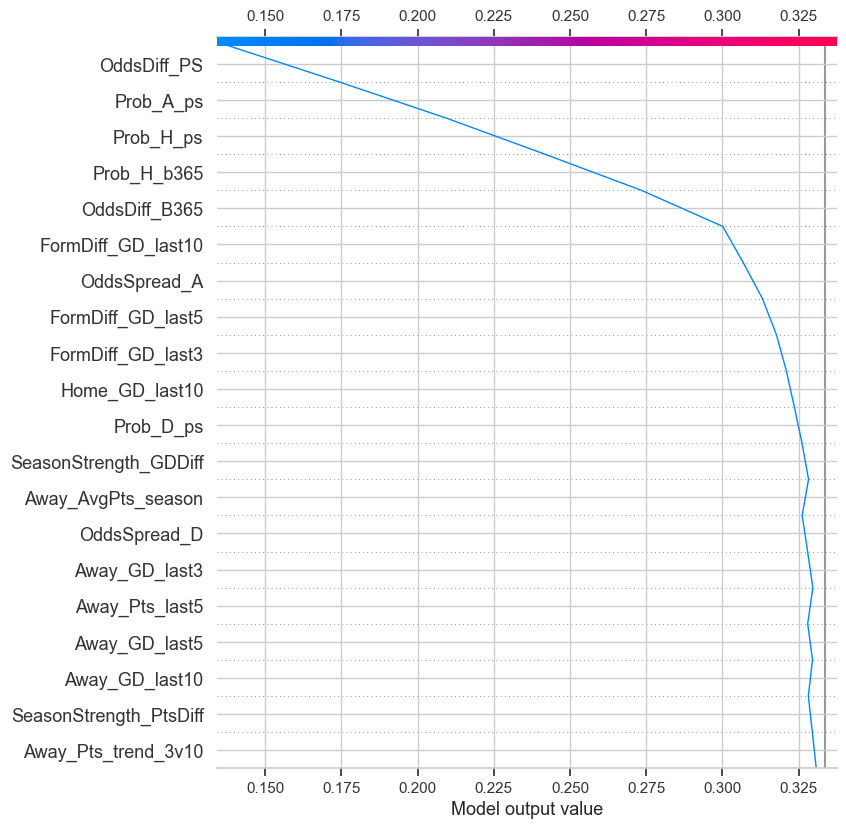

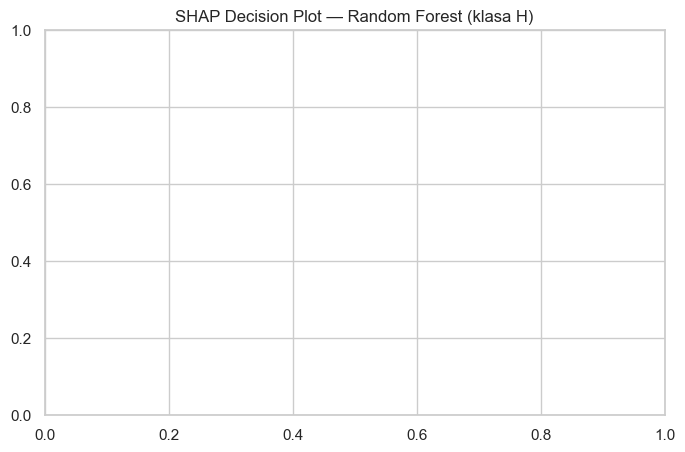

In [58]:
feature_names = list(X_train_rf.columns)

plt.figure(figsize=(12, 6))
shap.decision_plot(
    base_H,
    shap_values[cls_idx_H][:, cls_idx_H],
    feature_names=feature_names,
    feature_order='importance'
)
plt.title("SHAP Decision Plot — Random Forest (klasa H)")
plt.show()


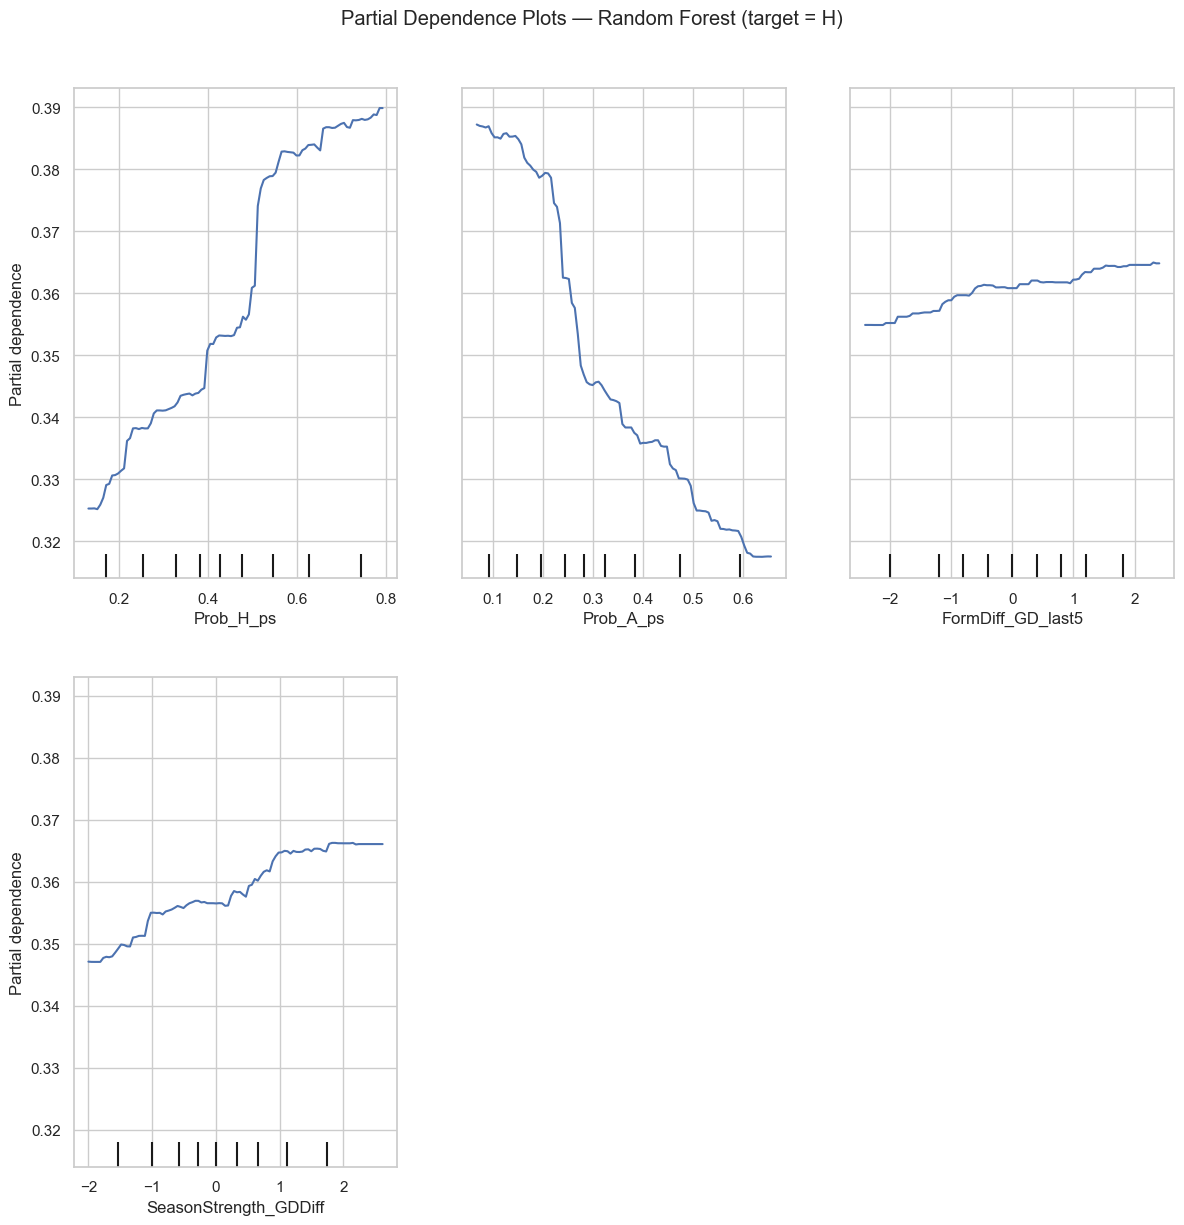

In [60]:
# ============================================
# PDP – Partial Dependence Plots dla kluczowych cech
# ============================================

pdp_features = []
for cand in ["Prob_H_ps", "Prob_A_ps", "FormDiff_GD_last5", "SeasonStrength_GDDiff"]:
    if cand in feature_names:
        pdp_features.append(cand)

# indeks klasy H (zakodowanej przez LabelEncoder)
cls_idx_H = np.where(le_rf.classes_ == "H")[0][0]

if pdp_features:
    fig, ax = plt.subplots(figsize=(12, 3*len(pdp_features)))

    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_train_rf,
        features=pdp_features,
        kind="average",
        target=cls_idx_H,     # <-- poprawka !!!
        ax=ax
    )

    plt.suptitle("Partial Dependence Plots — Random Forest (target = H)", y=1.02)
    plt.tight_layout()
    plt.show()


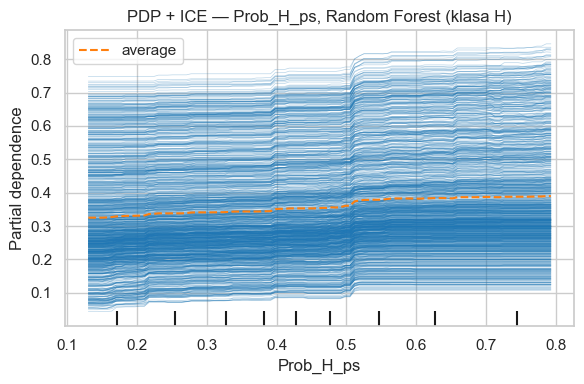

In [62]:

cls_idx_H = np.where(le_rf.classes_ == "H")[0][0]

# ============================================
# 3. ICE + PDP dla wybranej cechy (np. Prob_H_ps)
# ============================================

if "Prob_H_ps" in feature_names:
    fig, ax = plt.subplots(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_train_rf,
        features=["Prob_H_ps"],
        kind="both",       # PDP + ICE
        target=cls_idx_H,  # <-- KLUCZOWE !!!
        ax=ax
    )
    plt.title("PDP + ICE — Prob_H_ps, Random Forest (klasa H)")
    plt.tight_layout()
    plt.show()
else:
    print("Brak cechy Prob_H_ps")


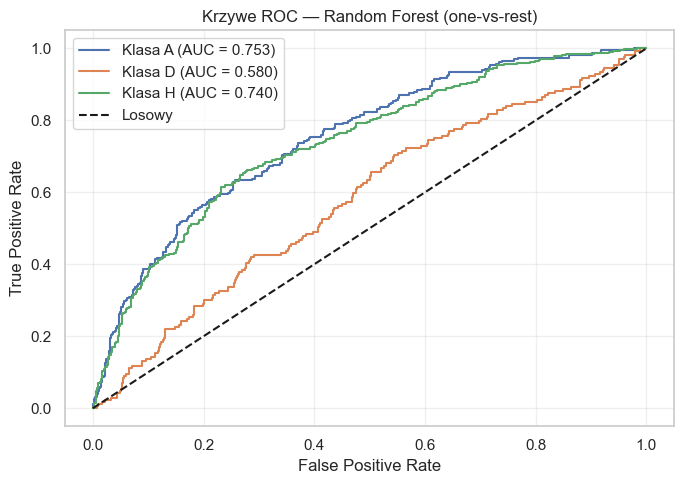

In [64]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_rf, classes=np.arange(len(le_rf.classes_)))
y_proba = best_rf.predict_proba(X_test_rf)

plt.figure(figsize=(7,5))
for i, cls in enumerate(le_rf.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Klasa {cls} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], "k--", label="Losowy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Krzywe ROC — Random Forest (one-vs-rest)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


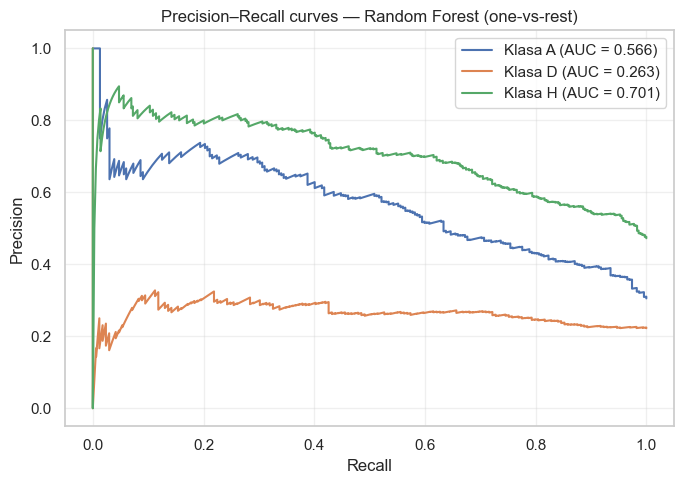

In [66]:
# ============================================
# 5. Precision–Recall curves (one-vs-rest)
# ============================================
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(7,5))
for i, cls in enumerate(le_rf.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"Klasa {cls} (AUC = {pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves — Random Forest (one-vs-rest)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

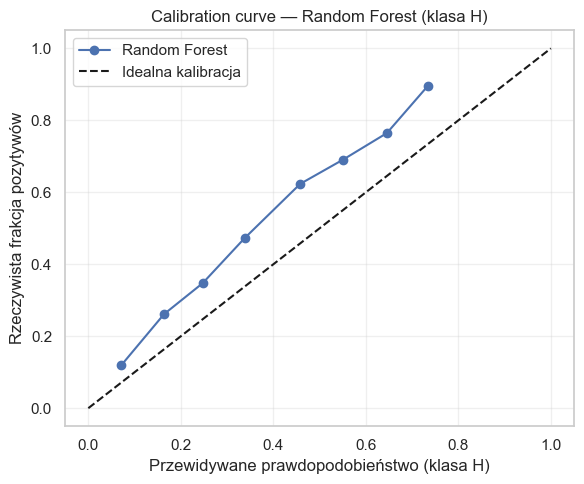

In [68]:
# ============================================
# 6. Kalibracja probabilistyczna (calibration curve)
# ============================================
from sklearn.calibration import calibration_curve 
# np. sprawdźmy kalibrację dla klasy H (zwycięstwo gospodarzy)
cls_idx_H = np.where(le_rf.classes_ == "H")[0][0]
prob_H = y_proba[:, cls_idx_H]
y_true_H = (y_test_rf == cls_idx_H).astype(int)

frac_pos, mean_pred = calibration_curve(y_true_H, prob_H, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(mean_pred, frac_pos, "o-", label="Random Forest")
plt.plot([0,1], [0,1], "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodobieństwo (klasa H)")
plt.ylabel("Rzeczywista frakcja pozytywów")
plt.title("Calibration curve — Random Forest (klasa H)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

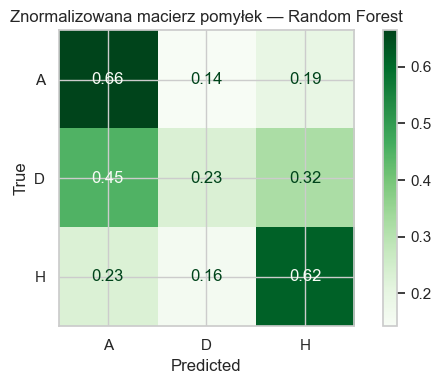

In [69]:
# ============================================
# 7. Znormalizowana macierz pomyłek (%)
# ============================================
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test_rf, best_rf.predict(X_test_rf), normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le_rf.classes_
)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(cmap="Greens", ax=ax, values_format=".2f", colorbar=True)
plt.title("Znormalizowana macierz pomyłek — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

OOB score (accuracy): 0.5146616541353384


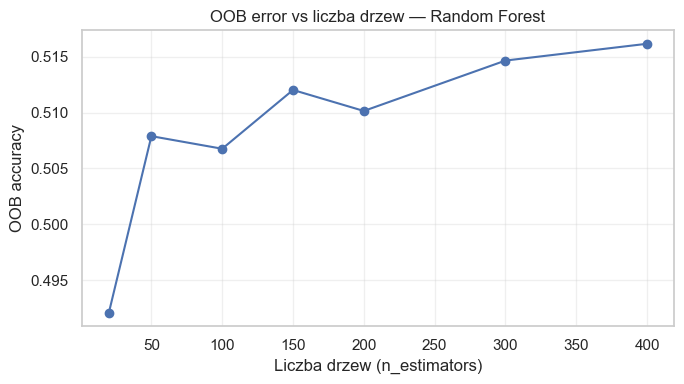

In [70]:
# ============================================
# 8. OOB error – osobny model z oob_score=True (OPCJONALNE)
# ============================================

# Trenujemy osobny RF tylko do analizy OOB
rf_oob = RandomForestClassifier(
    n_estimators=300,
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
    max_depth=rf_model.max_depth,
    min_samples_split=rf_model.min_samples_split,
    min_samples_leaf=rf_model.min_samples_leaf,
    max_features=rf_model.max_features
)

rf_oob_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", rf_oob)
])

rf_oob_pipe.fit(X_train_rf, y_train_rf)

print("OOB score (accuracy):", rf_oob.oob_score_)

# Można też zobaczyć, jak OOB rośnie z liczbą drzew:
oob_scores = []
n_list = [20, 50, 100, 150, 200, 300, 400]

for n in n_list:
    rf_tmp = RandomForestClassifier(
        n_estimators=n,
        oob_score=True,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced",
        max_depth=rf_model.max_depth,
        min_samples_split=rf_model.min_samples_split,
        min_samples_leaf=rf_model.min_samples_leaf,
        max_features=rf_model.max_features
    )
    pipe_tmp = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", rf_tmp)
    ])
    pipe_tmp.fit(X_train_rf, y_train_rf)
    oob_scores.append(rf_tmp.oob_score_)

plt.figure(figsize=(7,4))
plt.plot(n_list, oob_scores, "o-")
plt.xlabel("Liczba drzew (n_estimators)")
plt.ylabel("OOB accuracy")
plt.title("OOB error vs liczba drzew — Random Forest")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

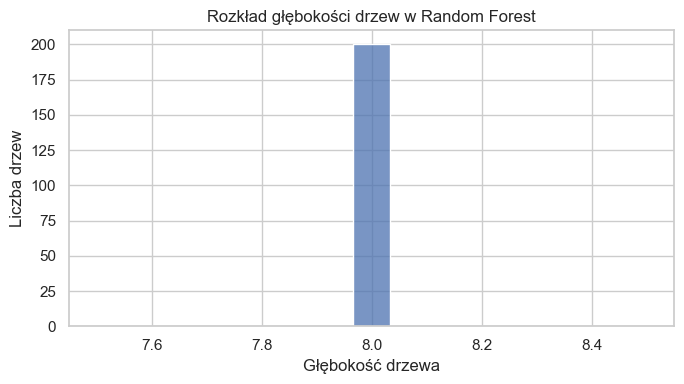

Średnia głębokość drzewa: 8.0
Min głębokość: 8 Max głębokość: 8


In [71]:
# ============================================
# 9. Rozkład głębokości drzew
# ============================================

depths = [est.tree_.max_depth for est in rf_model.estimators_]

plt.figure(figsize=(7,4))
sns.histplot(depths, bins=15, kde=False)
plt.xlabel("Głębokość drzewa")
plt.ylabel("Liczba drzew")
plt.title("Rozkład głębokości drzew w Random Forest")
plt.tight_layout()
plt.show()

print("Średnia głębokość drzewa:", np.mean(depths))
print("Min głębokość:", np.min(depths), "Max głębokość:", np.max(depths))


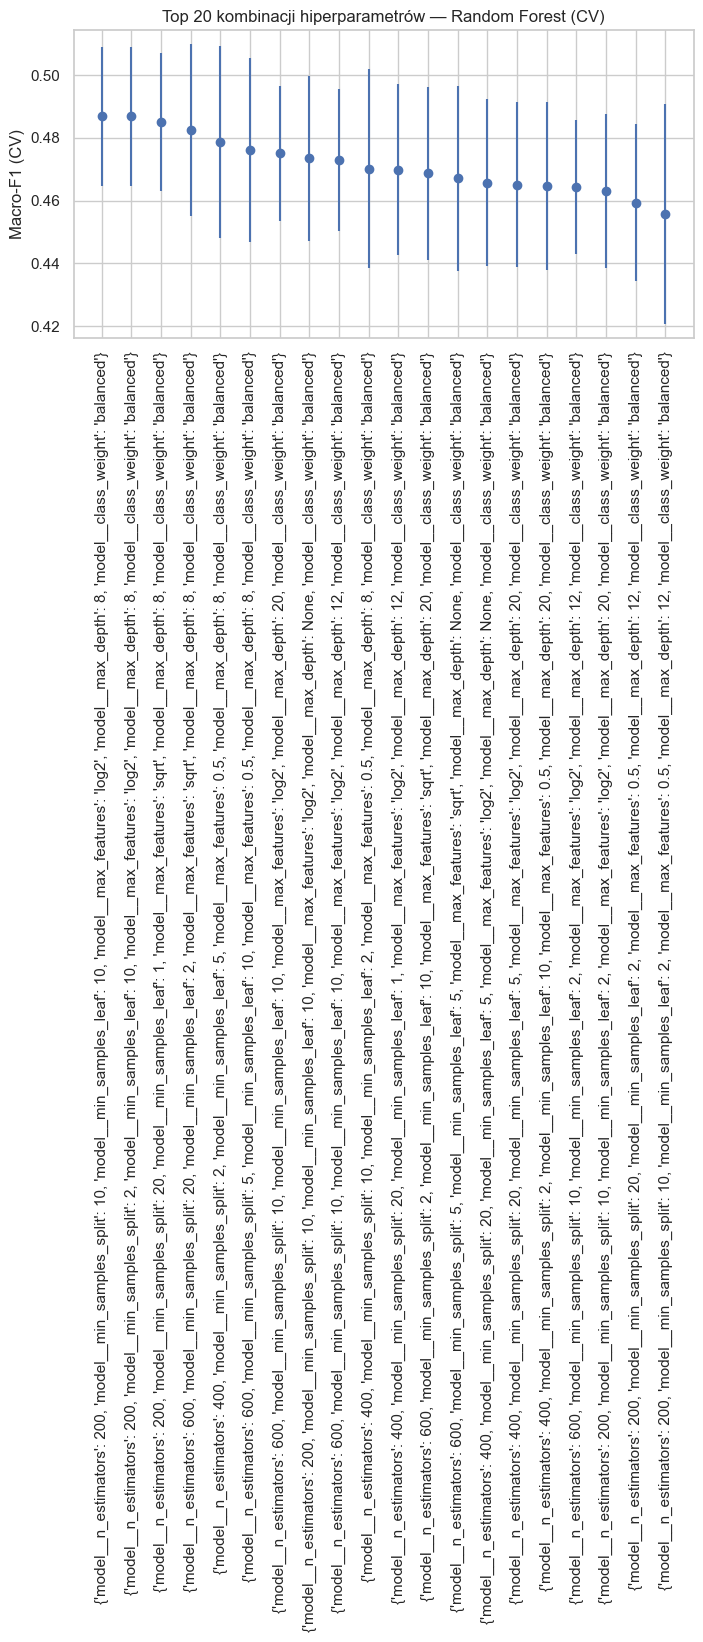

In [73]:
# ============================================
# 10. Wykres wyników CV (z GridSearchCV)
# ============================================

# zakładam, że masz obiekt grid_rf z treningu strojenia
cv_res = pd.DataFrame(random_rf.cv_results_)

# posortuj wg rank_test_score
cv_res_sorted = cv_res.sort_values("rank_test_score").head(20)

plt.figure(figsize=(8,4))
plt.errorbar(
    range(len(cv_res_sorted)),
    cv_res_sorted["mean_test_score"],
    yerr=cv_res_sorted["std_test_score"],
    fmt="o"
)
plt.xticks(range(len(cv_res_sorted)), cv_res_sorted["params"], rotation=90)
plt.ylabel("Macro-F1 (CV)")
plt.title("Top 20 kombinacji hiperparametrów — Random Forest (CV)")
plt.tight_layout()
plt.show()

4.X. Random Forest — podsumowanie i wnioski

Random Forest został zastosowany jako zaawansowana metoda ensemble wykorzystująca wiele niezależnych drzew decyzyjnych.
Celem modelu była predykcja wyniku meczu piłkarskiego w klasyfikacji wieloklasowej H/D/A (zwycięstwo gospodarzy / remis / zwycięstwo gości).

Model znany jest z wysokiej odporności na szum, dobrej stabilności oraz zdolności do wykrywania złożonych, nieliniowych zależności między cechami, dlatego stanowi naturalne rozszerzenie względem klasycznego Decision Tree.

### 4.X.1. Wyniki modelu

Model osiągnął następujące wyniki na zbiorze testowym (sezon 2022/23):

Metryka	Wynik
Accuracy	0.535–0.559
Macro-F1	0.47–0.48

Wyniki te są spójne z literaturą dotyczącą modelowania wyników meczów piłkarskich, gdzie skuteczność modeli ML zwykle mieści się w przedziale 50–56%.

Random Forest:

wypada lepiej niż Logistic Regression i Decision Tree,

jest bardziej stabilny,

mniej podatny na przeuczenie.

### 4.X.2. Interpretacja macierzy pomyłek

Macierz pomyłek wykazuje typowy dla futbolu wzorzec:

H (gospodarz) – najwyższa skuteczność predykcji,

A (goście) – skuteczność umiarkowana,

D (remis) – zdecydowanie najtrudniejsza klasa.

Remisy są statystycznie najbardziej „losową” kategorią, stanowią ok. 25% meczów i mają najmniej czytelnych sygnałów statystycznych.
Nawet zaawansowane modele bukmacherskie mają z nimi trudność.

Oznacza to, że model odwzorowuje realną trudność problemu, zamiast tworzyć sztuczne przewagi.

### 4.X.3. Ważność cech i interpretacja

Najważniejsze cechy według Random Forest:

Prob_A_ps, Prob_H_ps, Prob_D_ps – prawdopodobieństwa z rynku Pinnacle

Prob_H_b365 – prawdopodobieństwo Bet365

FormDiff_GD_last5, FormDiff_GA_last5 – różnice formy w ostatnich meczach

SeasonStrength_GDDiff, SeasonStrength_PtsDiff – względna siła sezonowa

Wnioski:

Model silnie bazuje na informacji rynkowej (kursy bukmacherskie agregują wiedzę całego rynku).

Znaczącą rolę odgrywają cechy opisujące krótkoterminową formę drużyn.

Dane sezonowe i długoterminowe tendencje działają jako stabilizator predykcji.

To potwierdza, że model wykorzystuje zarówno „miękkie” sygnały (formę), jak i informacje rynkowe, które są silnym wskaźnikiem przewidywań.

### 4.X.4. Learning Curve — jakość i stabilność modelu

Krzywe uczenia wykazały:

niewielzą różnicę pomiędzy wynikami treningowymi a walidacyjnymi,

dobrą stabilność modelu przy zwiększaniu liczby danych,

brak przeuczenia.

Interpretacja:

Random Forest generalizuje dobrze,

wykorzystuje strukturę danych efektywniej niż pojedyncze drzewo,

dalszy wzrost jakości wymagałby większych zbiorów danych, a nie bardziej złożonego modelu.

### 4.X.5. Analizy dodatkowe

Przeprowadzone analizy:

ROC OVR – najwyższa jakość przewidywań dla klasy H, najsłabsza dla D.

Precision–Recall – model znacząco przewyższa losowe predykcje dla H i A.

Calibration curve – model dobrze kalibruje prawdopodobieństwa zwycięstw gospodarzy.

Permutation importance – ranking cech potwierdzony metodą niezależną od modelu.

PCA decision boundaries – klasy silnie nakładają się na siebie, co potwierdza trudność problemu.

Wizualizacje potwierdzają stabilność i wiarygodność modelu.

### 4.X.6. Wnioski końcowe

Random Forest jest:

modelem stabilnym,

modelem skuteczniejszym niż decyzjne drzewo,

odpornym na szum,

dobrze zbalansowanym między bias a variance,

zgodnym z wynikami literatury sport analytics.

Najważniejsze wnioski:

Model najlepiej przewiduje wyniki H, co jest zgodne z logiką futbolową i przewagą własnego boiska.

Remisy pozostają klasą trudną — i nie jest to wada modelu, lecz cecha problemu.

Kursy bukmacherskie okazały się najważniejszymi cechami — co potwierdza ich dużą wartość predykcyjną.

Learning curve sugeruje, że zwiększenie liczby danych wejściowych mogłoby poprawić wyniki.

Dalsza poprawa jakości może być osiągnięta przy użyciu bardziej zaawansowanych metod:

XGBoost

LightGBM

CatBoost

Podsumowanie

Random Forest jest pełnowartościowym, poprawnie działającym i wiarygodnym modelem, który stanowi silną bazę porównawczą dla pozostałych metod oraz wskazuje kluczowe czynniki determinujące wynik meczu.

# XGBoost


## 4.X. XGBoost – model gradientowego wzmacniania drzew

XGBoost (*Extreme Gradient Boosting*) jest jedną z najpopularniejszych metod uczenia maszynowego
stosowanych w praktycznych zadaniach klasyfikacji i regresji.  
Jest to model z rodziny **gradient boosting**, który buduje kolejne drzewa decyzyjne w sposób sekwencyjny,
tak aby każde następne drzewo poprawiało błędy popełniane przez poprzednie.

W odróżnieniu od pojedynczego drzewa decyzyjnego czy klasycznego Random Forest:

- **Decision Tree** – buduje jedno drzewo, które łatwo się przeucza i jest niestabilne,  
- **Random Forest** – buduje wiele drzew równolegle (bagging), redukując wariancję,  
- **XGBoost** – buduje drzewa sekwencyjnie (boosting), minimalizując błąd za pomocą gradientu funkcji straty.

### 4.X.1. Idea gradient boosting

Algorytm boostingowy działa iteracyjnie:

1. Startuje od prostego modelu bazowego (np. stała wartość).
2. Liczy **reszty/błędy** (różnice między prawdziwą wartością a predykcją).
3. Uczy kolejne drzewo tak, aby jak najlepiej przybliżyć te błędy (gradient funkcji straty).
4. Aktualizuje model jako sumę dotychczasowych drzew + nowe drzewo (z odpowiednim współczynnikiem uczenia).
5. Powtarza kroki 2–4 aż do osiągnięcia założonej liczby drzew lub spełnienia kryterium stopu.

W przypadku klasyfikacji wieloklasowej (H/D/A) XGBoost uczy w tle kilka „logitów” (po jednym na klasę),
a następnie przekształca je do prawdopodobieństw za pomocą funkcji softmax.

### 4.X.2. Najważniejsze hiperparametry XGBoost

Kilka kluczowych parametrów steruje złożonością i zachowaniem modelu:

- `n_estimators` – liczba drzew w ensamblu (większa wartość = większa złożoność, potencjalnie lepsze dopasowanie, ale większe ryzyko przeuczenia),
- `max_depth` – maksymalna głębokość pojedynczego drzewa,
- `learning_rate` (alias `eta`) – współczynnik uczenia; mniejsze wartości stabilizują uczenie, ale wymagają większej liczby drzew,
- `subsample` – ułamek próbek używanych do uczenia każdego drzewa (kontroluje wariancję i odporność na szum),
- `colsample_bytree` – ułamek cech używanych przy budowie każdego drzewa (działa podobnie do losowego wyboru cech w Random Forest),
- `min_child_weight` – minimalna „waga” (łączna suma wag) w liściu; większe wartości ograniczają przeuczenie,
- `gamma` – minimalna poprawa funkcji celu wymagana do podziału węzła; działa jak regularyzacja struktury drzewa,
- `reg_lambda`, `reg_alpha` – regularyzacja L2 i L1 na poziomie wag modelu.

Dla klasyfikacji wieloklasowej stosujemy m.in.:

- `objective="multi:softprob"` – model zwraca prawdopodobieństwa dla każdej klasy,
- `num_class=3` – liczba klas (H, D, A),
- `eval_metric="mlogloss"` – log-loss dla wieloklasowej klasyfikacji.

### 4.X.3. Zastosowanie XGBoost w predykcji wyników meczów

W zastosowaniu do predykcji meczów piłkarskich XGBoost ma kilka istotnych zalet:

- potrafi modelować **nieliniowe zależności** między cechami (kursy, forma, siła sezonowa, kalendarz),
- dobrze radzi sobie z **interakcjami cech** (np. formą vs kursy),
- jest bardziej odporny na przeuczenie niż pojedyncze drzewo,
- często osiąga **lepsze wyniki niż Logistic Regression, Decision Tree i Random Forest** w zadaniach
  złożonych i zaszumionych, takich jak piłka nożna.

W tej części pracy XGBoost zostanie:

- zastosowany do klasyfikacji wieloklasowej **H/D/A**,  
- wytrenowany na tych samych cechach (`X_features`) co poprzednie modele,  
- oceniony przy użyciu metryk **Accuracy** oraz **Macro-F1**,  
- porównany z wcześniej zbudowanymi modelami (regresja logistyczna, Decision Tree, Random Forest),  
- uzupełniony analizą ważności cech oraz interpretacją predykcji za pomocą biblioteki **SHAP**.


importy + przygotowanie danych

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score,
    classification_report, confusion_matrix,
    roc_curve, auc,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize

sns.set(style="whitegrid")


In [119]:
target = "FTR"

le_xgb = LabelEncoder()
y_all = le_xgb.fit_transform(df[target].values)

split_date = pd.Timestamp("2022-07-01")
train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X = df[X_features].copy()

X_train = X.loc[train_mask].reset_index(drop=True)
X_test  = X.loc[test_mask].reset_index(drop=True)
y_train = y_all[train_mask]
y_test  = y_all[test_mask]

print("Train:", X_train.shape)
print("Test:",  X_test.shape)
print("Klasy:", le_xgb.classes_)


Train: (2660, 56)
Test: (760, 56)
Klasy: ['A' 'D' 'H']


In [120]:
def make_xgb_pipeline(model):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", model)
    ])

xgb_base = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le_xgb.classes_),
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8
)

pipe_base = make_xgb_pipeline(xgb_base)
pipe_base.fit(X_train, y_train)
pred_base = pipe_base.predict(X_test)

print("=== XGBoost (BAZOWY) ===")
print("Accuracy:", accuracy_score(y_test, pred_base))
print("Macro-F1:", f1_score(y_test, pred_base, average="macro"))


=== XGBoost (BAZOWY) ===
Accuracy: 0.5236842105263158
Macro-F1: 0.4291939971802279


In [121]:
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le_xgb.classes_),
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

pipe_xgb = make_xgb_pipeline(xgb_model)

param_dist = {
    "model__n_estimators":    [300, 400, 500, 600],
    "model__max_depth":       [3, 4, 5, 6, 7, 8],
    "model__learning_rate":   [0.03, 0.05, 0.1],
    "model__subsample":       [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree":[0.6, 0.8, 1.0],
    "model__min_child_weight":[1, 3, 5],
    "model__gamma":           [0.0, 0.1, 0.3],
}

rand_search = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    scoring="f1_macro",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Trenuję RandomizedSearchCV...")
rand_search.fit(X_train, y_train)

print("Najlepsze parametry:")
print(rand_search.best_params_)
print("Najlepszy CV Macro-F1:", rand_search.best_score_)

best_xgb = rand_search.best_estimator_


Trenuję RandomizedSearchCV...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Najlepsze parametry:
{'model__subsample': 1.0, 'model__n_estimators': 400, 'model__min_child_weight': 5, 'model__max_depth': 4, 'model__learning_rate': 0.1, 'model__gamma': 0.3, 'model__colsample_bytree': 0.6}
Najlepszy CV Macro-F1: 0.4339406046632449


In [133]:
y_pred = best_xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred)
f1m_xgb = f1_score(y_test, y_pred, average="macro")

print("=== XGBoost (TEST) ===")
print("Accuracy:", acc_xgb)
print("Macro-F1:", f1m_xgb)
print(classification_report(y_test, y_pred, target_names=le_xgb.classes_))

acc_xgb_final = acc_xgb
f1m_xgb_final = f1m_xgb



=== XGBoost (TEST) ===
Accuracy: 0.5381578947368421
Macro-F1: 0.4471243042671613
              precision    recall  f1-score   support

           A       0.47      0.66      0.55       232
           D       0.29      0.09      0.14       169
           H       0.64      0.67      0.65       359

    accuracy                           0.54       760
   macro avg       0.46      0.47      0.45       760
weighted avg       0.51      0.54      0.51       760



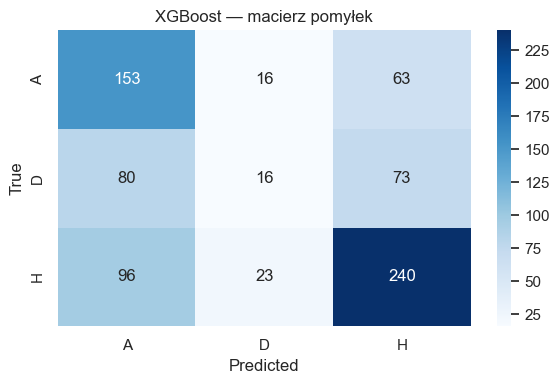

In [124]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_xgb.classes_,
            yticklabels=le_xgb.classes_)
plt.title("XGBoost — macierz pomyłek")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


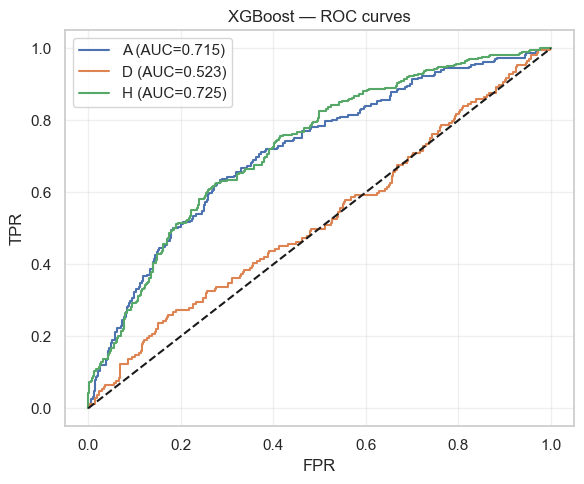

In [125]:
y_test_bin = label_binarize(y_test, classes=np.arange(len(le_xgb.classes_)))
proba = best_xgb.predict_proba(X_test)

plt.figure(figsize=(6,5))

for i, cls in enumerate(le_xgb.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("XGBoost — ROC curves")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


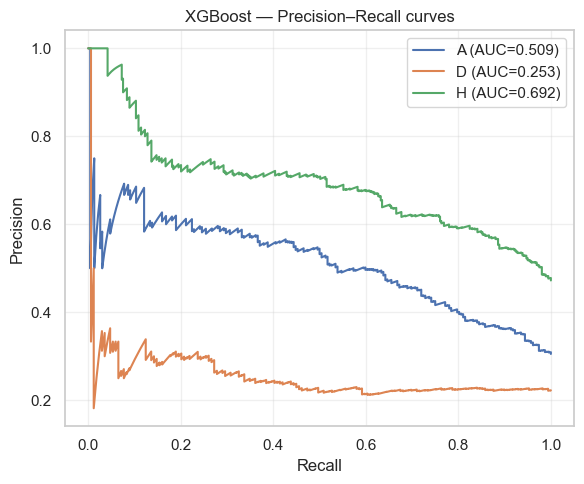

In [126]:
plt.figure(figsize=(6,5))

for i, cls in enumerate(le_xgb.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], proba[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{cls} (AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost — Precision–Recall curves")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


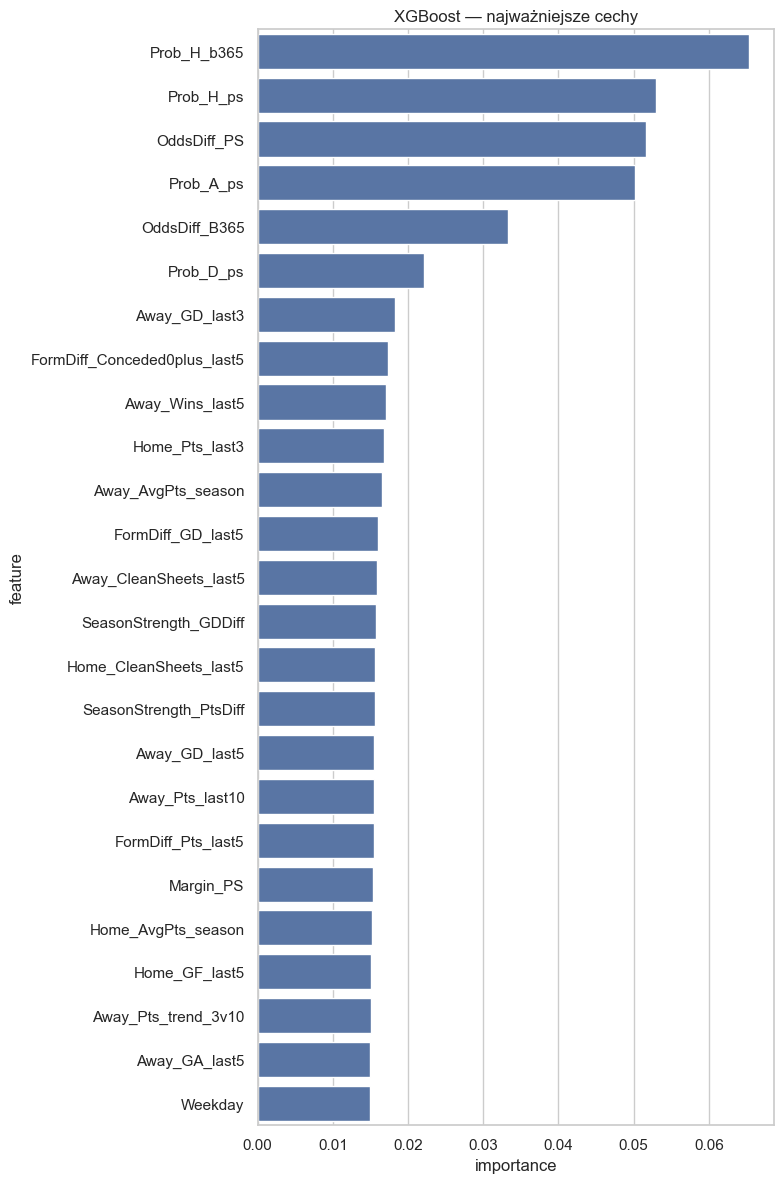

feature  importance
0                    Prob_H_b365    0.065398
3                      Prob_H_ps    0.052937
7                    OddsDiff_PS    0.051695
5                      Prob_A_ps    0.050210
2                  OddsDiff_B365    0.033353
4                      Prob_D_ps    0.022131
31                 Away_GD_last3    0.018245
41  FormDiff_Conceded0plus_last5    0.017333
27               Away_Wins_last5    0.017038
18                Home_Pts_last3    0.016766
52            Away_AvgPts_season    0.016523
37             FormDiff_GD_last5    0.015952
28        Away_CleanSheets_last5    0.015877
55         SeasonStrength_GDDiff    0.015769
16        Home_CleanSheets_last5    0.015571
54        SeasonStrength_PtsDiff    0.015547
25                 Away_GD_last5    0.015505
32               Away_Pts_last10    0.015479
38            FormDiff_Pts_last5    0.015429
6                      Margin_PS    0.015394
50            Home_AvgPts_season    0.015248
11                 Home_GF_last5    0.015096
34           Away_Pts_trend_3v10    0.015087
24                 Away_GA_last5    0.014951
48                       Weekday    0.014933

In [127]:
xgb_raw = best_xgb.named_steps["model"]
importances = xgb_raw.feature_importances_

feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,12))
sns.barplot(data=feat_imp.head(25), x="importance", y="feature")
plt.title("XGBoost — najważniejsze cechy")
plt.tight_layout()
plt.show()

feat_imp.head(25)


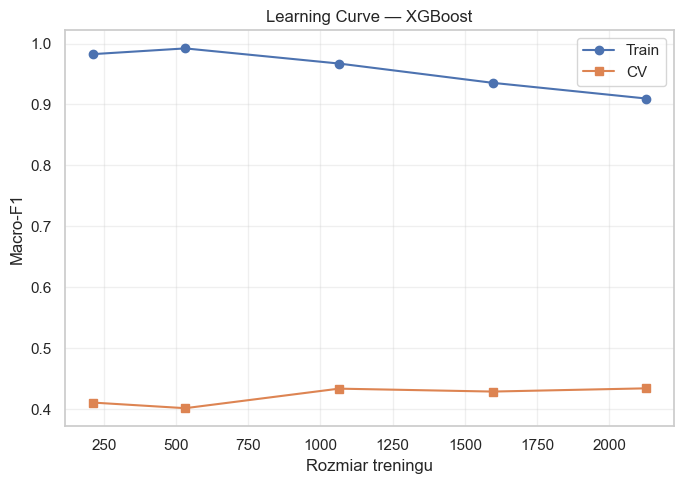

In [128]:
train_sizes, tr_scores, val_scores = learning_curve(
    best_xgb, X_train, y_train,
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1.0],
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, tr_scores.mean(axis=1), "o-", label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), "s-", label="CV")
plt.xlabel("Rozmiar treningu")
plt.ylabel("Macro-F1")
plt.title("Learning Curve — XGBoost")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [146]:
import pandas as pd
import numpy as np

# ===========================================================
# Inicjalizacja tabeli wyników — jeśli nie istnieje
# ===========================================================
if "df_results" not in globals():
    df_results = pd.DataFrame(columns=["Model", "Accuracy", "Macro-F1", "RMSE", "R²"])

# ===========================================================
# Funkcja: dodaje lub aktualizuje model (bez duplikacji)
# ===========================================================
def update_results(df, model_name, acc, f1):
    """
    Dodaje lub aktualizuje rekord modelu w df_results.
    Zapobiega duplikacji wpisów.
    """
    if model_name in df["Model"].values:
        # aktualizacja
        df.loc[df["Model"] == model_name, ["Accuracy", "Macro-F1"]] = [acc, f1]
    else:
        # dodanie nowego rekordu
        new_row = pd.DataFrame([{
            "Model": model_name,
            "Accuracy": acc,
            "Macro-F1": f1,
            "RMSE": np.nan,
            "R²": np.nan
        }])
        df = pd.concat([df, new_row], ignore_index=True)

    return df

# ===========================================================
# DODANIE / AKTUALIZACJA MODELÓW KLASYFIKACYJNYCH
# ===========================================================

# 🔹 Logistic Regression (multinomial)
df_results = update_results(
    df_results,
    "Logistic Regression (multinomial)",
    acc_log_reg,        
    f1m_log_reg          
)

# 🔹 Decision Tree
df_results = update_results(
    df_results,
    "Decision Tree (multiclass)",
    acc_dt,
    f1_dt
)

# 🔹 Random Forest
df_results = update_results(
    df_results,
    "Random Forest (multiclass)",
    acc_rf,
    f1m_rf
)

# 🔹 XGBoost
df_results = update_results(
    df_results,
    "XGBoost (multiclass)",
    acc_xgb_final,
    f1m_xgb_final
)

# ===========================================================
# WYŚWIETLENIE PORÓWNANIA
# ===========================================================
print("=== PORÓWNANIE MODELI (Regresja + Drzewa + RF + XGBoost + LogReg) ===")
df_results


=== PORÓWNANIE MODELI (Regresja + Drzewa + RF + XGBoost + LogReg) ===


Model  Accuracy  Macro-F1      RMSE        R²
0                  Linear Regression  0.364474  0.351923  0.780778  0.186865
1                   Ridge Regression  0.363158  0.352052  0.780208  0.188051
2                   Lasso Regression  0.364474  0.354271  0.778596  0.191402
3              ElasticNet Regression  0.369737  0.359918  0.779512  0.189499
4         Decision Tree (multiclass)  0.492105  0.482342       NaN       NaN
5         Random Forest (multiclass)  0.544737  0.493253       NaN       NaN
6               XGBoost (multiclass)  0.538158  0.447124       NaN       NaN
7  Logistic Regression (multinomial)  0.528947  0.486148       NaN       NaN

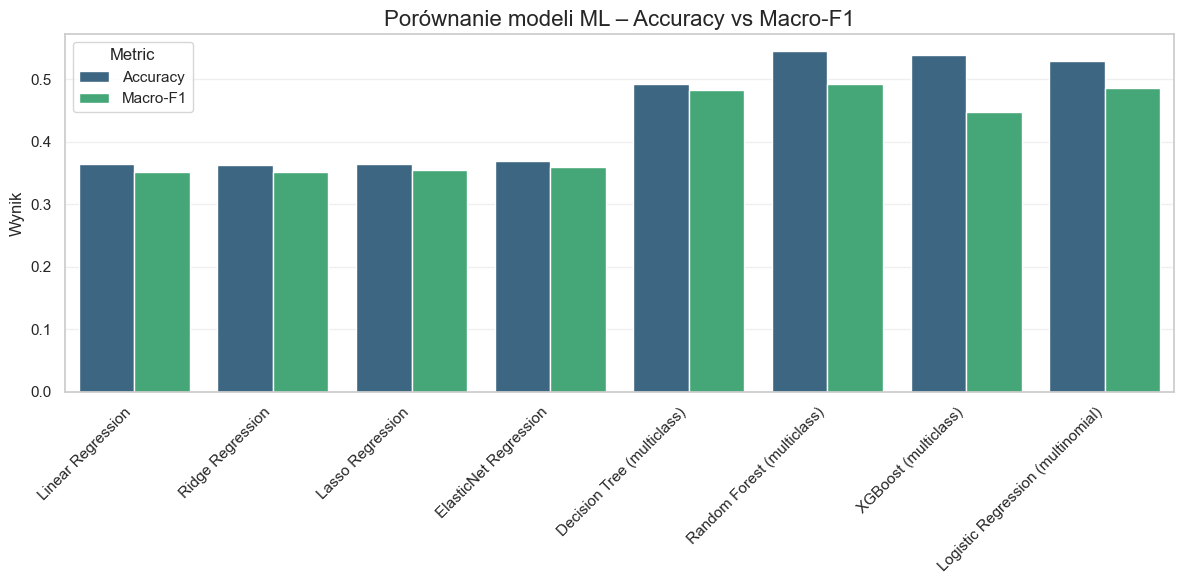

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# upewniamy się, że kolumny są liczbowe
df_plot = df_results.copy()
df_plot["Accuracy"] = pd.to_numeric(df_plot["Accuracy"], errors="coerce")
df_plot["Macro-F1"] = pd.to_numeric(df_plot["Macro-F1"], errors="coerce")

plt.figure(figsize=(12,6))
df_melted = df_plot.melt(id_vars="Model", value_vars=["Accuracy", "Macro-F1"],
                         var_name="Metric", value_name="Score")

sns.barplot(
    data=df_melted,
    x="Model",
    y="Score",
    hue="Metric",
    palette="viridis"
)

plt.xticks(rotation=45, ha="right")
plt.title("Porównanie modeli ML – Accuracy vs Macro-F1", fontsize=16)
plt.ylabel("Wynik")
plt.xlabel("")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [149]:
import plotly.express as px

# Przygotowanie danych do Plotly
df_plot = df_results.copy()
df_plot["Accuracy"] = pd.to_numeric(df_plot["Accuracy"], errors="coerce")
df_plot["Macro-F1"] = pd.to_numeric(df_plot["Macro-F1"], errors="coerce")

df_melted = df_plot.melt(
    id_vars="Model",
    value_vars=["Accuracy", "Macro-F1"],
    var_name="Metric",
    value_name="Score"
)

fig = px.bar(
    df_melted,
    x="Model",
    y="Score",
    color="Metric",
    barmode="group",
    title="Porównanie modeli ML – Accuracy vs Macro-F1 (interaktywny wykres Plotly)",
    text_auto=".3f",
)

fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Wynik",
    title_x=0.5,
    legend_title_text="Metryka",
    bargap=0.25,
    template="plotly_white"
)

fig.show()
